In [1]:
import os
import json
import requests
import time
import sys
import shutil

import glob
import pickle
import torch
import safetensors.torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms



In [3]:


def ensure_folder_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)  # 自動建立資料夾



In [4]:
prefixs = [ "LoRA_Trigger", "LoRA_noTrigger", "noLoRA_Trigger", "noLoRA_noTrigger"]


In [5]:
def rename_files():
    base_path = "..\\data\\input"
    for p in prefixs:
        folder_path = os.path.join(base_path, p)
        ensure_folder_exists(folder_path)
        counter = 0
        for file_name in os.listdir(folder_path):
            src = os.path.join(folder_path, file_name)
            dst = os.path.join(folder_path, p + "_" + str(counter) + ".png")
            os.rename(src, dst)
            counter += 1


In [70]:
rename_files()

FileExistsError: [WinError 183] 當檔案已存在時，無法建立該檔案。: '..\\data\\input\\LoRA_Trigger\\LoRA_Trigger_10.png' -> '..\\data\\input\\LoRA_Trigger\\LoRA_Trigger_2.png'

In [71]:
# read api from json file
api = {}
with open("anaysis with LoRA api.json", "r") as f:
    api = f.read()
api = json.loads(api)

trigger_prompt = "zzMimikyu, solo, pokemon (creature), no humans, animal focus, mimikyu, "
object_prompt = "a cute rat"

In [72]:
class Config:
    def __init__(self, model, LoRA, input_image, trigger_prompt, object_prompt, file_prefix, total_steps, current_step):
        self.model = model
        self.LoRA = LoRA
        self.input_image = input_image
        self.trigger_prompt = trigger_prompt
        self.object_prompt = object_prompt
        self.file_prefix = file_prefix
        self.total_steps = total_steps
        self.current_step = current_step

    def add_step(self):
        self.current_step += 1

    def set_input_image(self, input_image):
        self.input_image = input_image

config = Config(
    model="dreamshaper_8.safetensors",
    LoRA="Mimikyu_Pokemon_PDXL.safetensors",
    input_image="input_image.png",
    trigger_prompt=trigger_prompt,
    object_prompt=object_prompt,
    file_prefix=prefixs,
    total_steps=20,
    current_step=0
)

In [73]:


def modify_api(api, config, counter = 0):
    api["prompt"]["3"]["inputs"]["ckpt_name"] = config.model
    api["prompt"]["2"]["inputs"]["lora_name"] = config.LoRA
    api["prompt"]["7"]["inputs"]["image"] = config.input_image
    api["prompt"]["4"]["inputs"]["text"] = config.trigger_prompt + config.object_prompt
    api["prompt"]["11"]["inputs"]["filename_prefix"] = f"{config.file_prefix}/{config.object_prompt}/{config.input_image}/{config.current_step}"
    api["prompt"]["15"]["inputs"]["filename_prefix"] = f"{config.file_prefix}/{config.object_prompt}/{config.input_image}/{config.current_step}@{counter}@"
    api["prompt"]["10"]["inputs"]["steps"] = config.total_steps
    api["prompt"]["10"]["inputs"]["denoise"] =  1-config.current_step/ config.total_steps
    api["prompt"]["1"]["inputs"]["start_at_step"] = config.current_step
    api["prompt"]["1"]["inputs"]["end_at_step"] = config.current_step + 1
    return api

In [75]:
import shutil
output_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
for filename in os.listdir(output_folder):
    file_path = os.path.join(output_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

In [76]:
import shutil


generate_counter = 1

for prefix in prefixs:
    config.file_prefix = prefix
    object_prompt = "a cute rat"
    config.object_prompt = object_prompt
    for input_image in os.listdir(f"..\\..\\..\\myComfyUI\\input"):
        if prefix not in input_image:
            continue
        print(f"{prefix} {object_prompt} {input_image}")
        config.set_input_image(input_image)
        config.current_step = 0
        for i in range(20-1):
            config.current_step = i
            api = modify_api(api, config, generate_counter)
            generate_counter += 1
            send_request(api)
            print(f"{prefix} {object_prompt} {i} done")

LoRA_Trigger a cute rat LoRA_Trigger_0.png
200
{'prompt_id': '2641f5ad-a417-4b3b-8065-8e62022aba7e', 'number': 2028, 'node_errors': {}}
LoRA_Trigger a cute rat 0 done
200
{'prompt_id': 'c685179a-9489-4e18-ba71-6513577d8e7d', 'number': 2029, 'node_errors': {}}
LoRA_Trigger a cute rat 1 done
200
{'prompt_id': 'b4f0d604-c663-4e3a-bdf9-451fc359521c', 'number': 2030, 'node_errors': {}}
LoRA_Trigger a cute rat 2 done
200
{'prompt_id': '3bbfdab7-6097-46c5-9934-ce6a524283a8', 'number': 2031, 'node_errors': {}}
LoRA_Trigger a cute rat 3 done
200
{'prompt_id': 'd194d65e-9c16-4f40-8965-ebdce967da35', 'number': 2032, 'node_errors': {}}
LoRA_Trigger a cute rat 4 done
200
{'prompt_id': '7307cec1-5092-4643-add0-7b6b4473afa7', 'number': 2033, 'node_errors': {}}
LoRA_Trigger a cute rat 5 done
200
{'prompt_id': '1032ed72-2d5a-4e04-8da6-842b399140f4', 'number': 2034, 'node_errors': {}}
LoRA_Trigger a cute rat 6 done
200
{'prompt_id': 'b3ae58a1-8bb5-411b-b938-fa0fe341d183', 'number': 2035, 'node_errors': 

In [ ]:
import json
import requests
def send_request(api):
    # 3. 設定 API 的 URL 與 headers
    url = 'http://127.0.0.1:8188/prompt'
    headers = {'Content-Type': 'application/json'}

    # 4. 發送 POST request 並傳送修改後的 JSON 資料
    response = requests.post(url, headers=headers, data=json.dumps(api))

    # 5. 輸出回應結果
    print(response.status_code)
    print(response.json())

In [66]:
config2 = Config(
    model="dreamshaper_8.safetensors",
    LoRA="Mimikyu_Pokemon_PDXL.safetensors",
    input_image="noLoRA_Trigger_5.png",
    trigger_prompt=trigger_prompt,
    object_prompt=object_prompt,
    file_prefix=prefixs[0],
    total_steps=20,
    current_step=15
)
send_request(modify_api(api, config2, 18))

200
{'prompt_id': 'e6332703-ab44-4d67-8ab5-5be461ee987c', 'number': 2027, 'node_errors': {}}


In [2]:
hspace_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
data_folder = "..\\data"

for prefix in os.listdir(data_folder):
    for prompt in os.listdir(os.path.join(data_folder, prefix)):
        for image_name in os.listdir(os.path.join(data_folder, prefix, prompt)):
            for file_name in os.listdir(os.path.join(data_folder, prefix, prompt, image_name)):
                if '@' in file_name:
                    index = file_name.split('@')[1]
                    print(index)
                    hspace_file = os.path.join(hspace_folder, index+".pkl")
                    destination = os.path.join(data_folder, prefix, prompt, image_name)
                    # if hspace file exist
                    if os.path.exists(hspace_file):
                        shutil.move(hspace_file, destination)
                    else:
                        print(f"{hspace_file} not exist")




        


609
..\..\..\myComfyUI\output\lab\hspace\609.pkl not exist
619
..\..\..\myComfyUI\output\lab\hspace\619.pkl not exist
620
..\..\..\myComfyUI\output\lab\hspace\620.pkl not exist
621
622
623
624
625
626
627
610
611
612
613
614
615
616
617
618
628
638
639
640
641
642
643
644
645
646
629
630
631
632
633
634
635
636
637
647
657
658
659
660
661
662
663
664
665
648
649
650
651
652
653
654
655
656
666
676
677
678
679
680
681
682
683
684
667
668
669
670
671
672
673
674
675
685
695
696
697
698
699
700
701
702
703
686
687
688
689
690
691
692
693
694
704
714
715
716
717
718
719
720
721
722
705
706
707
708
709
710
711
712
713
723
733
734
735
736
737
738
739
740
741
724
725
726
727
728
729
730
731
732
742
752
753
754
755
756
757
758
759
760
743
744
745
746
747
748
749
750
751
761
771
772
773
774
775
776
777
778
779
762
763
764
765
766
767
768
769
770
780
790
791
792
793
794
795
796
797
798
781
782
783
784
785
786
787
788
789
799
809
810
811
812
813
814
815
816
817
800
801
802
803
804
805
806
807
808

In [12]:
class read_file():
    def __init__(self, file_path):
        pass

    def load_hspace_file(filepath):
        """讀取 .pkl 檔案，並將 numpy.ndarray 轉換為 numpy array"""
        with open(filepath, 'rb') as f:
            arr = pickle.load(f)
        return arr

    def load_latent_file(filepath):
        """利用 safetensors.torch 讀取 .latent 檔案，並取出 'latent_tensor'"""
        sd = safetensors.torch.load_file(filepath)
        return sd['latent_tensor'].numpy()

    def load_image_file(filepath):
        """讀取圖片檔案，並轉換為 numpy array"""
        img = PIL.Image.open(filepath)
        return np.array(img)


In [56]:
experiment_data = {}
for prefix in os.listdir(data_folder):
    experiment_data[prefix] = {}
    for prompt in os.listdir(os.path.join(data_folder, prefix)):
        experiment_data[prefix][prompt] = {}
        for image_name in os.listdir(os.path.join(data_folder, prefix, prompt)):
            experiment_data[prefix][prompt][image_name] = {}
            experiment_data[prefix][prompt][image_name]["hspace"] = []
            experiment_data[prefix][prompt][image_name]["image"] = []
            experiment_data[prefix][prompt][image_name]["latent"] = []

            start_index = 9999999999
            for file_name in os.listdir(os.path.join(data_folder, prefix, prompt, image_name)):
                if '@' in file_name:
                    print(file_name)
                    index = int(file_name.split('@')[1])
                    start_index = min(start_index, index)
            
            
            for i in range(20-1):
                hspace_file = os.path.join(data_folder, prefix, prompt, image_name, f"{start_index+i}.pkl")
                image_file = os.path.join(data_folder, prefix, prompt, image_name, f"{i}@{start_index+i}@_00001_.png")
                latent_file = os.path.join(data_folder, prefix, prompt, image_name, f"{i}_00001_.latent")

                if os.path.exists(hspace_file) and os.path.exists(image_file) and os.path.exists(latent_file):
                    experiment_data[prefix][prompt][image_name]["hspace"].append(read_file.load_hspace_file(hspace_file))
                    experiment_data[prefix][prompt][image_name]["image"].append(read_file.load_image_file(image_file))
                    experiment_data[prefix][prompt][image_name]["latent"].append(read_file.load_latent_file(latent_file))
                else:
                    if not os.path.exists(hspace_file):
                        print(f"{hspace_file} not exist")
                    if not os.path.exists(image_file):
                        print(f"{image_file} not exist")
                    if not os.path.exists(latent_file):
                        print(f"{latent_file} not exist")




0@609@_00001_.png
10@619@_00001_.png
11@620@_00001_.png
12@621@_00001_.png
13@622@_00001_.png
14@623@_00001_.png
15@624@_00001_.png
16@625@_00001_.png
17@626@_00001_.png
18@627@_00001_.png
1@610@_00001_.png
2@611@_00001_.png
3@612@_00001_.png
4@613@_00001_.png
5@614@_00001_.png
6@615@_00001_.png
7@616@_00001_.png
8@617@_00001_.png
9@618@_00001_.png
0@628@_00001_.png
10@638@_00001_.png
11@639@_00001_.png
12@640@_00001_.png
13@641@_00001_.png
14@642@_00001_.png
15@643@_00001_.png
16@644@_00001_.png
17@645@_00001_.png
18@646@_00001_.png
1@629@_00001_.png
2@630@_00001_.png
3@631@_00001_.png
4@632@_00001_.png
5@633@_00001_.png
6@634@_00001_.png
7@635@_00001_.png
8@636@_00001_.png
9@637@_00001_.png
0@647@_00001_.png
10@657@_00001_.png
11@658@_00001_.png
12@659@_00001_.png
13@660@_00001_.png
14@661@_00001_.png
15@662@_00001_.png
16@663@_00001_.png
17@664@_00001_.png
18@665@_00001_.png
1@648@_00001_.png
2@649@_00001_.png
3@650@_00001_.png
4@651@_00001_.png
5@652@_00001_.png
6@653@_00001_.png
7

In [57]:
# turn experiment_data into numpy array
for prefix in experiment_data:
    for prompt in experiment_data[prefix]:
        for image_name in experiment_data[prefix][prompt]:
            experiment_data[prefix][prompt][image_name]["hspace"] = np.array(experiment_data[prefix][prompt][image_name]["hspace"])
            experiment_data[prefix][prompt][image_name]["image"] = np.array(experiment_data[prefix][prompt][image_name]["image"])
            experiment_data[prefix][prompt][image_name]["latent"] = np.array(experiment_data[prefix][prompt][image_name]["latent"])

In [58]:
print(experiment_data.keys())
print(experiment_data['LoRA_noTrigger'].keys())
print(experiment_data['LoRA_noTrigger']['a cute rat'].keys())
print(experiment_data['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_0.png'].keys())
print(len(experiment_data['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_0.png']['hspace']))
print(len(experiment_data['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_0.png']['image']))
print(len(experiment_data['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_0.png']['latent']))

dict_keys(['LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger'])
dict_keys(['a cute rat'])
dict_keys(['LoRA_noTrigger_0.png', 'LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])
dict_keys(['hspace', 'image', 'latent'])
19
19
19


In [59]:
# save experiment data
with open('experiment_data.pkl', 'wb') as f:
    pickle.dump(experiment_data, f)

In [2]:
# load experiment data
with open('experiment_data.pkl', 'rb') as f:
    experiment_data = pickle.load(f)
    

In [3]:
print(experiment_data.keys())
print(experiment_data['LoRA_noTrigger'].keys())
print(experiment_data['LoRA_noTrigger']['a cute rat'].keys())
print(experiment_data['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_0.png'].keys())
print(len(experiment_data['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_0.png']['hspace']))
print(len(experiment_data['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_0.png']['image']))
print(len(experiment_data['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_0.png']['latent']))

dict_keys(['LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger'])
dict_keys(['a cute rat'])
dict_keys(['LoRA_noTrigger_0.png', 'LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])
dict_keys(['hspace', 'image', 'latent'])
19
19
19


In [4]:
import numpy as np

def euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def frechet_recursive(ca, P, Q, i, j):
    if ca[i, j] > -1:
        return ca[i, j]
    elif i == 0 and j == 0:
        ca[i, j] = euclidean(P[0], Q[0])
    elif i > 0 and j == 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, i-1, 0), euclidean(P[i], Q[0]))
    elif i == 0 and j > 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, 0, j-1), euclidean(P[0], Q[j]))
    elif i > 0 and j > 0:
        ca[i, j] = max(min(frechet_recursive(ca, P, Q, i-1, j),
                           frechet_recursive(ca, P, Q, i-1, j-1),
                           frechet_recursive(ca, P, Q, i, j-1)),
                       euclidean(P[i], Q[j]))
    else:
        ca[i, j] = float('inf')
    return ca[i, j]

def frechet_distance(P, Q):
    ca = np.ones((len(P), len(Q))) * -1
    return frechet_recursive(ca, P, Q, len(P)-1, len(Q)-1)




In [5]:
# see as different step

# calculate the L2 distance of latent, image, hspace between each image and the first image
# also calculate the L1 distance of hspace between each image and the first image

def calculate_euclidean_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(0, 20-1):
                        distance = euclidean(experiment_data[prefix][prompt][image_name][key][i], experiment_data[prefix][prompt][first_image_name][key][i])
                        anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
anaysis_data = {"L2_step": {}, "frechet_step": {}, "L1_step": {}}
anaysis_data["L2_step"] = calculate_euclidean_distance(experiment_data)

LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png


In [6]:
print(anaysis_data["L2_step"].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger'].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger']['a cute rat'].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_1.png'].keys())
print(len(anaysis_data["L2_step"]['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_1.png']['hspace']))
print(len(anaysis_data["L2_step"]['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_1.png']['image']))
print(len(anaysis_data["L2_step"]['LoRA_noTrigger']['a cute rat']['LoRA_noTrigger_1.png']['latent']))



dict_keys(['LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger'])
dict_keys(['a cute rat'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])
dict_keys(['latent', 'image', 'hspace'])
19
19
19


C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


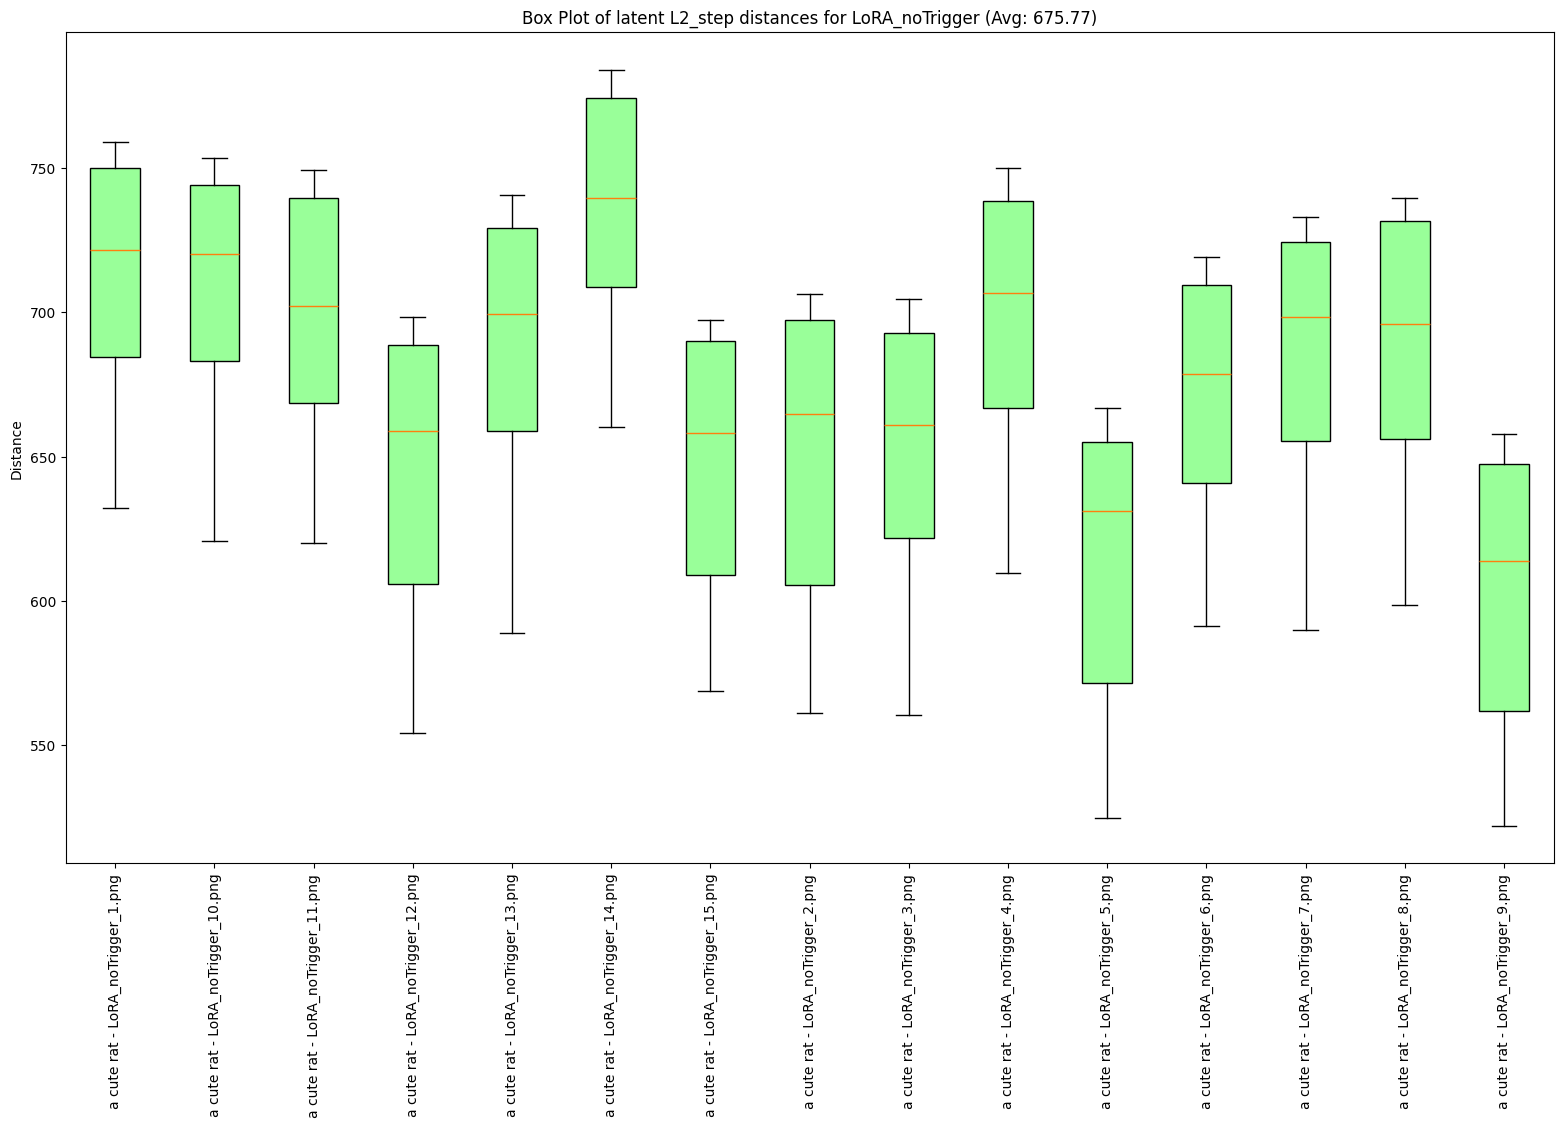

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


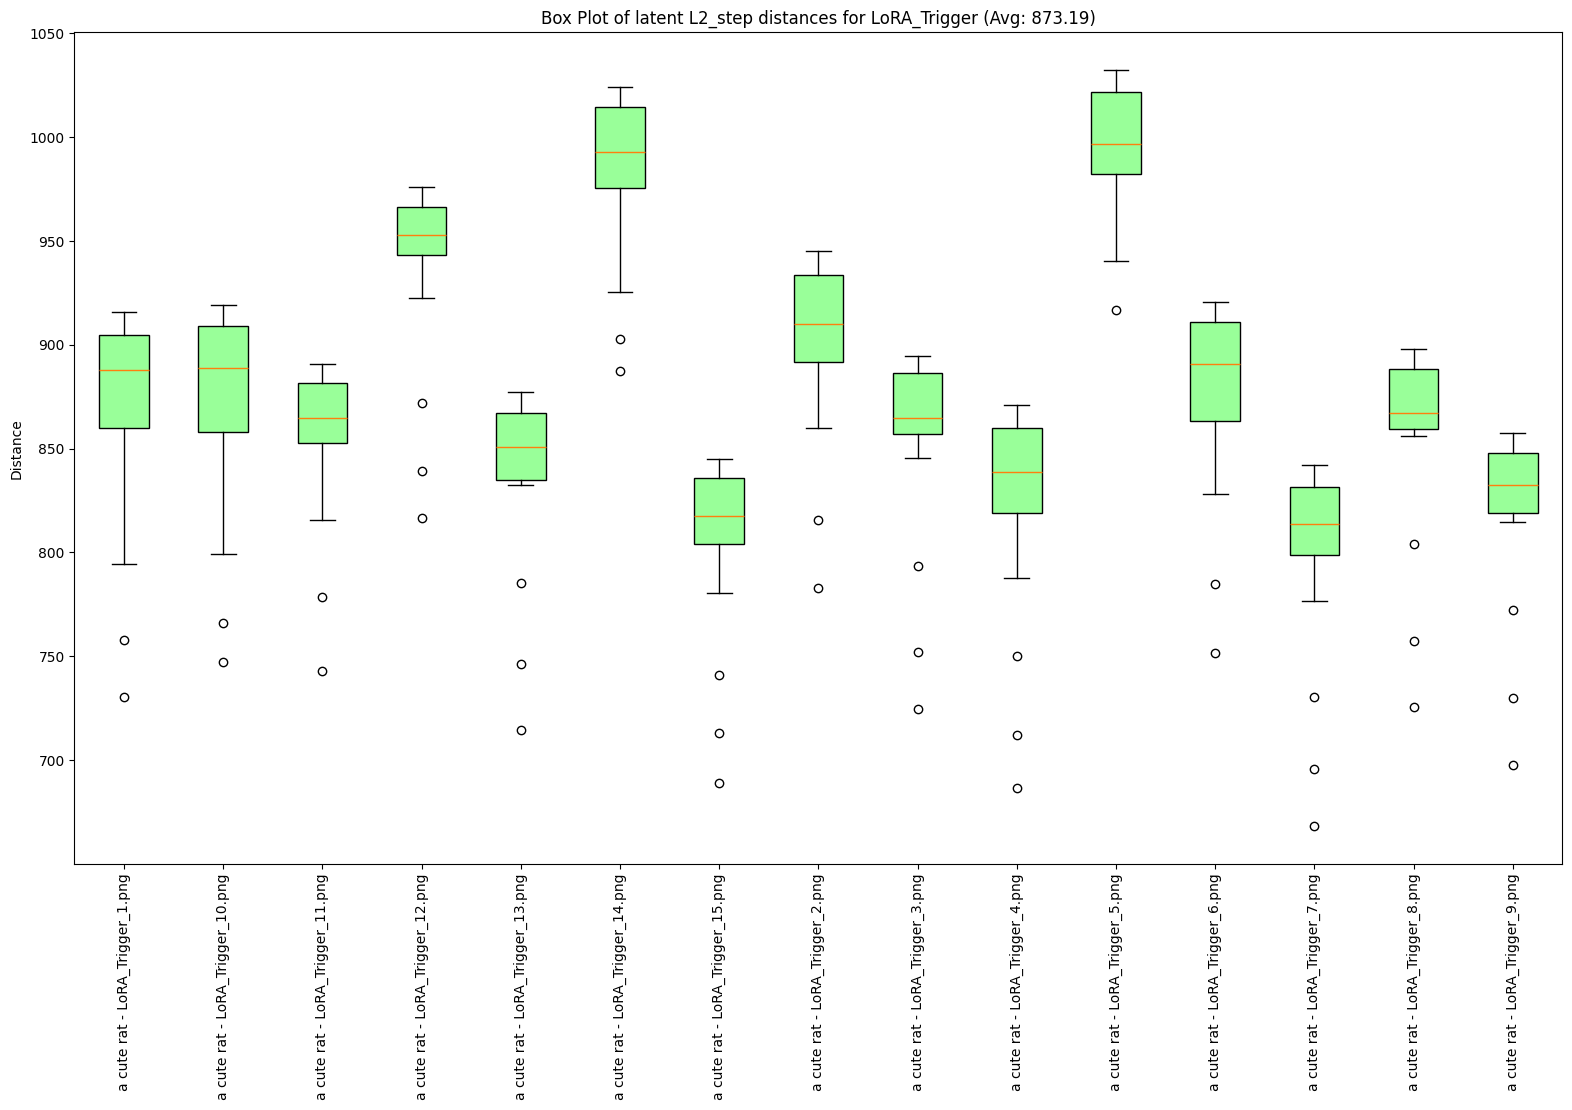

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


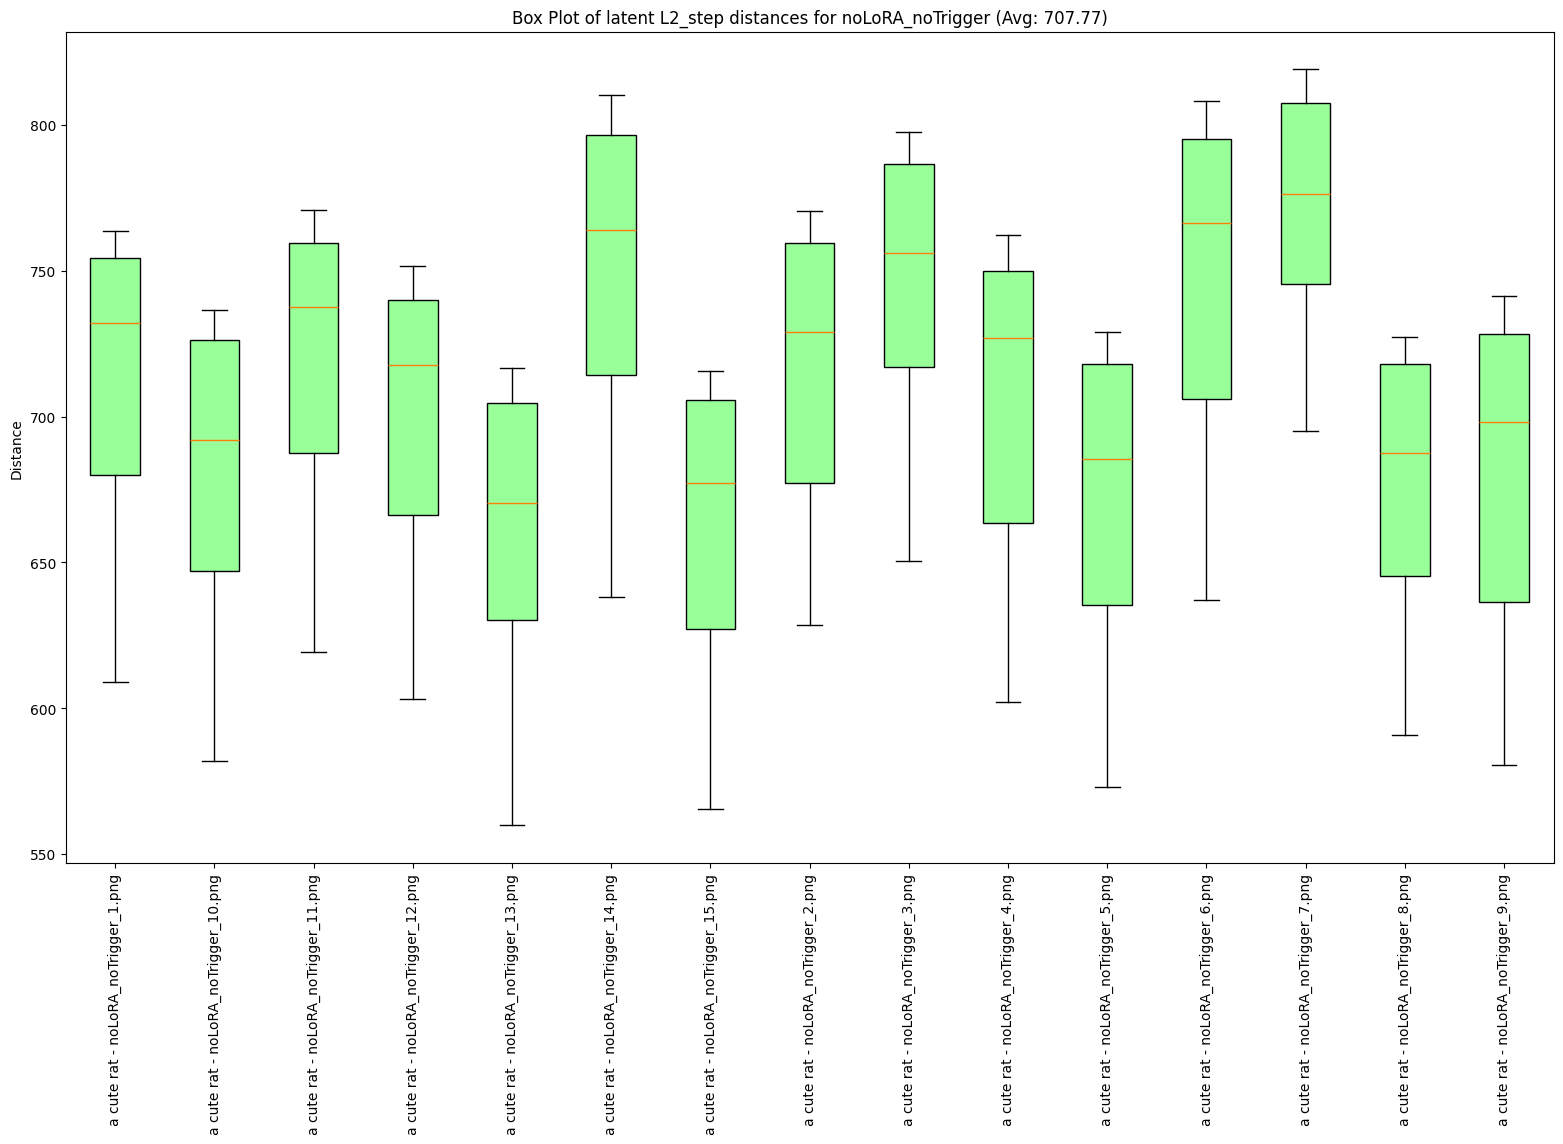

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


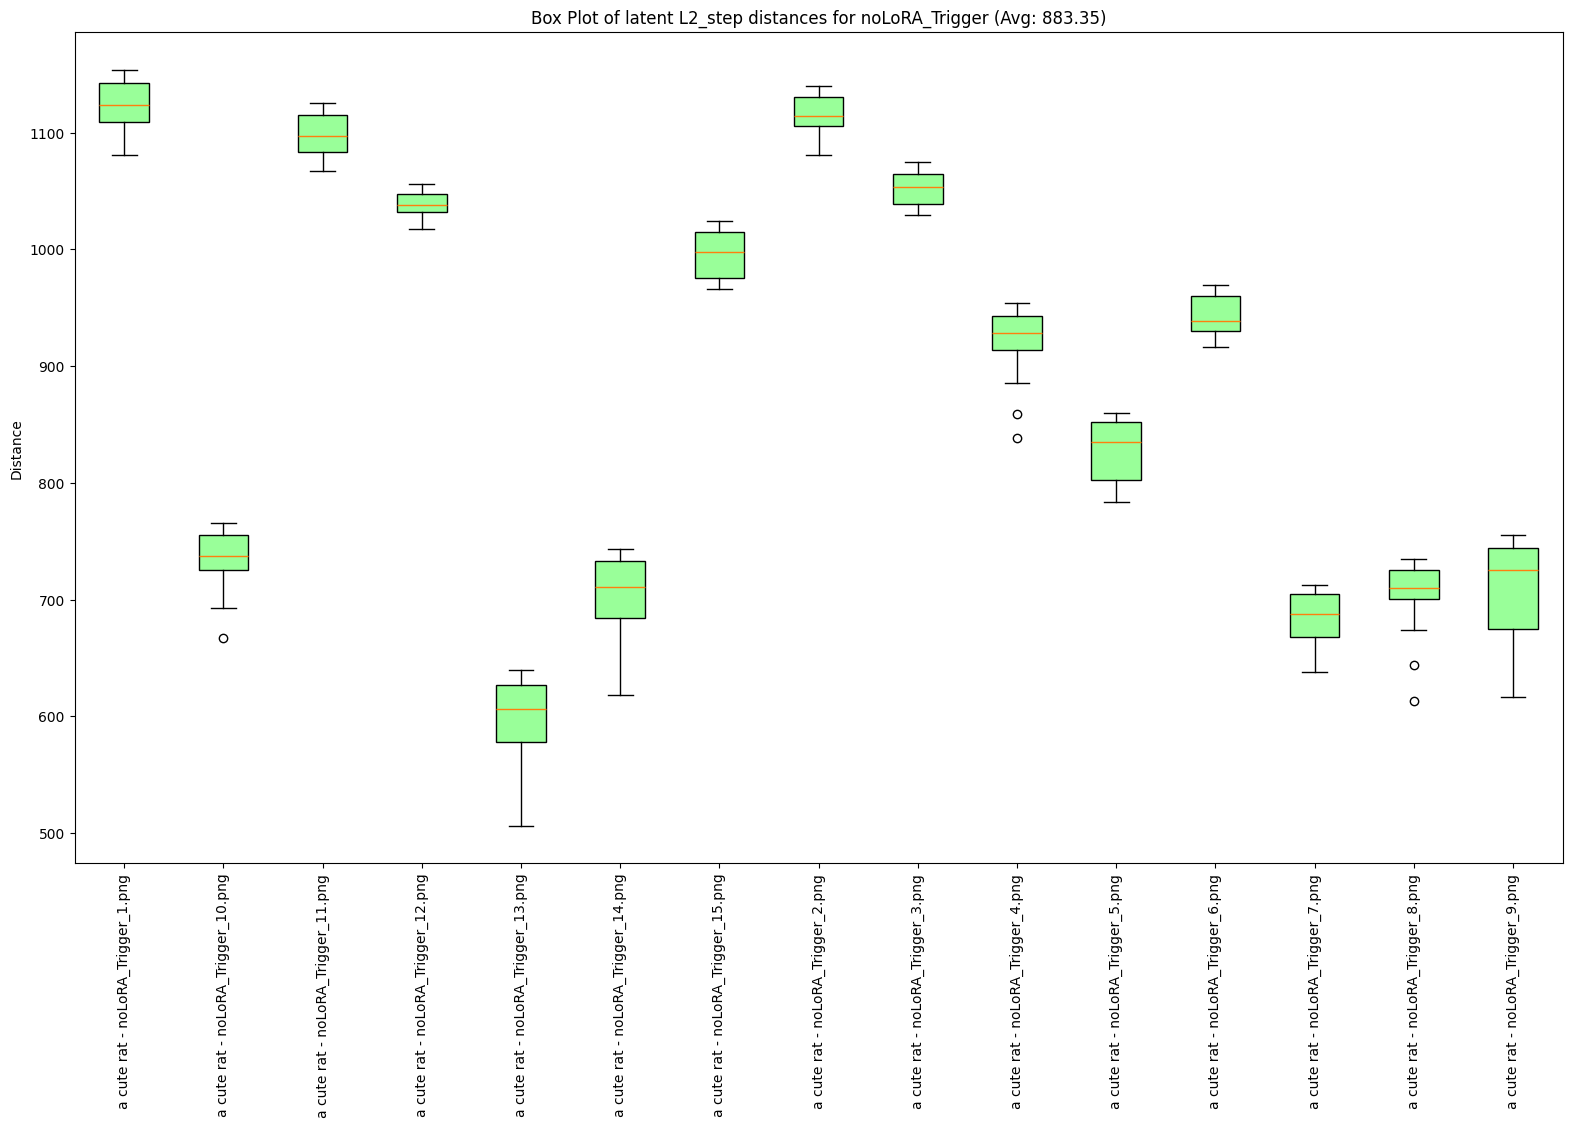

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


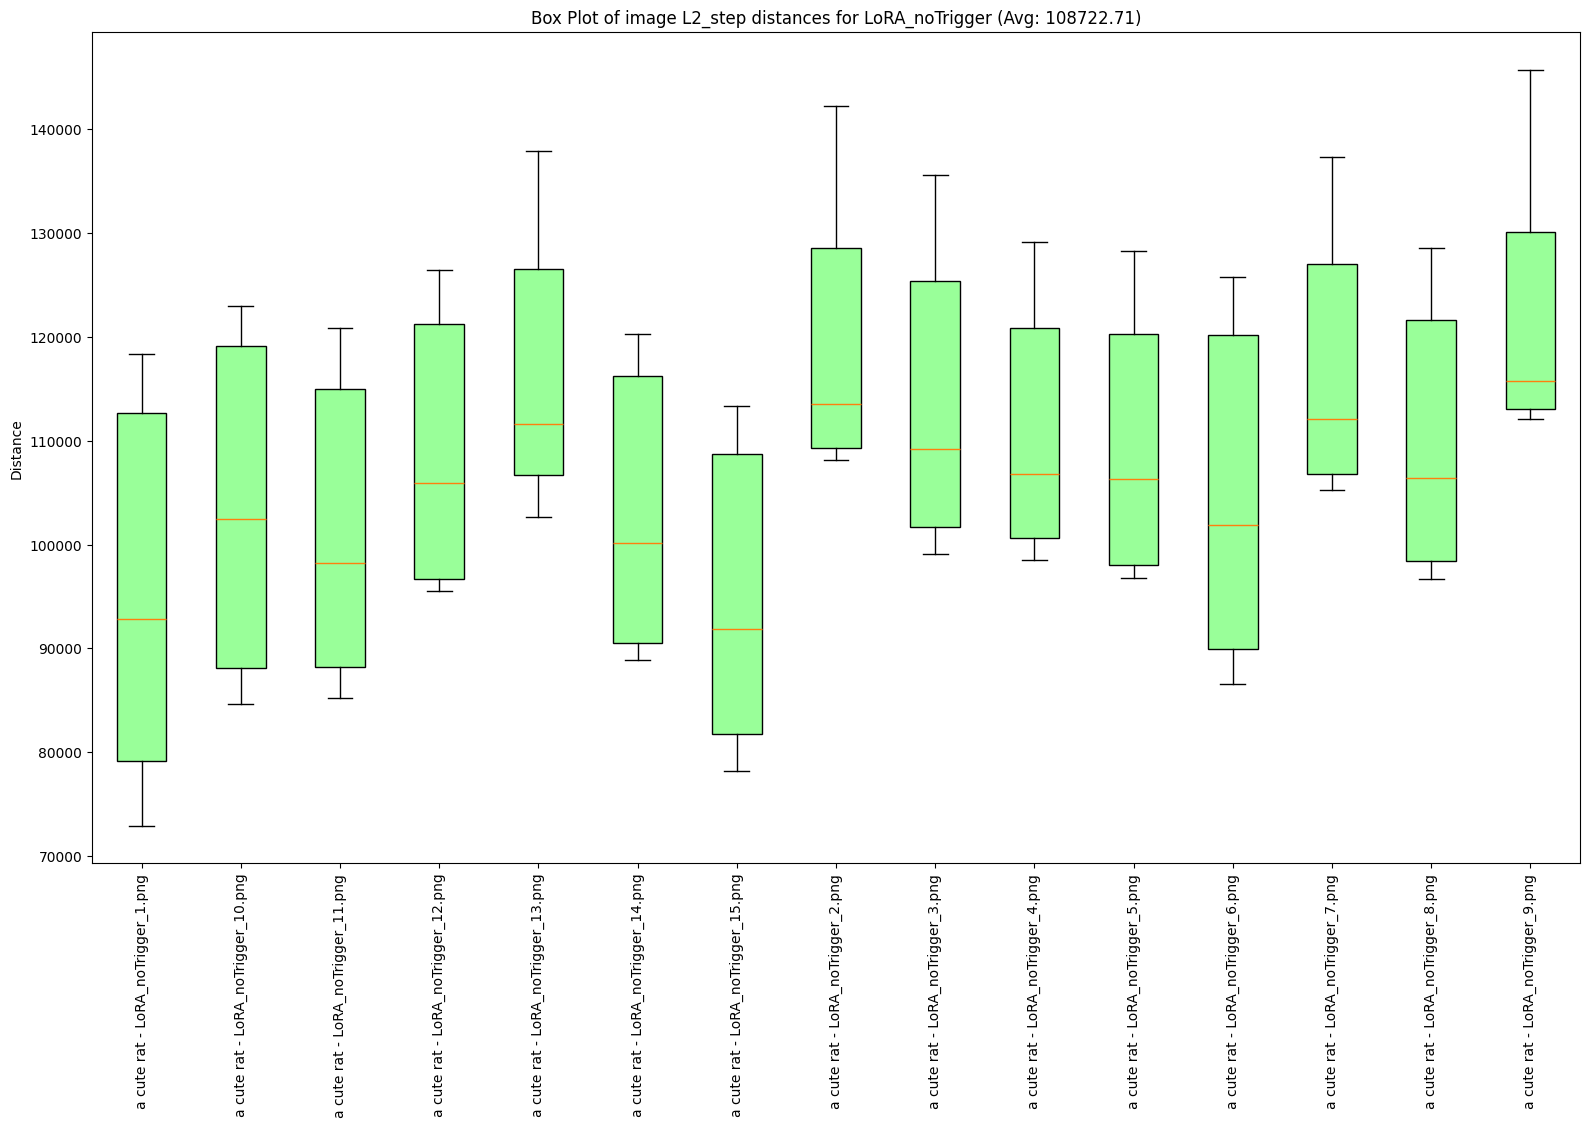

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


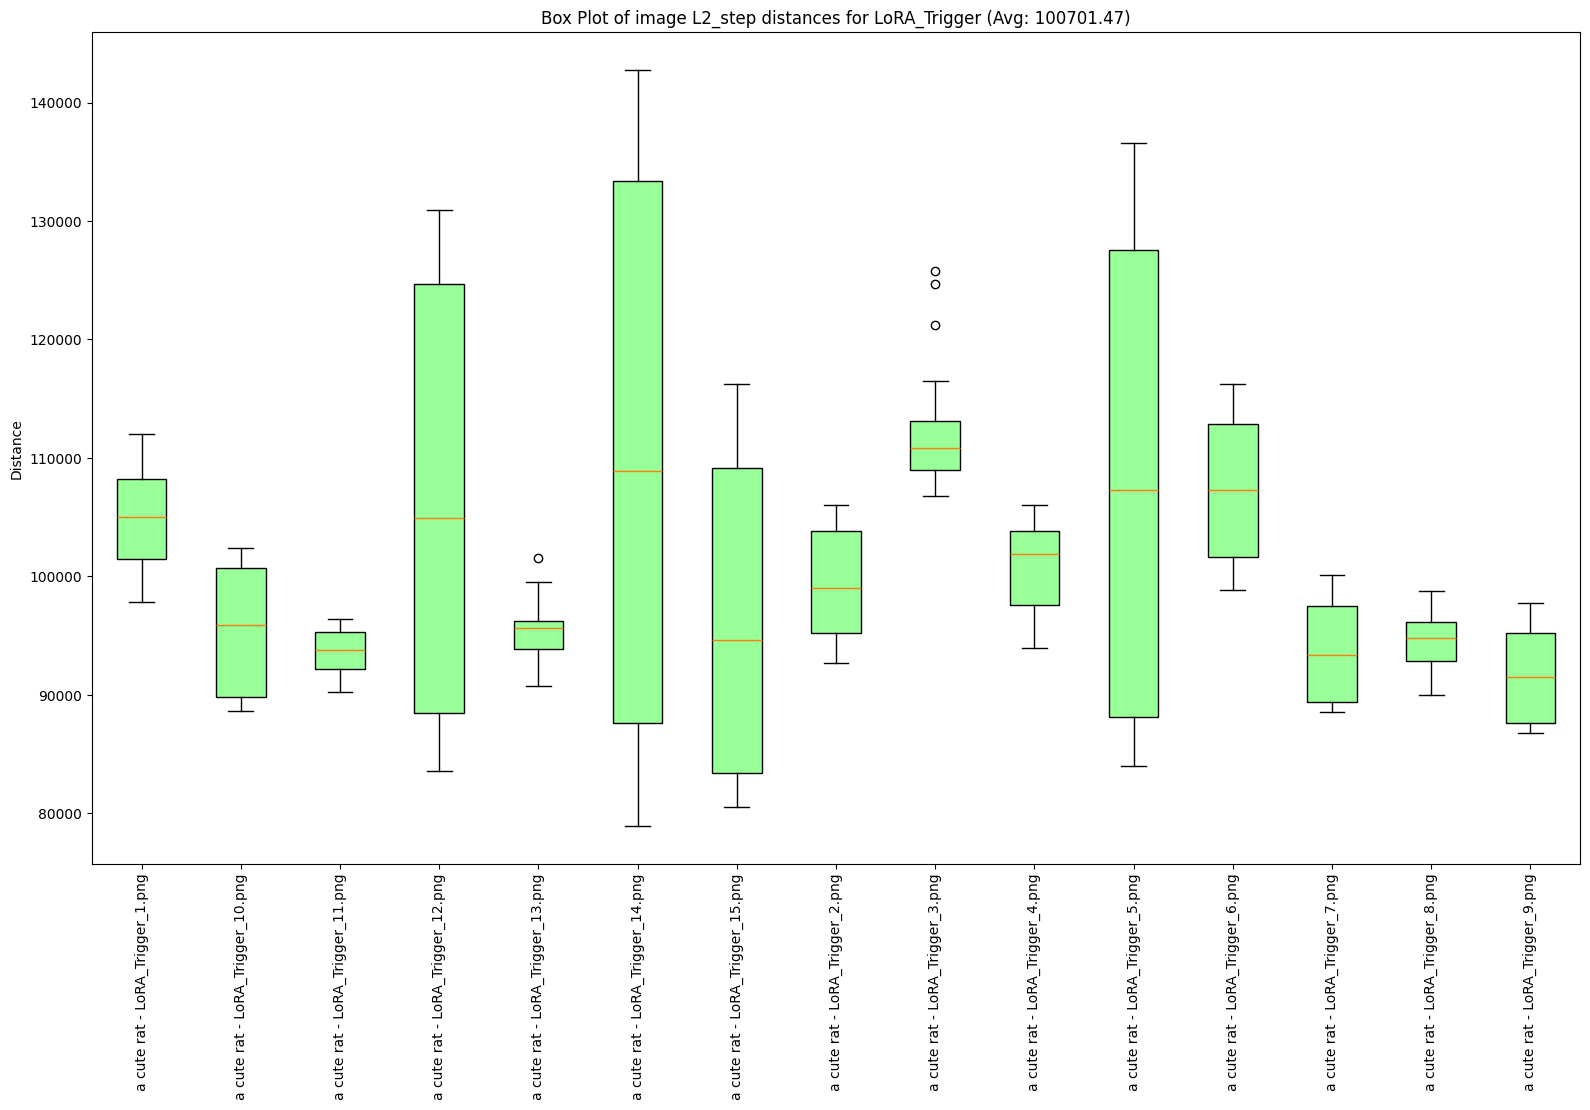

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


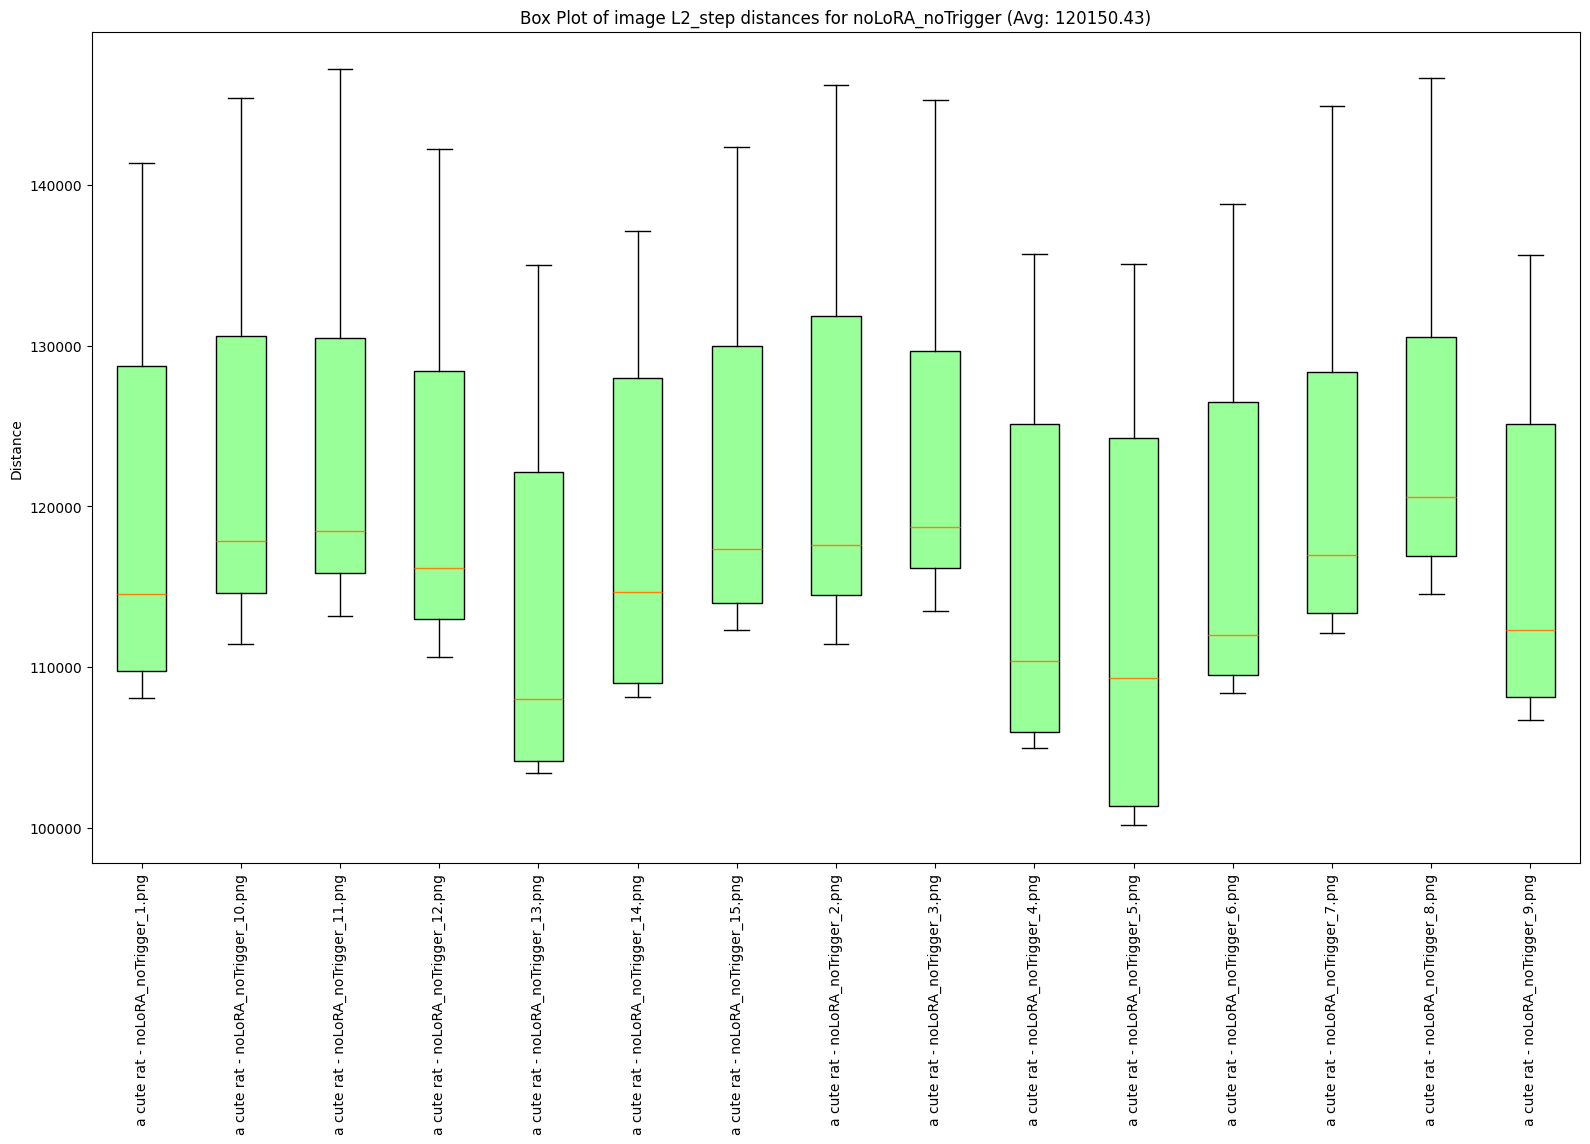

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


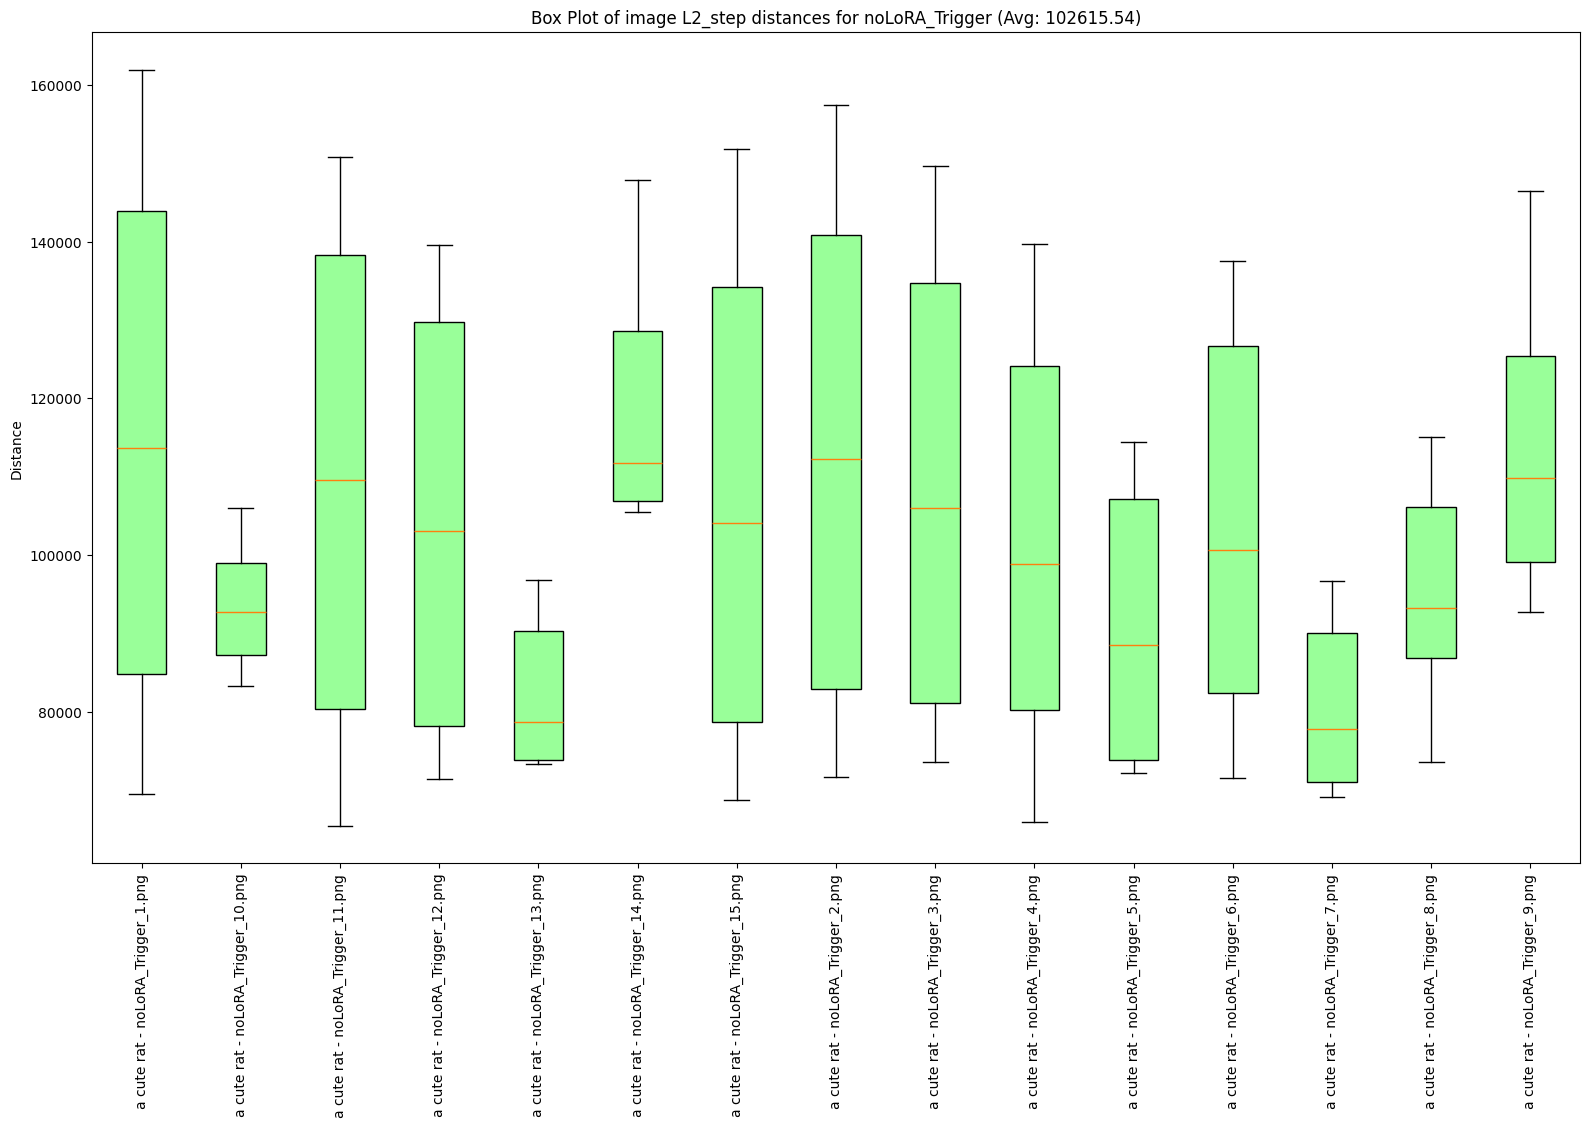

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


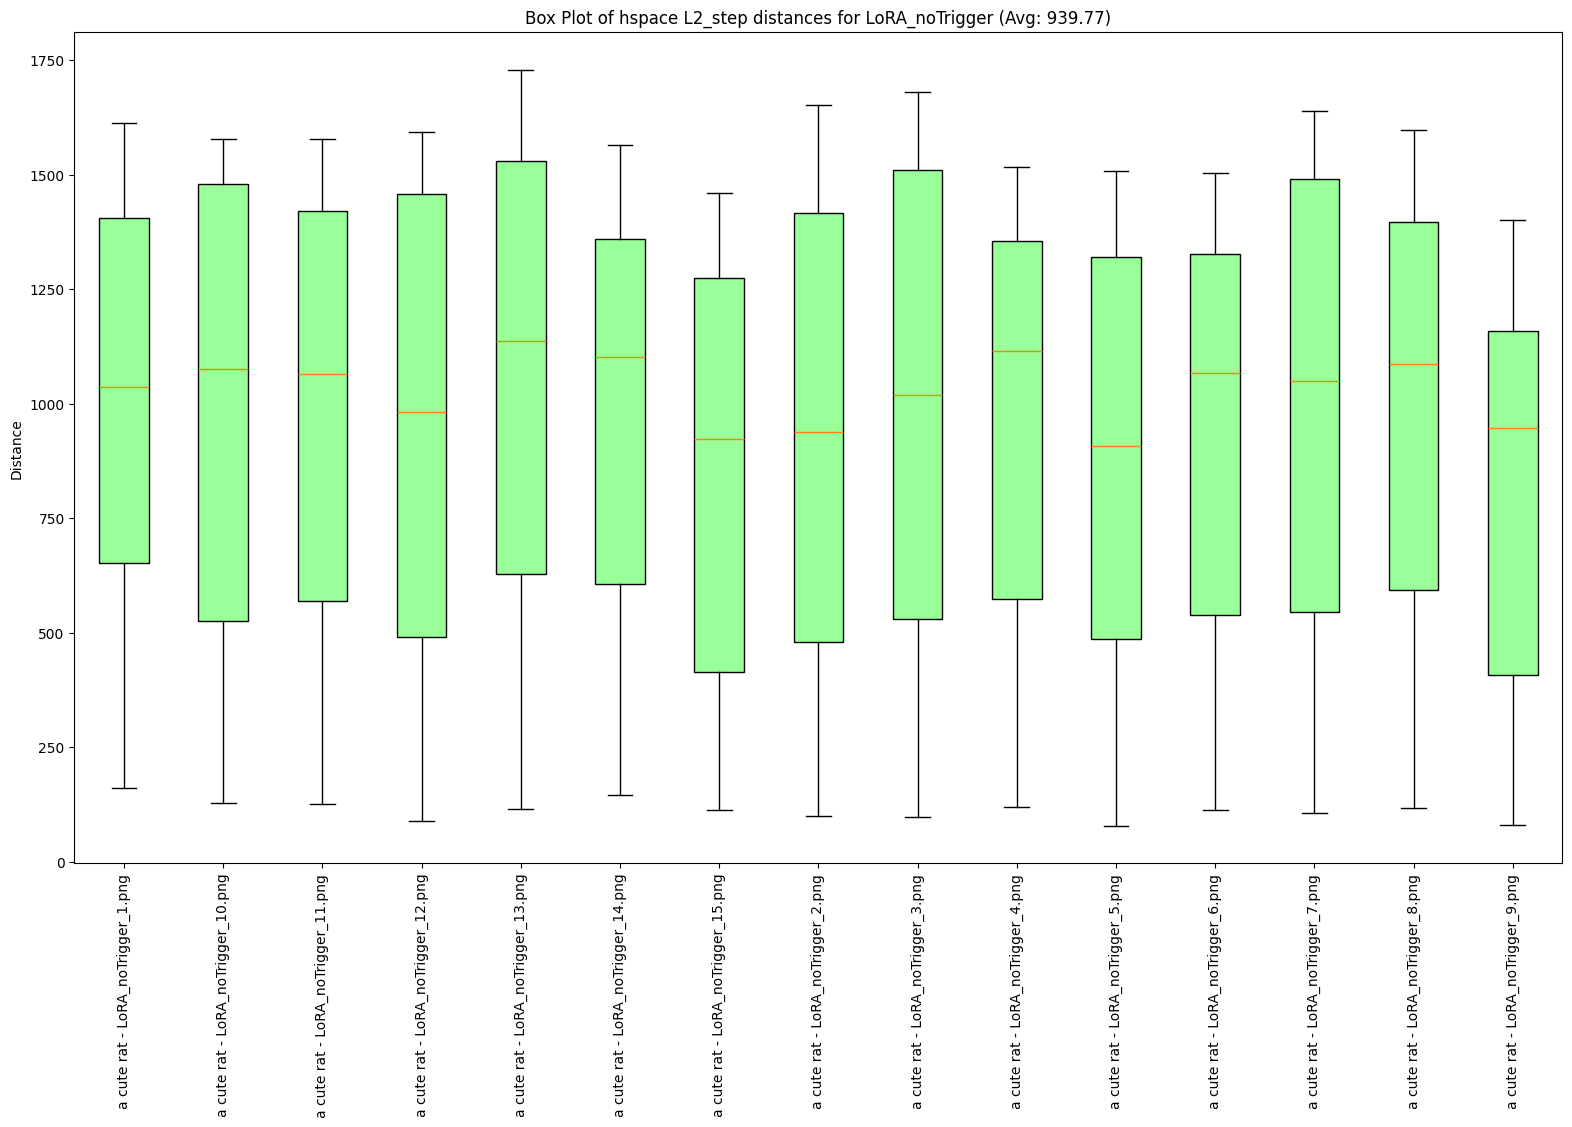

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


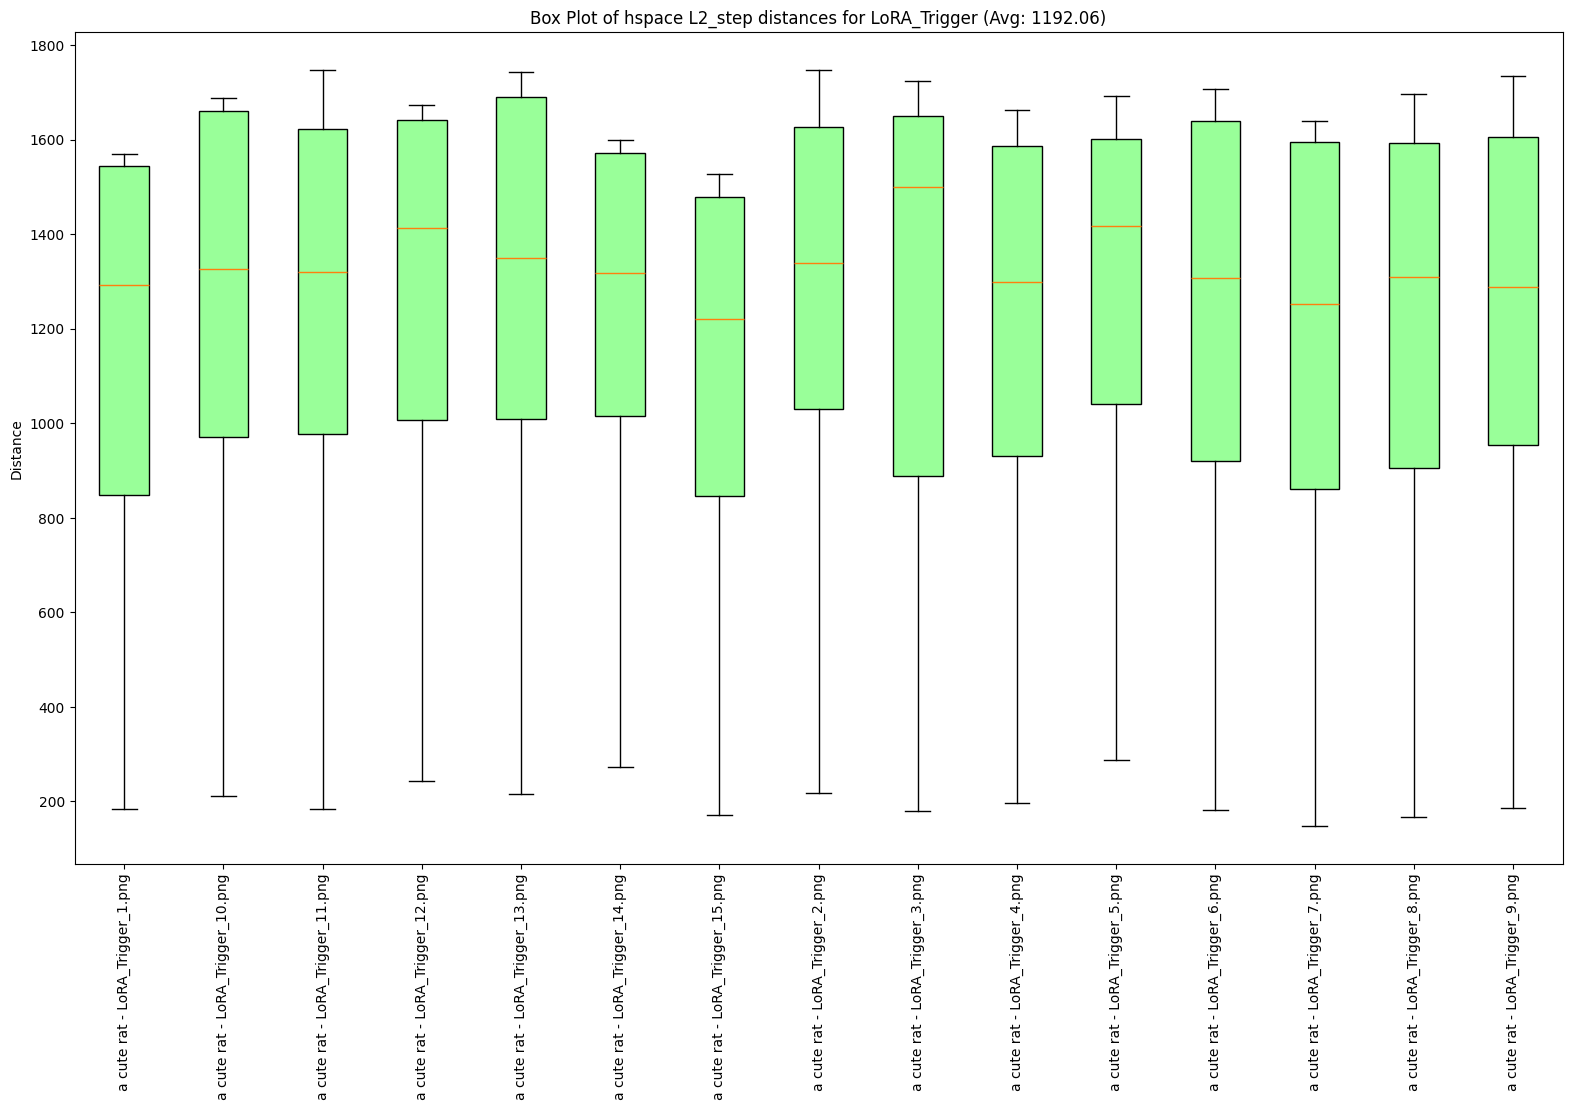

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


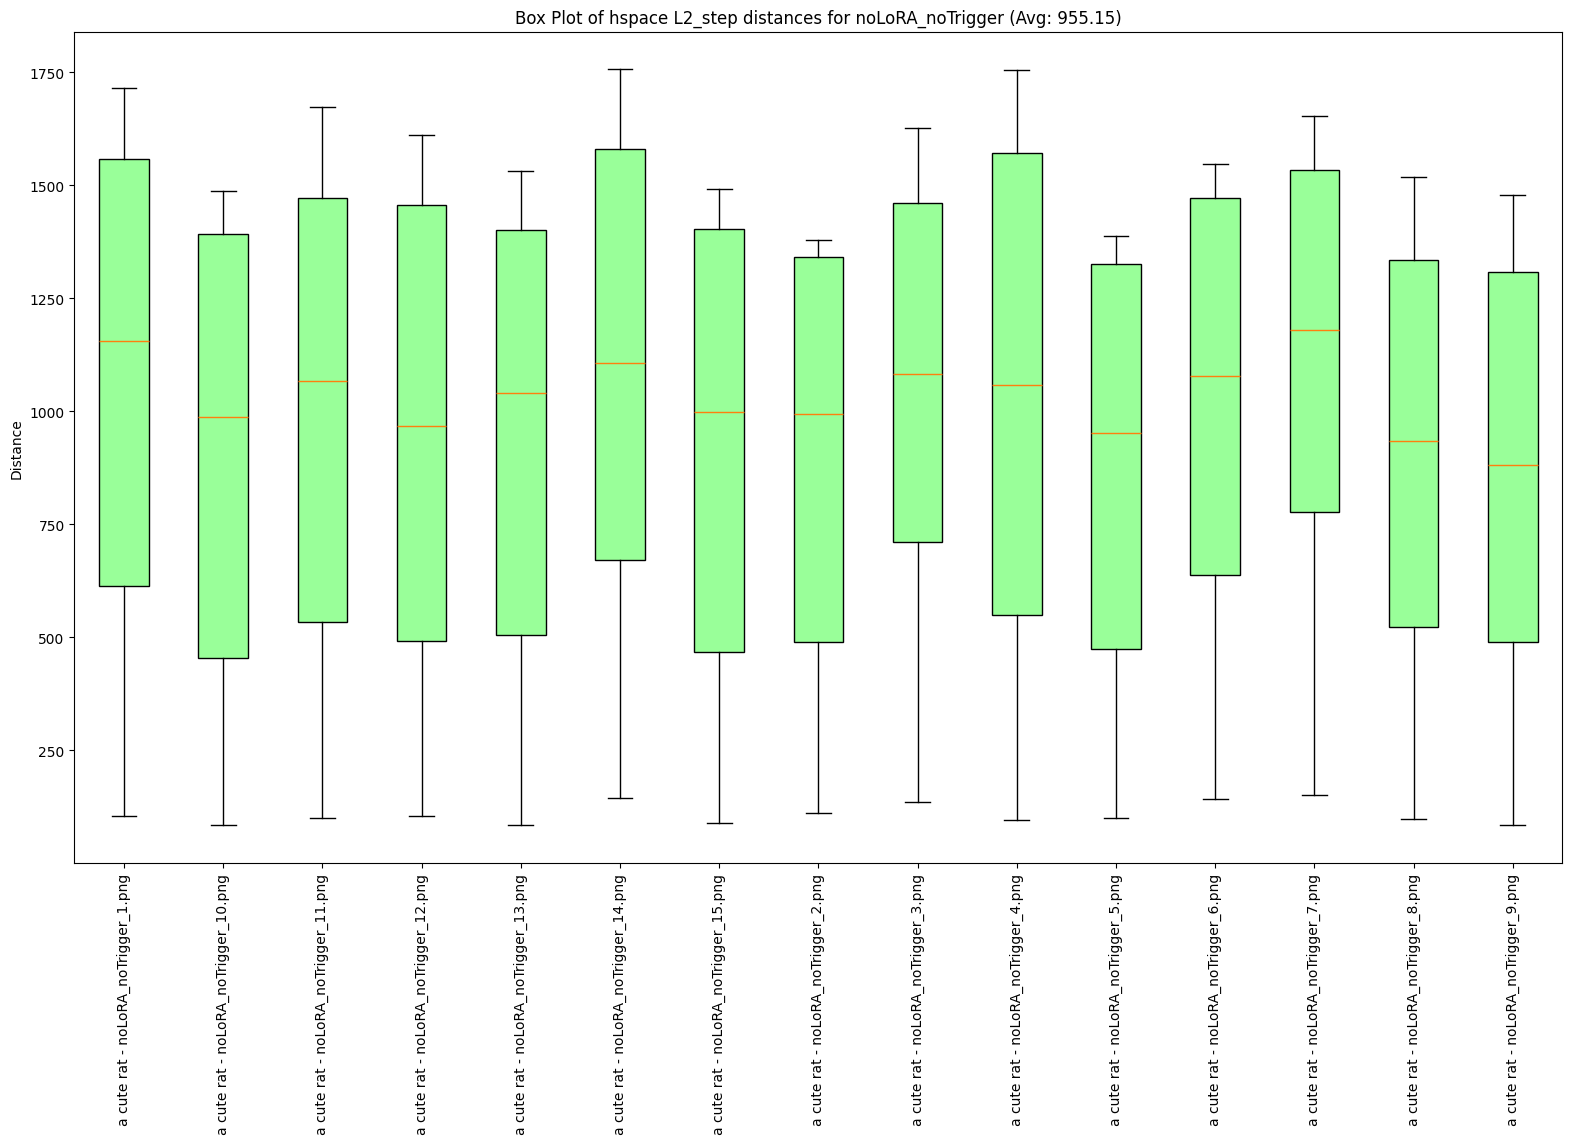

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


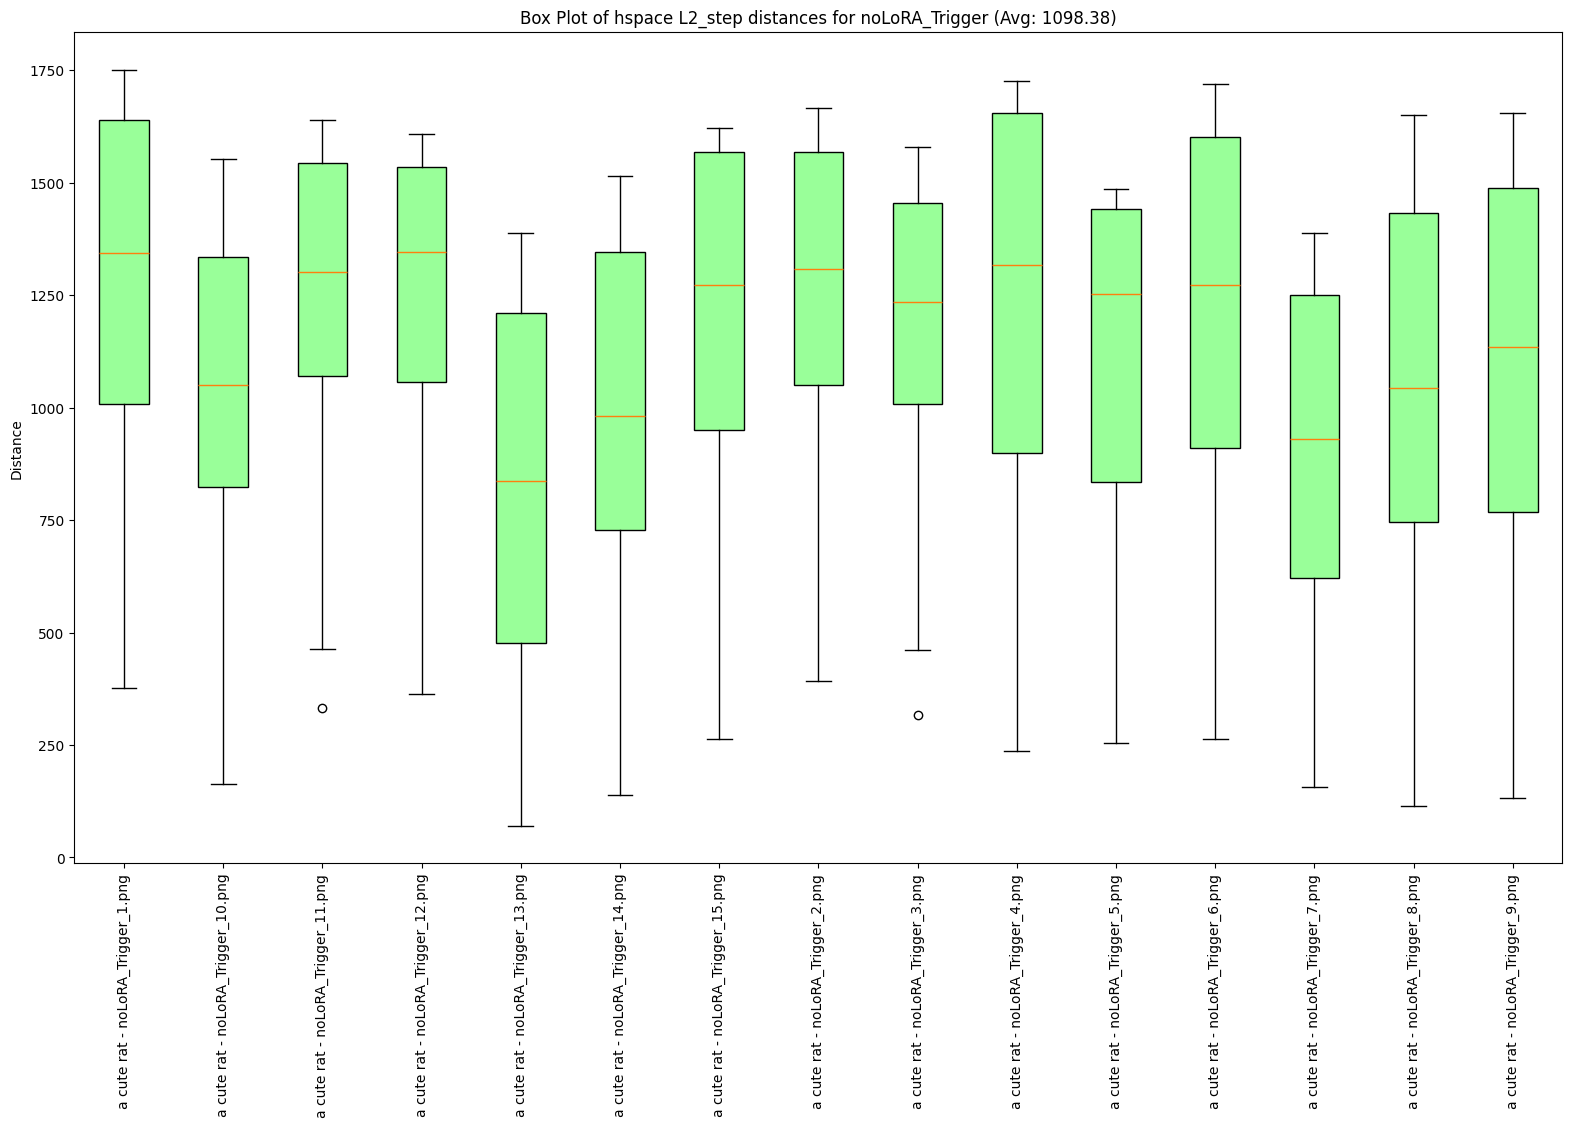

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_boxplot(anaysis_data, key, distance_type="L2_step"):
    color = {'L2_step': '#99FF99', 'frechet_step': '#99CCFF', 'L1_step': '#FF9999', 'cosine_similarity': '#55AAFF'}[distance_type]  # Define the colors
    for prefix in anaysis_data.keys():
        data_to_plot = []
        labels = []
        for prompt in anaysis_data[prefix].keys():
            for image_name in anaysis_data[prefix][prompt].keys():
                data = anaysis_data[prefix][prompt][image_name][key]
                data_to_plot.append(data)
                labels.append(f'{prompt} - {image_name}')
        
        plt.figure(figsize=(19.2, 10.8))
        box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)
        for patch in box['boxes']:
            patch.set_facecolor(color)
        
        avg_distance = np.mean([np.mean(data) for data in data_to_plot])
        plt.ylabel('Distance')
        plt.title(f'Box Plot of {key} {distance_type} distances for {prefix} (Avg: {avg_distance:.2f})')
        plt.xticks(rotation=90)
        plt.show()

plot_boxplot(anaysis_data["L2_step"], 'latent', "L2_step")
plot_boxplot(anaysis_data["L2_step"], 'image', "L2_step")
plot_boxplot(anaysis_data["L2_step"], 'hspace', "L2_step")

In [26]:
# do the same thing for frechet distance
def calculate_frechet_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = frechet_distance(experiment_data[prefix][prompt][image_name][key], experiment_data[prefix][prompt][first_image_name][key])
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
anaysis_data["frechet_step"] = calculate_frechet_distance(experiment_data)


LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png


In [27]:
# do the same thing for L1 distance
def calculate_L1_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = np.sum(np.abs(experiment_data[prefix][prompt][image_name][key] - experiment_data[prefix][prompt][first_image_name][key]))
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
anaysis_data["L1_step"] = calculate_L1_distance(experiment_data)

LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png


In [28]:
# calculate the cosine similarity between each image and the first image
def calculate_cosine_similarity(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(len(experiment_data[prefix][prompt][image_name][key])):
                        distance = np.dot(experiment_data[prefix][prompt][image_name][key][i].flatten(), experiment_data[prefix][prompt][first_image_name][key][i].flatten()) / (np.linalg.norm(experiment_data[prefix][prompt][image_name][key][i].flatten()) * np.linalg.norm(experiment_data[prefix][prompt][first_image_name][key][i].flatten()))
                        anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

anaysis_data["cosine_similarity"] = calculate_cosine_similarity(experiment_data)

LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png


C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


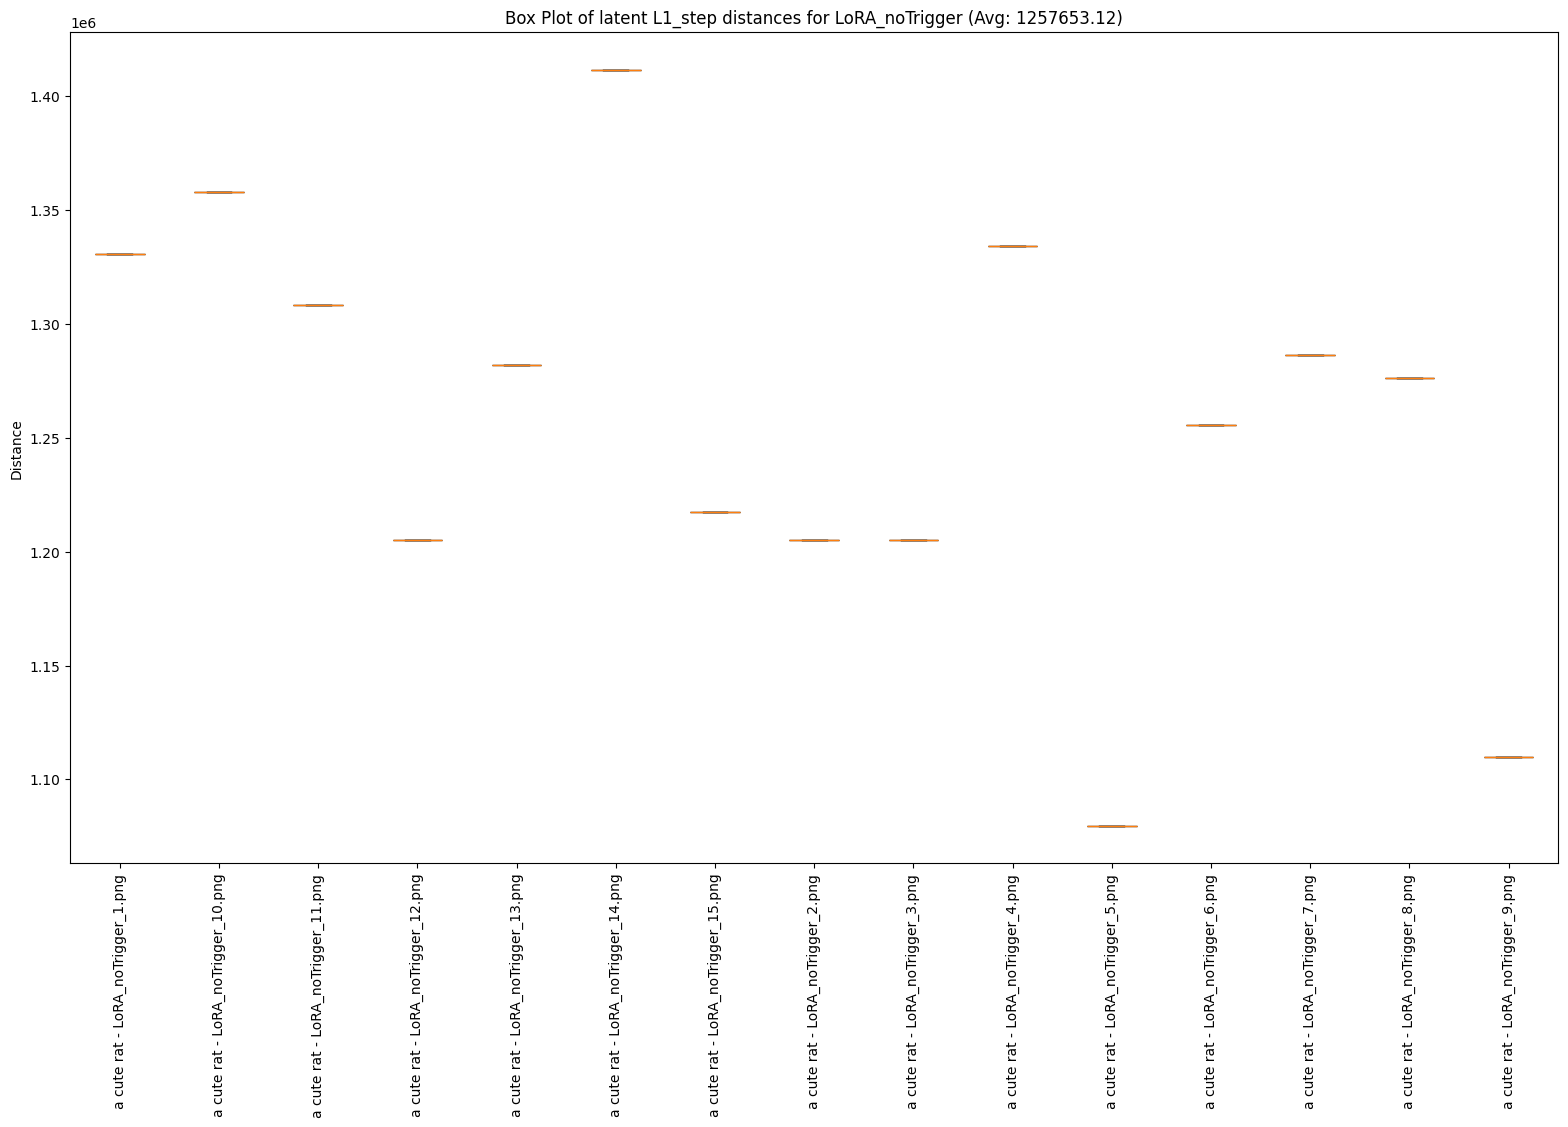

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


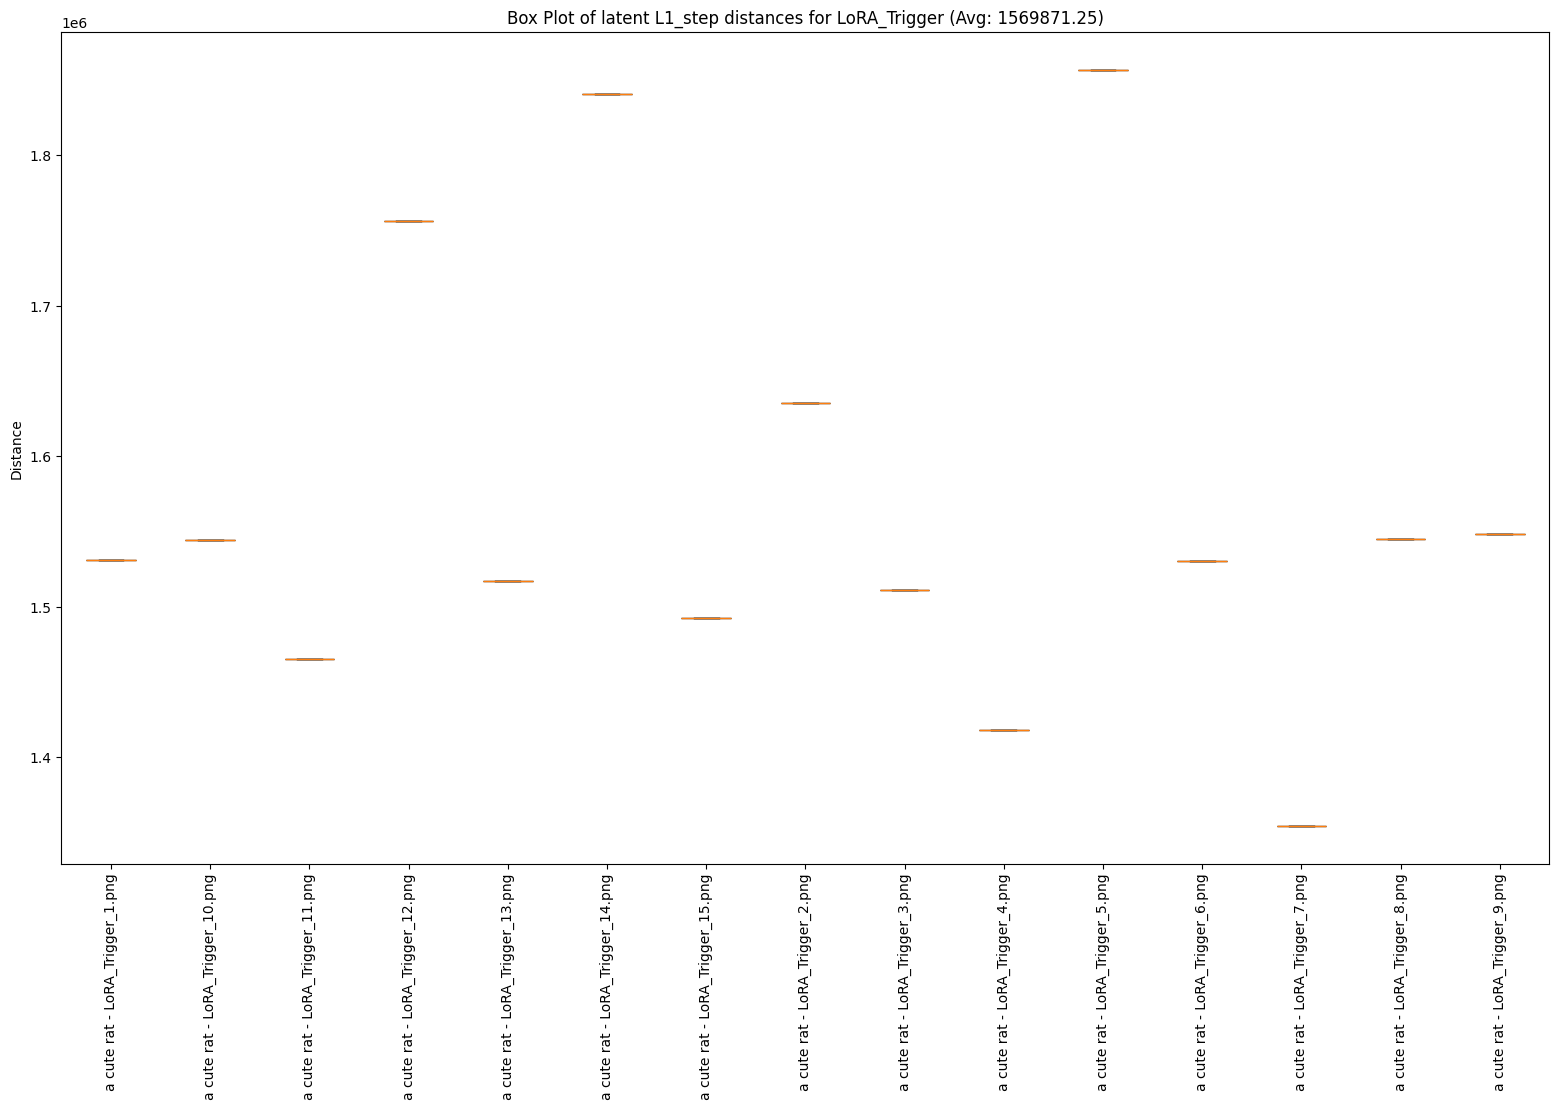

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


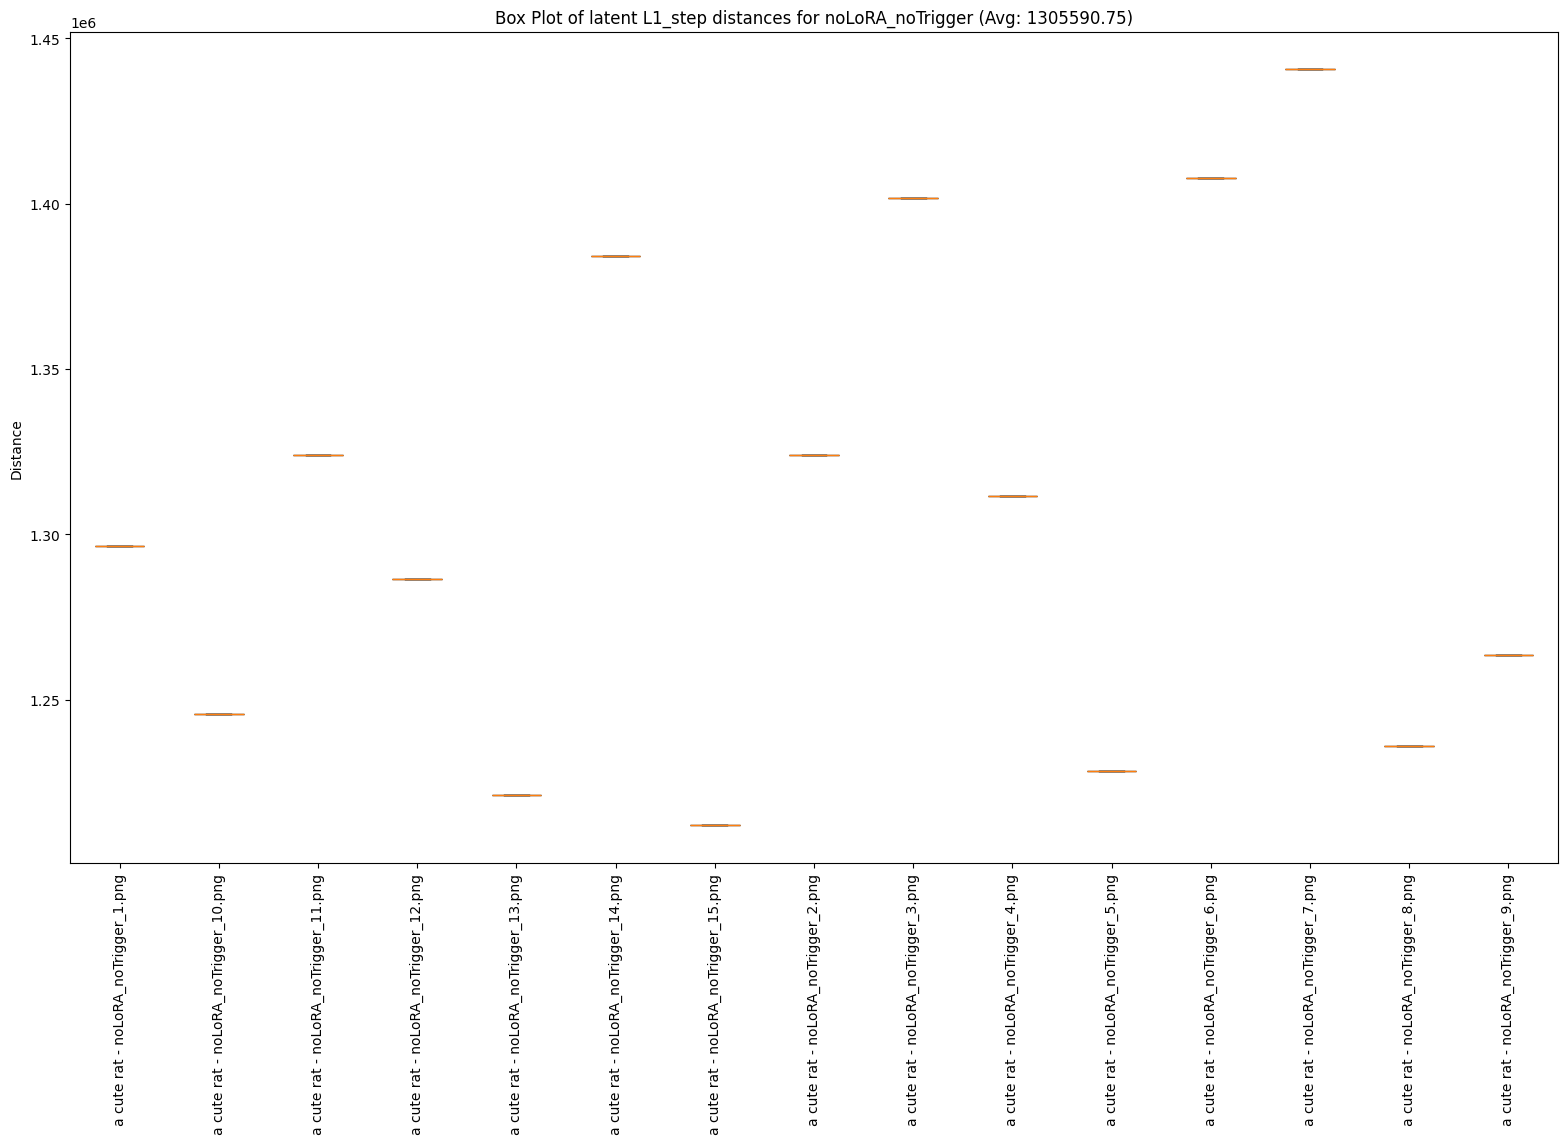

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


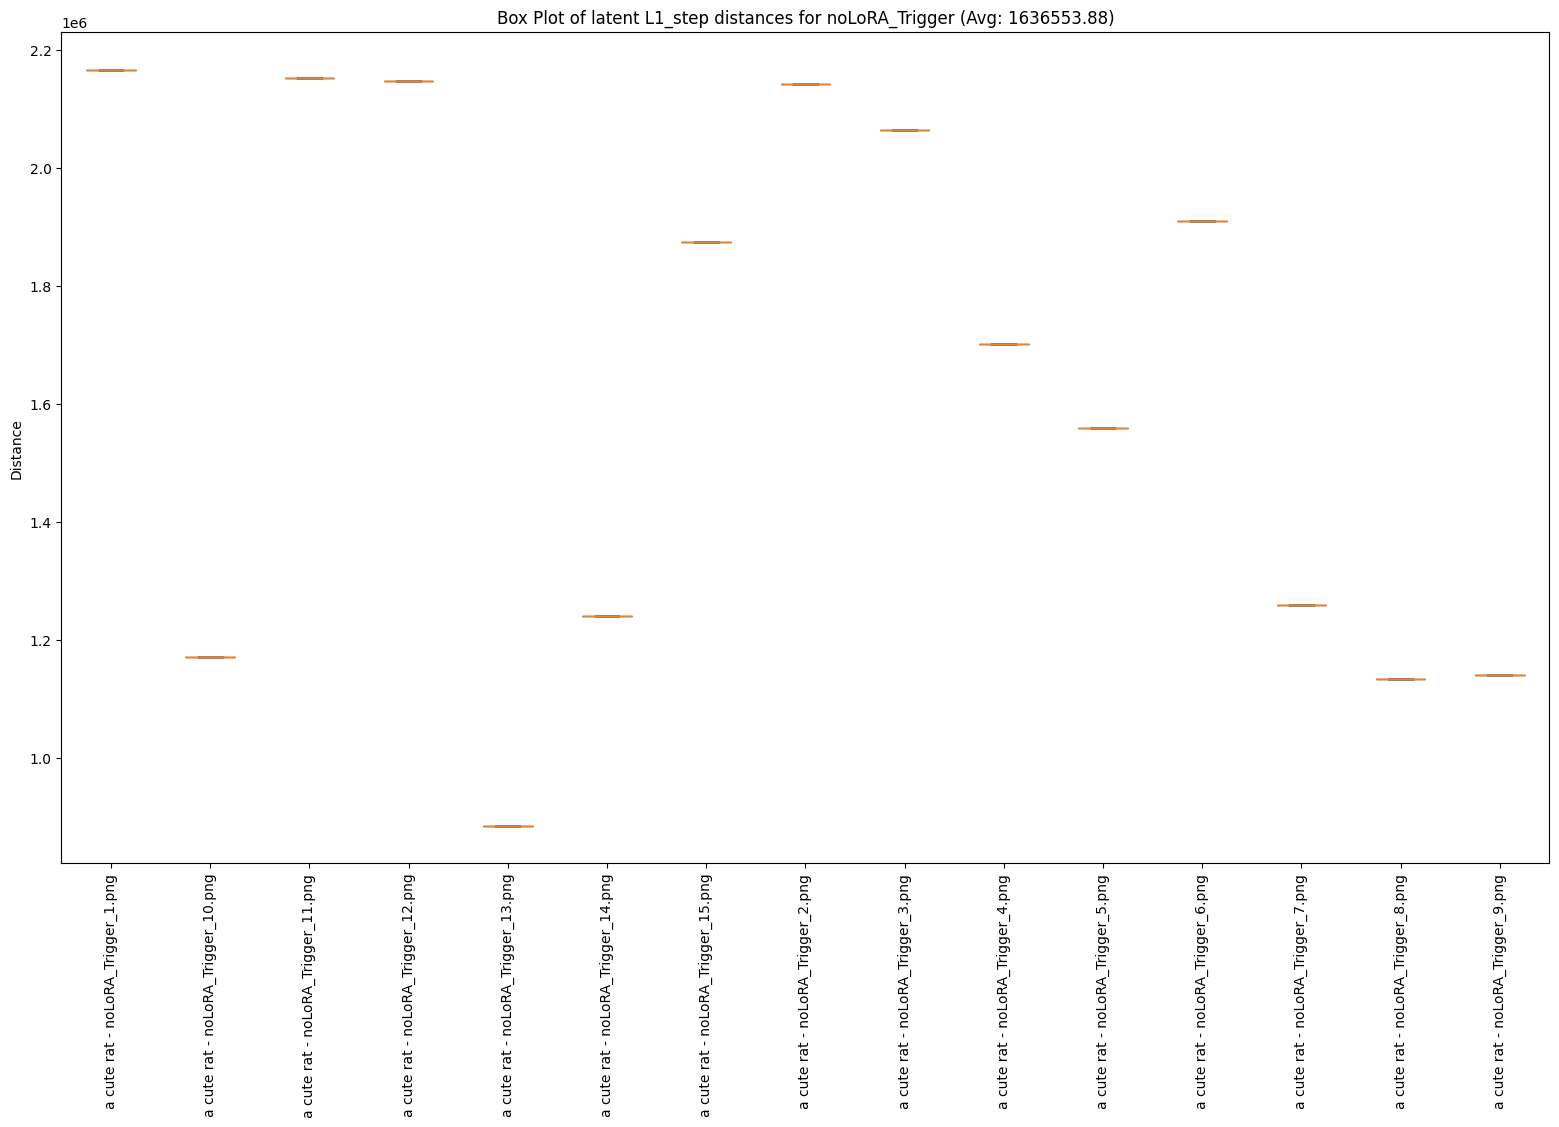

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


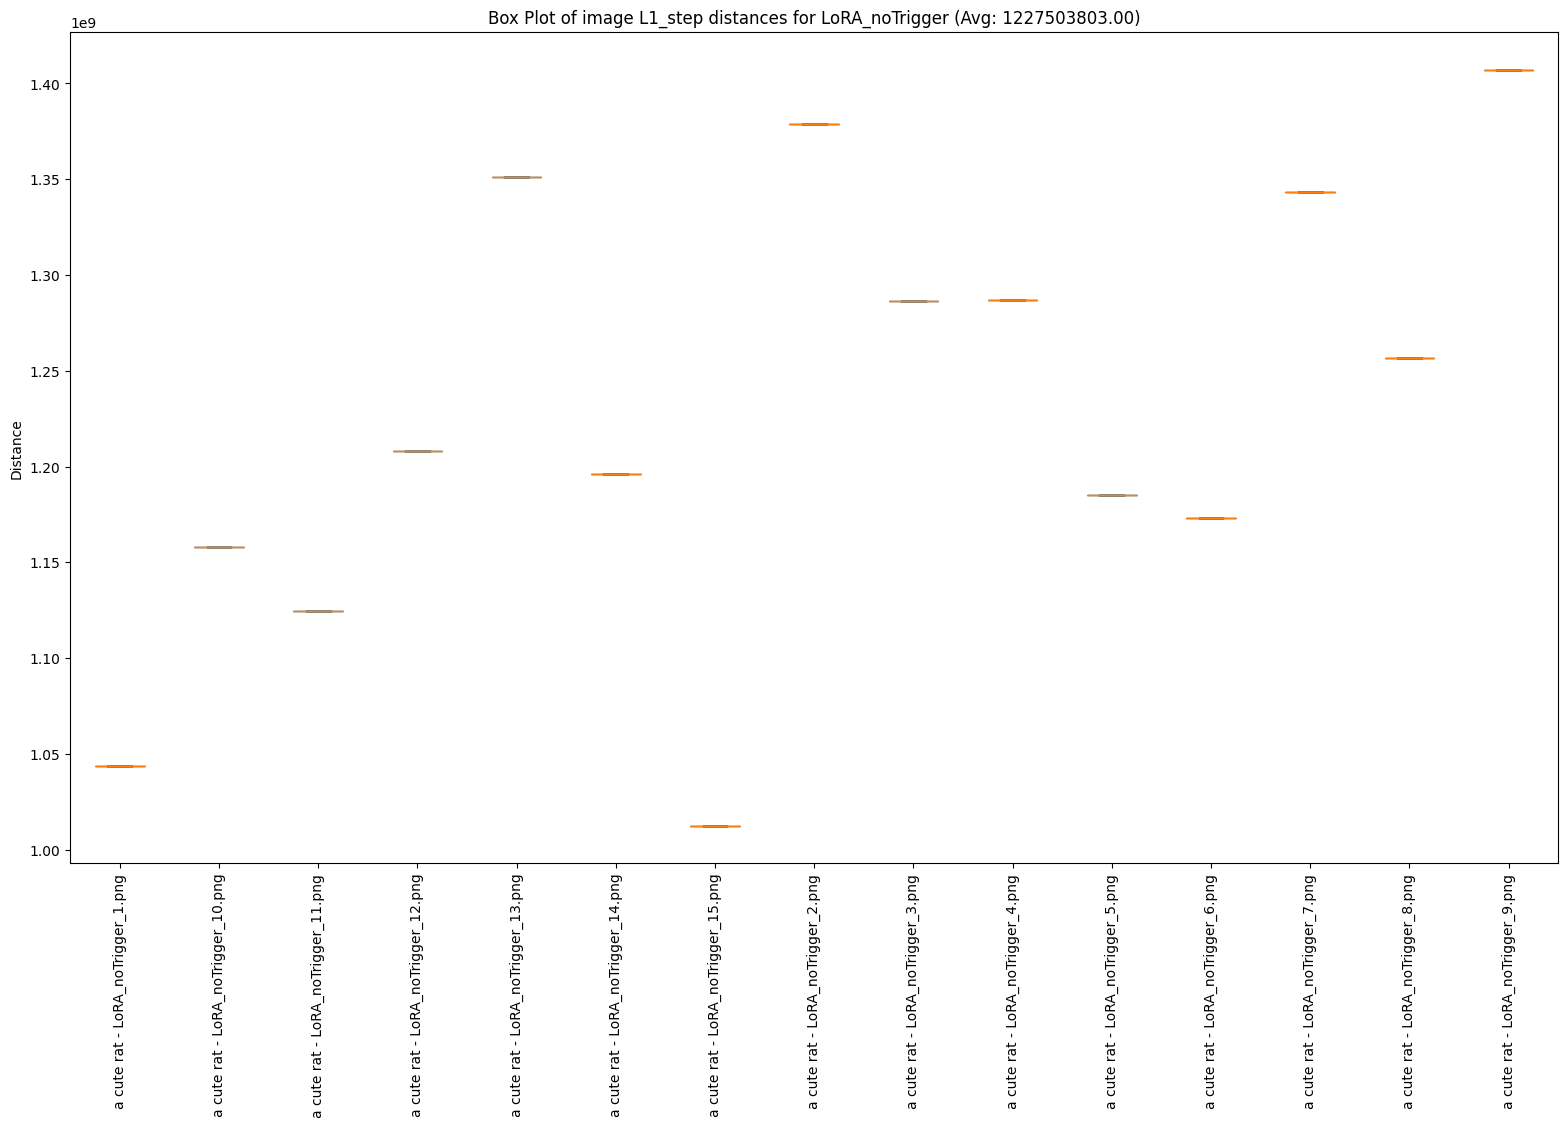

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


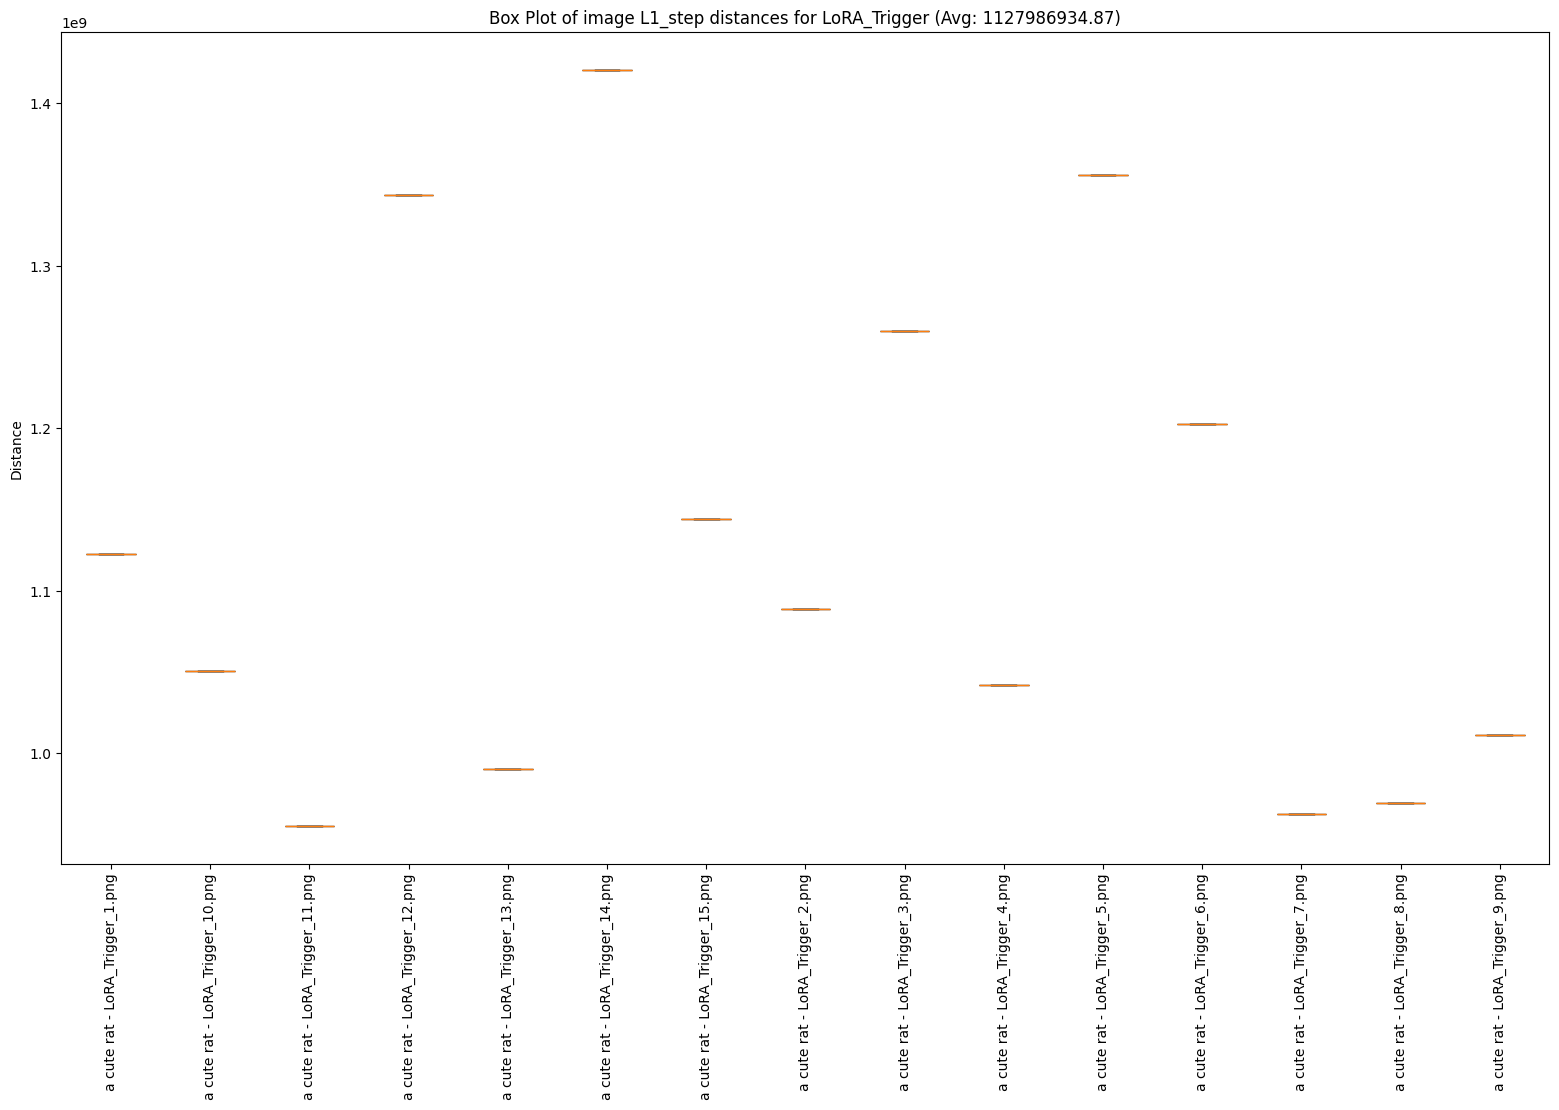

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


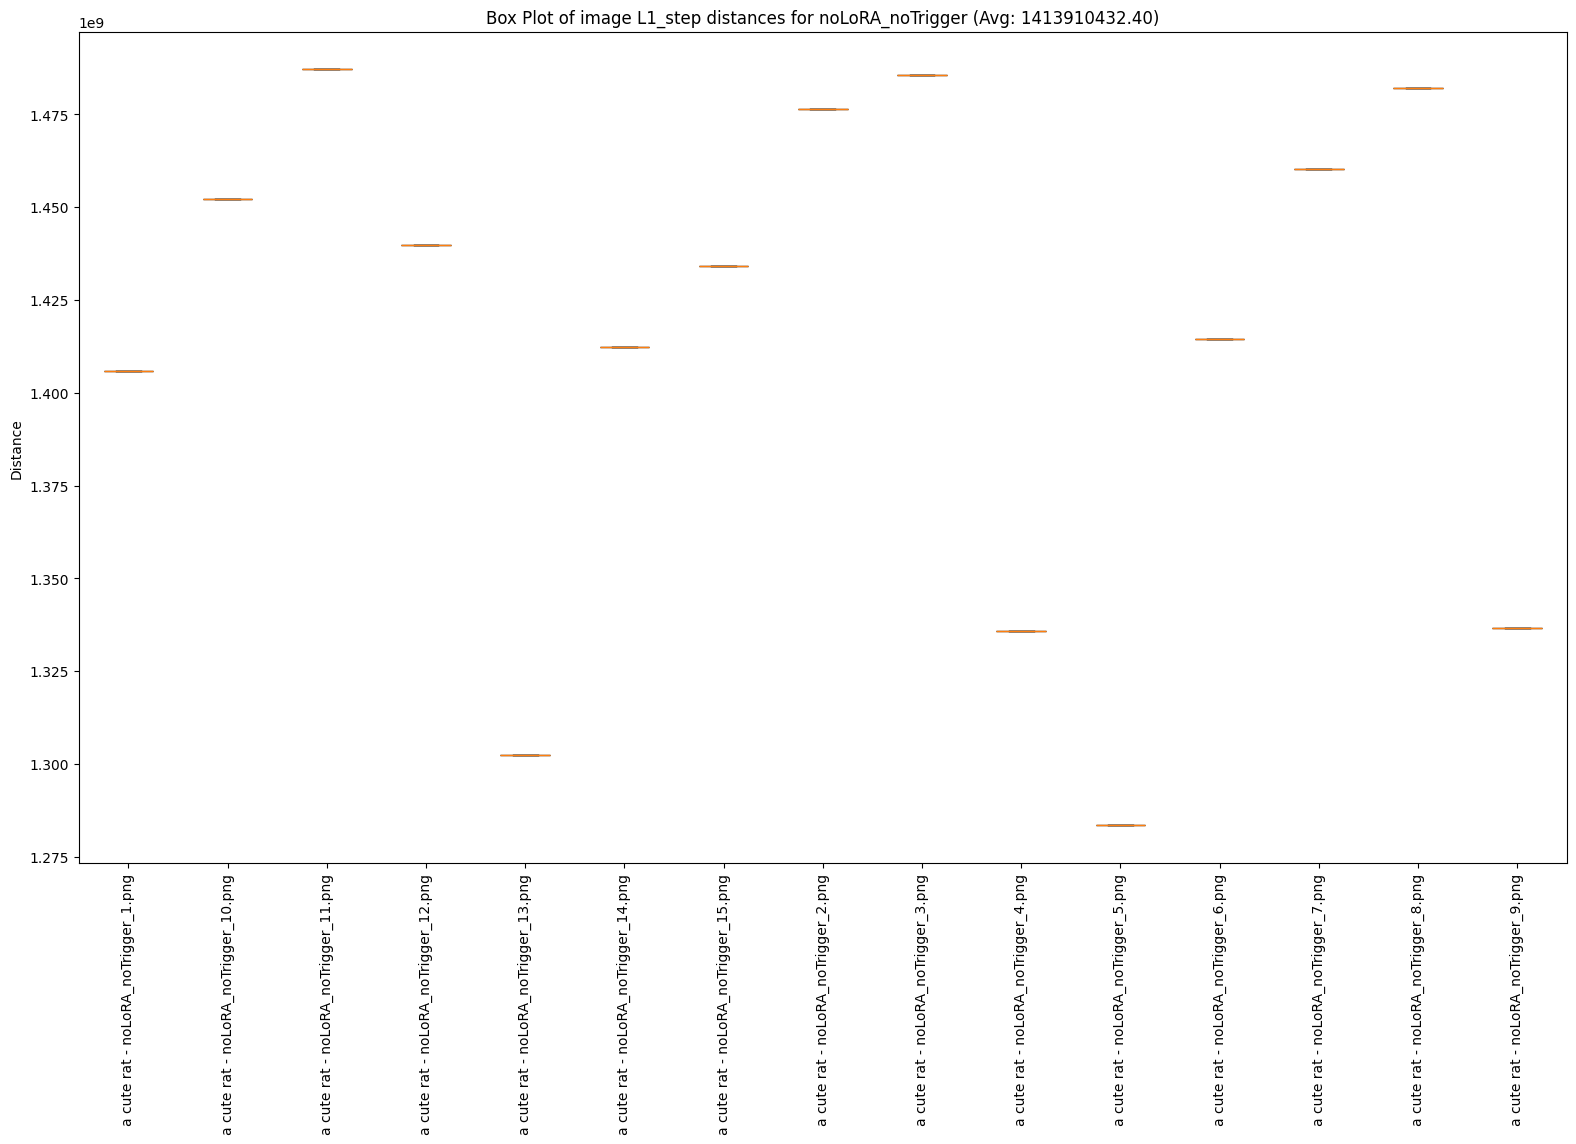

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


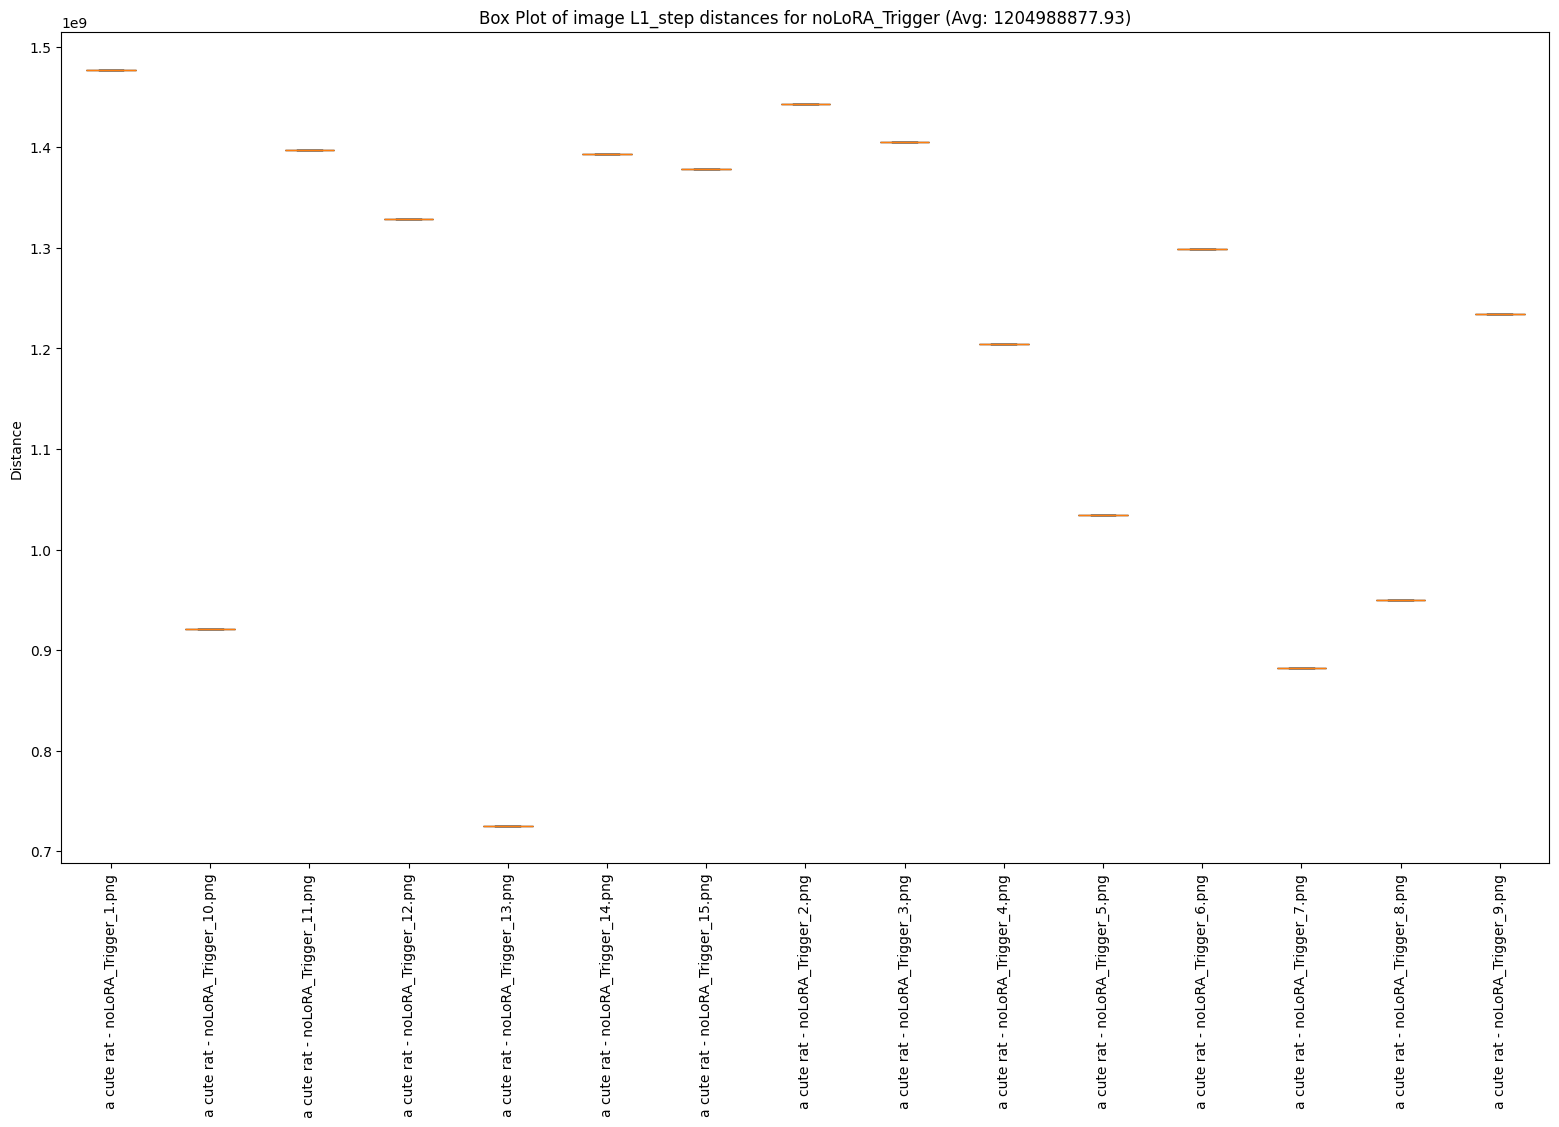

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


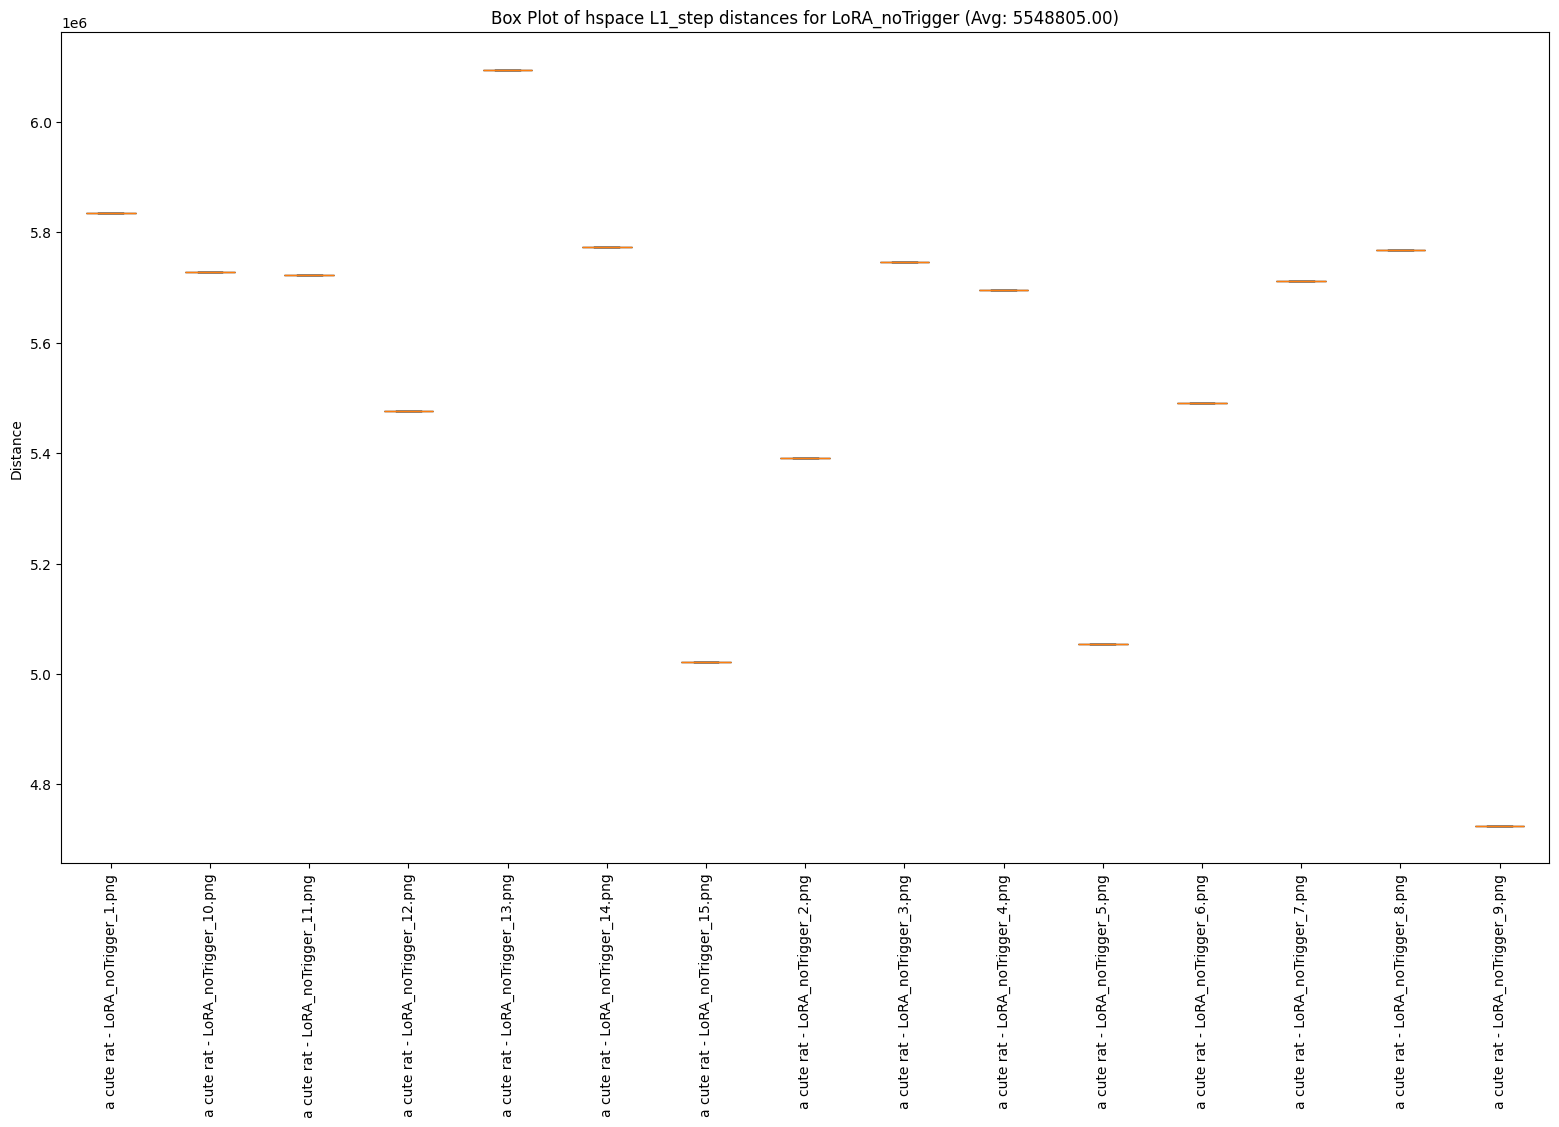

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


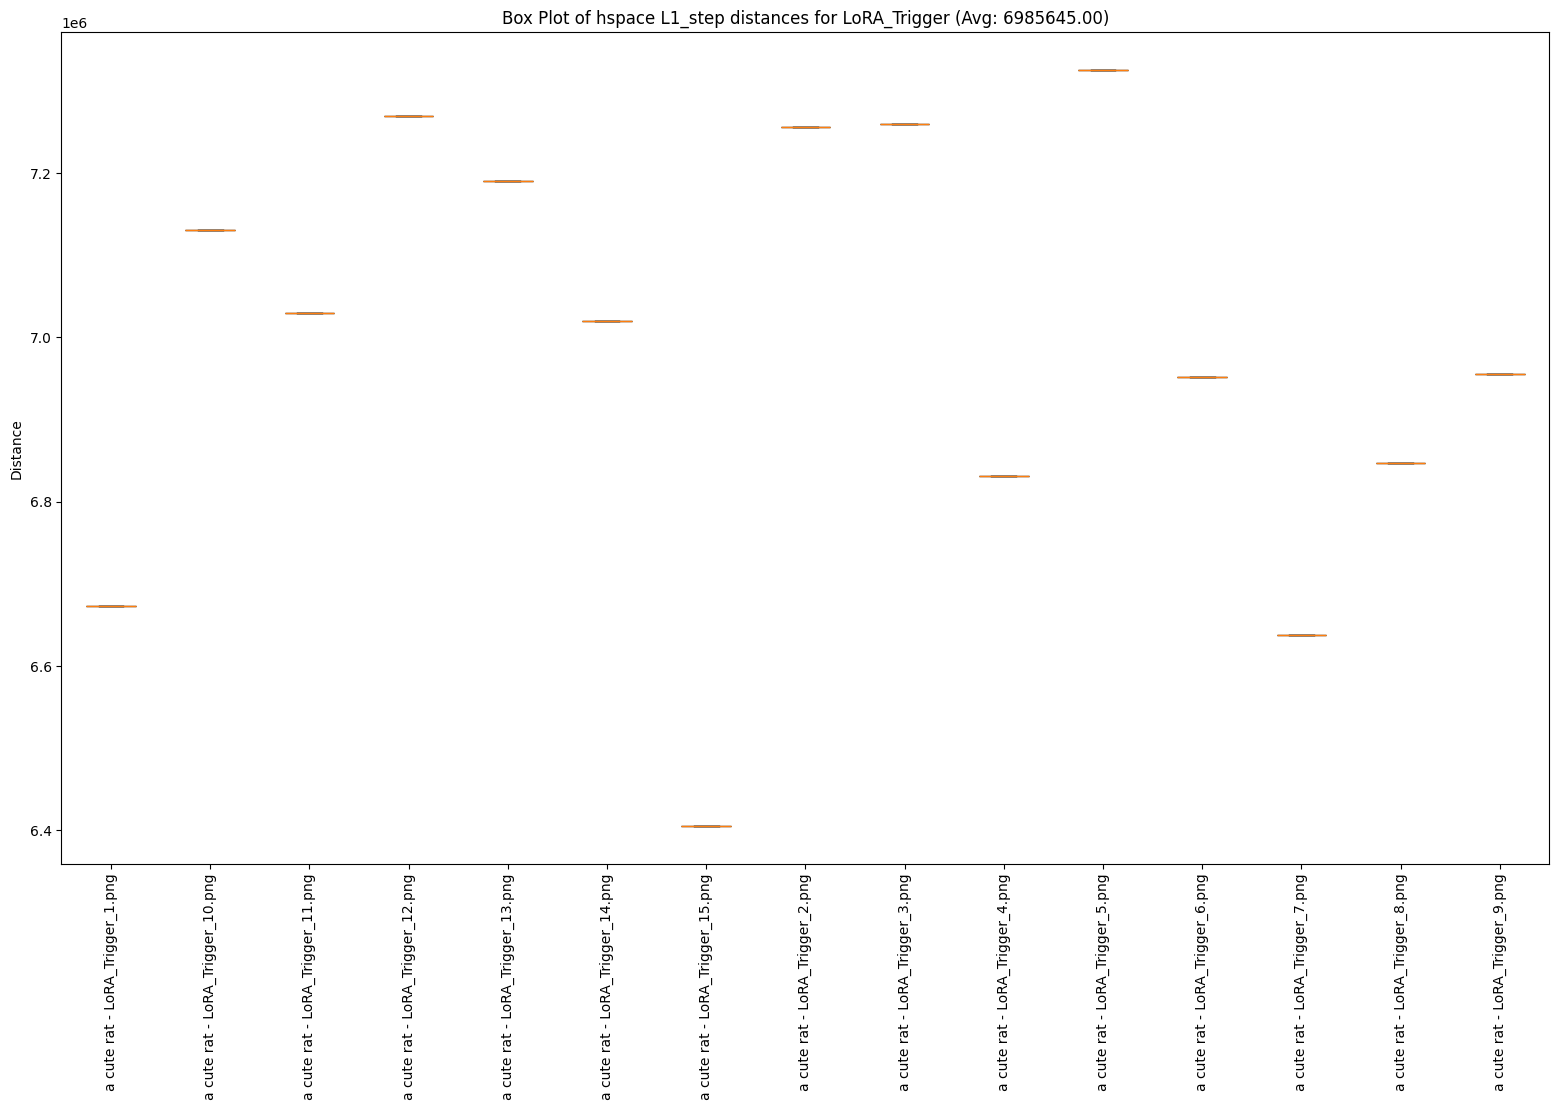

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


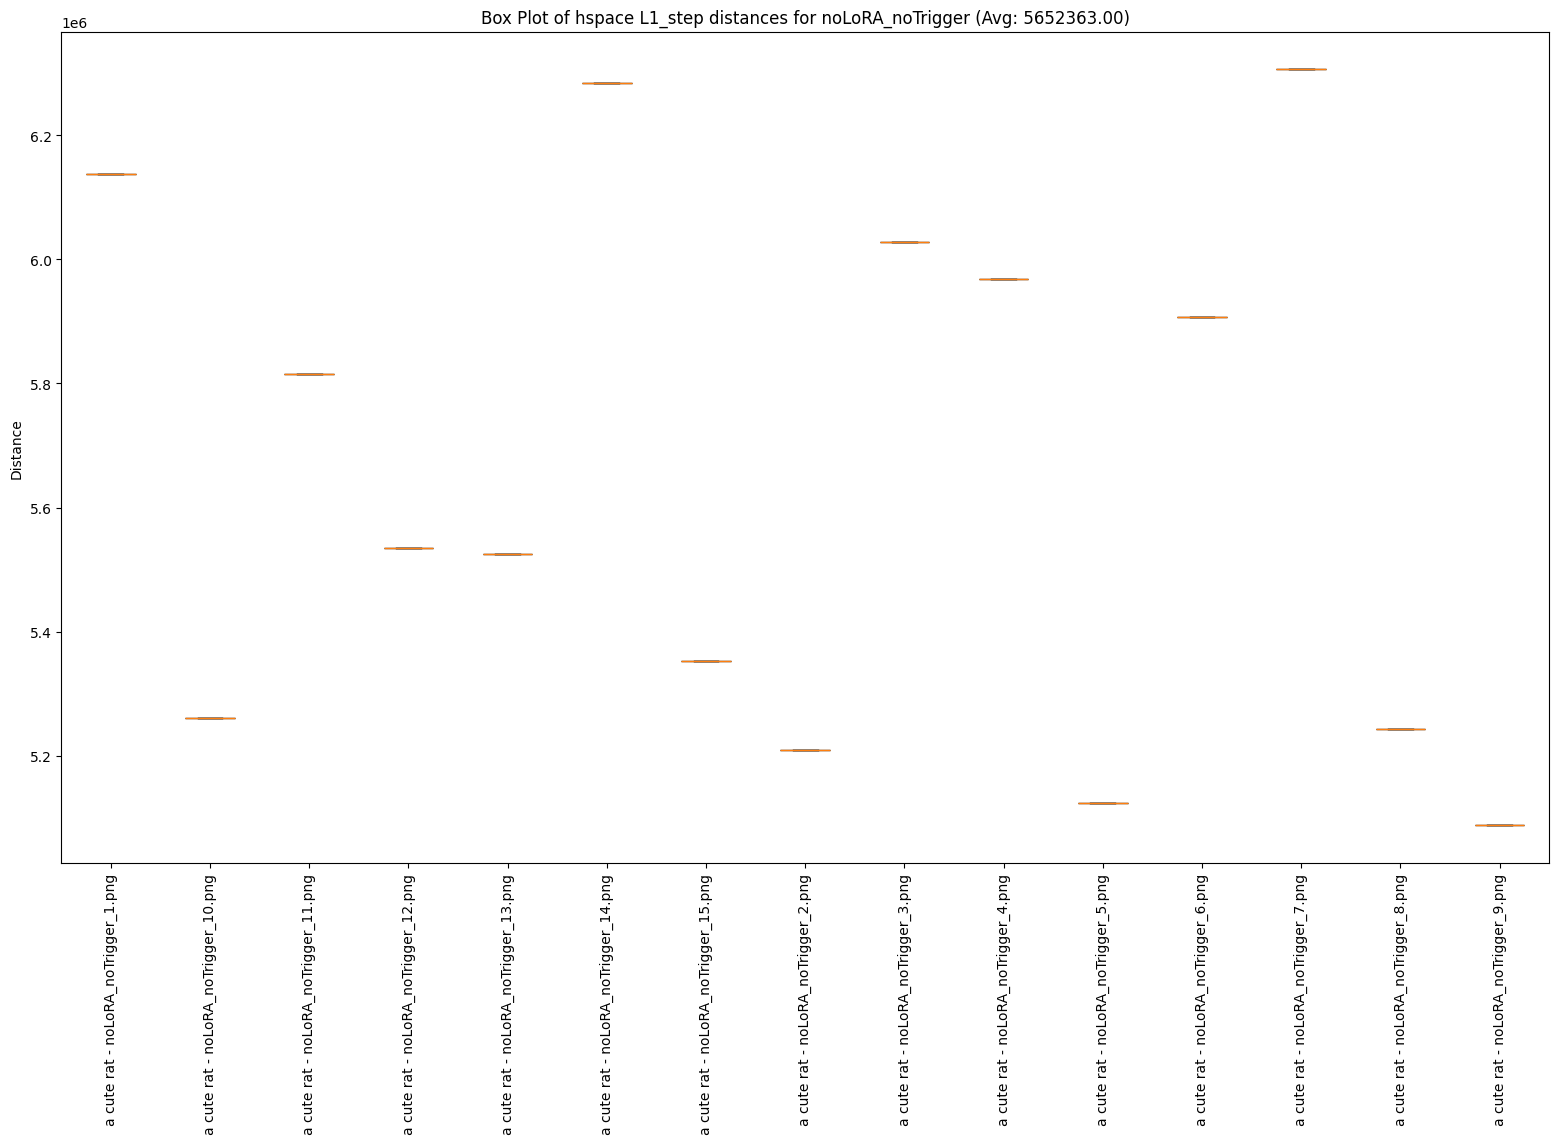

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


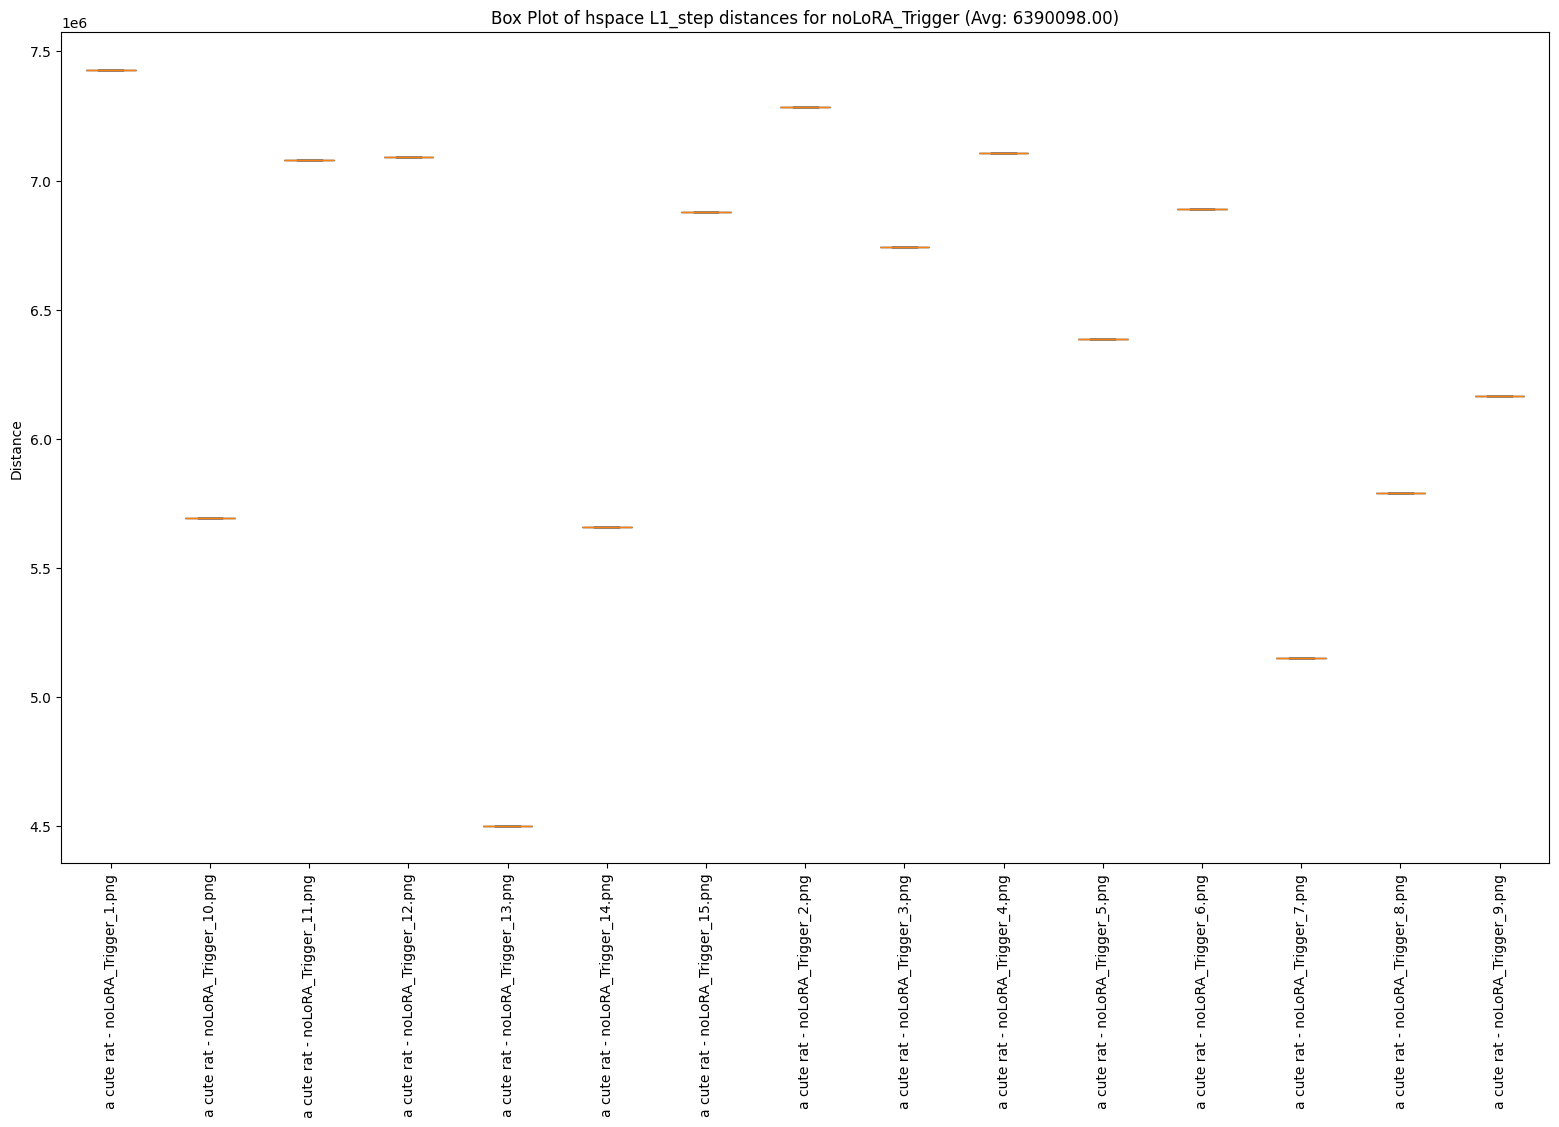

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


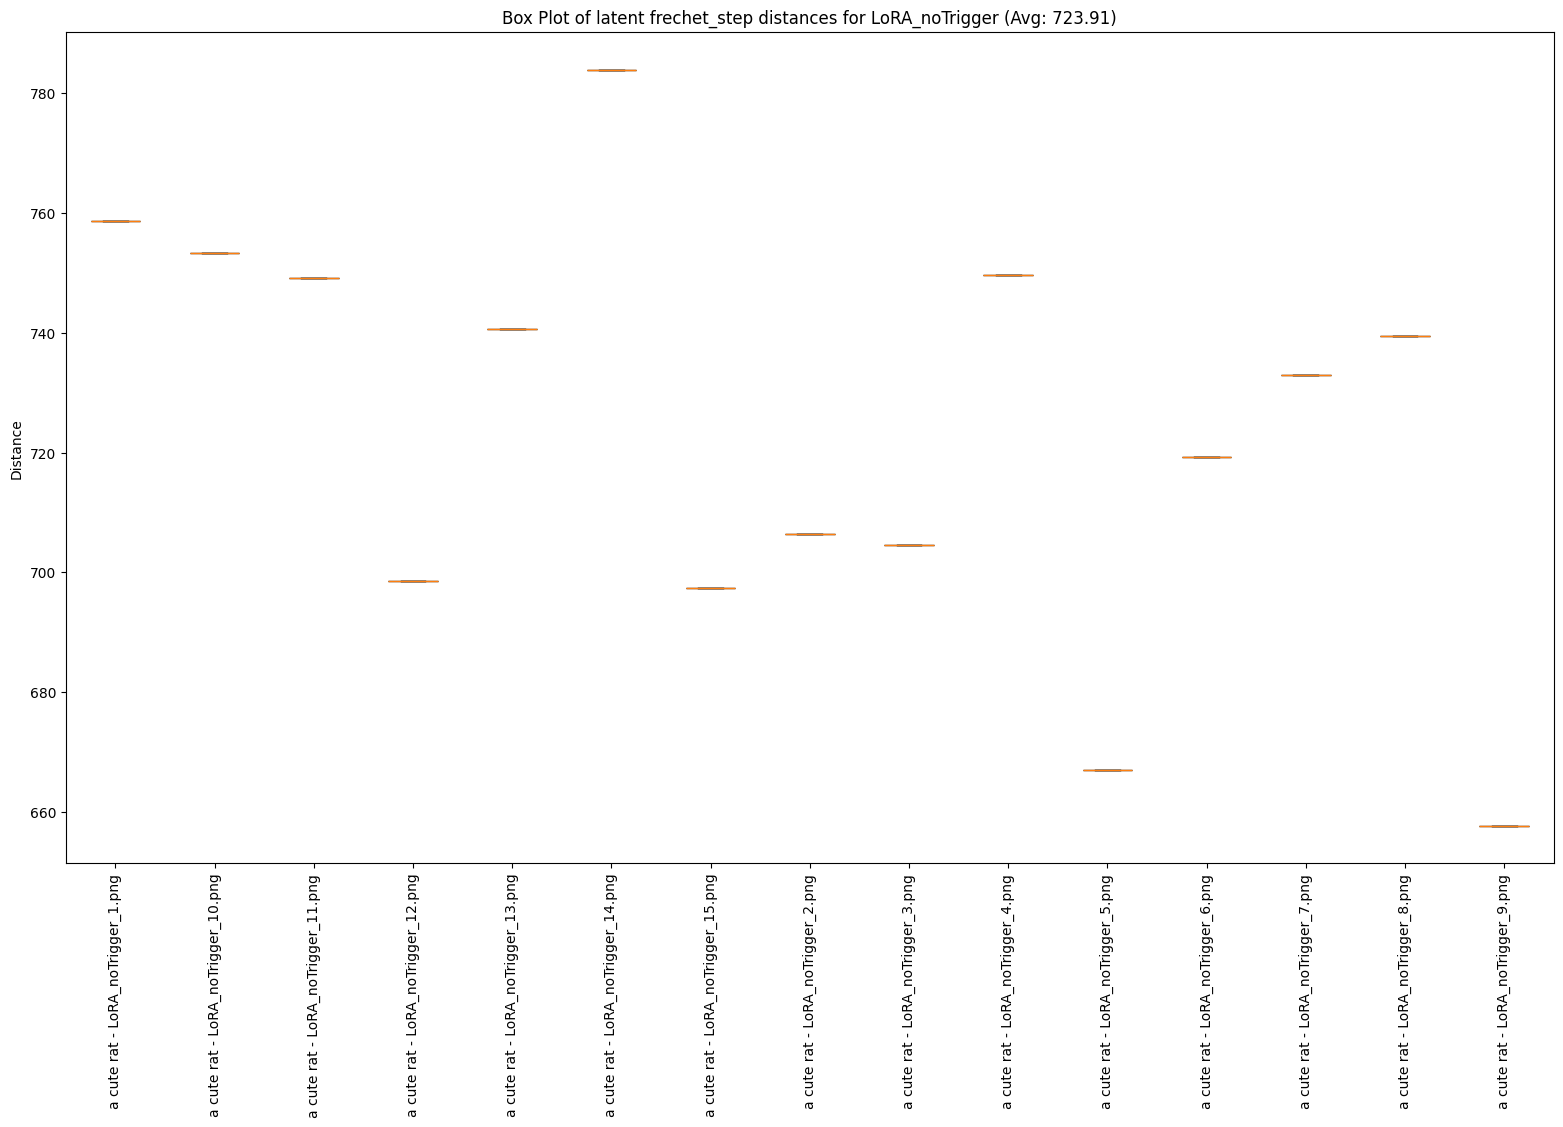

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


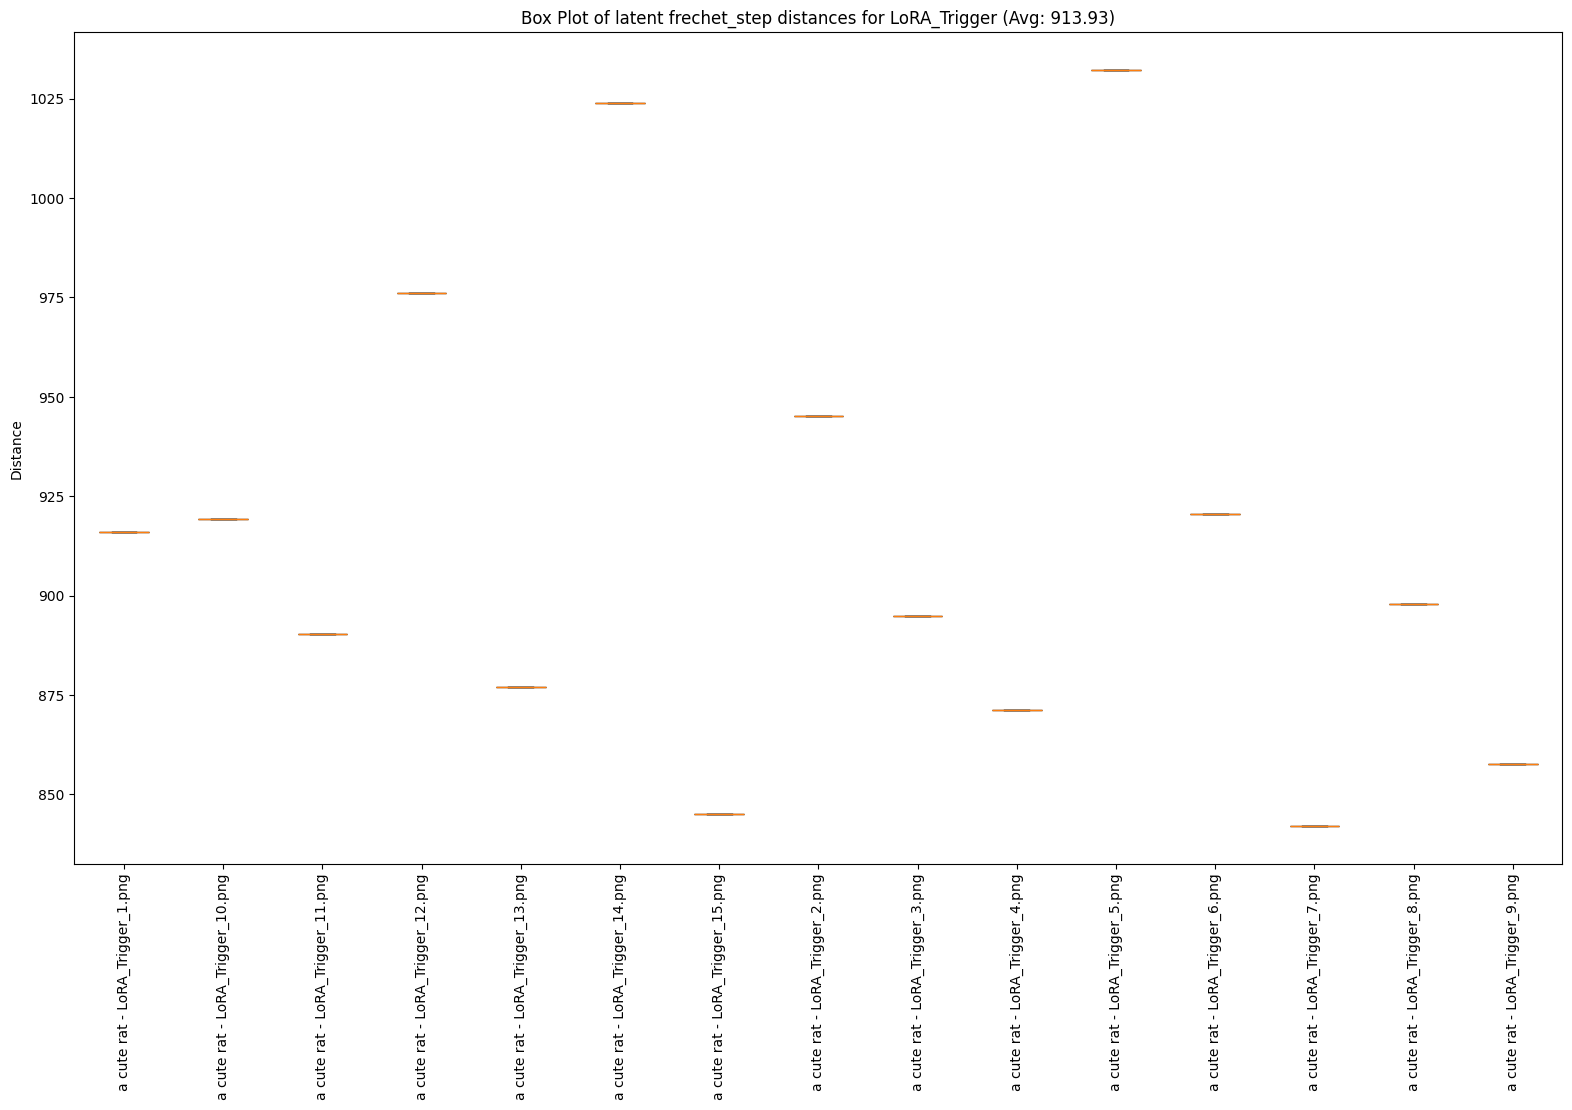

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


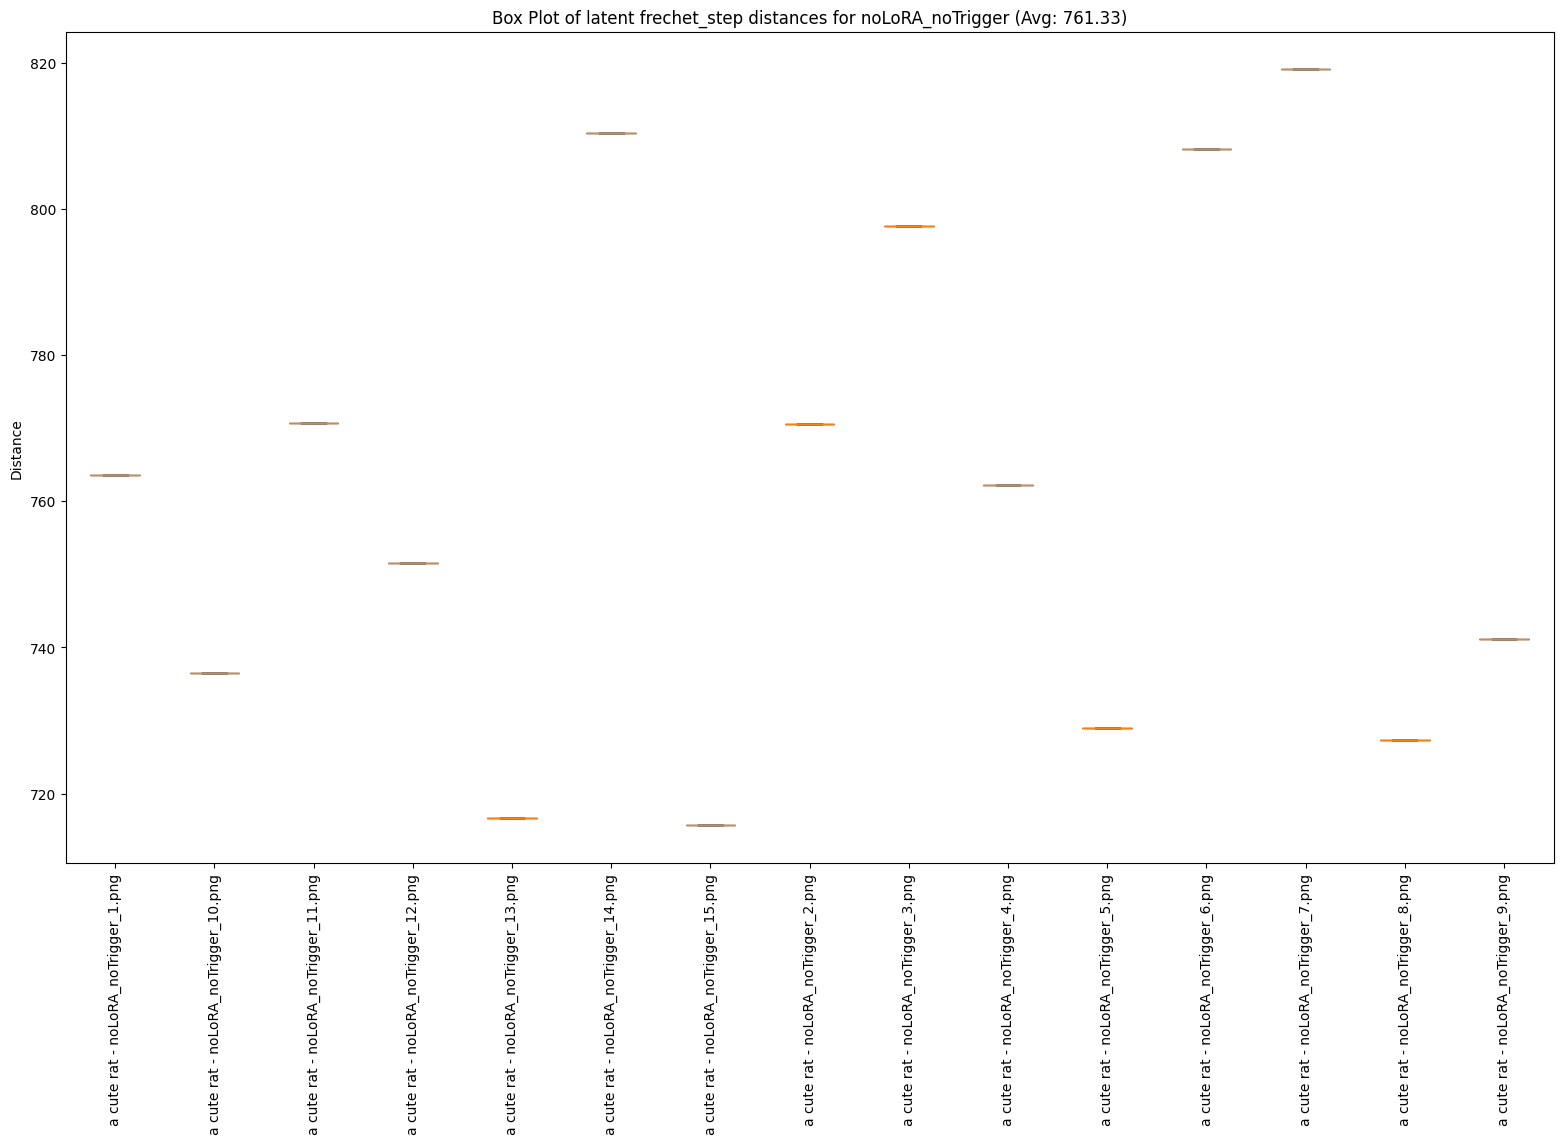

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


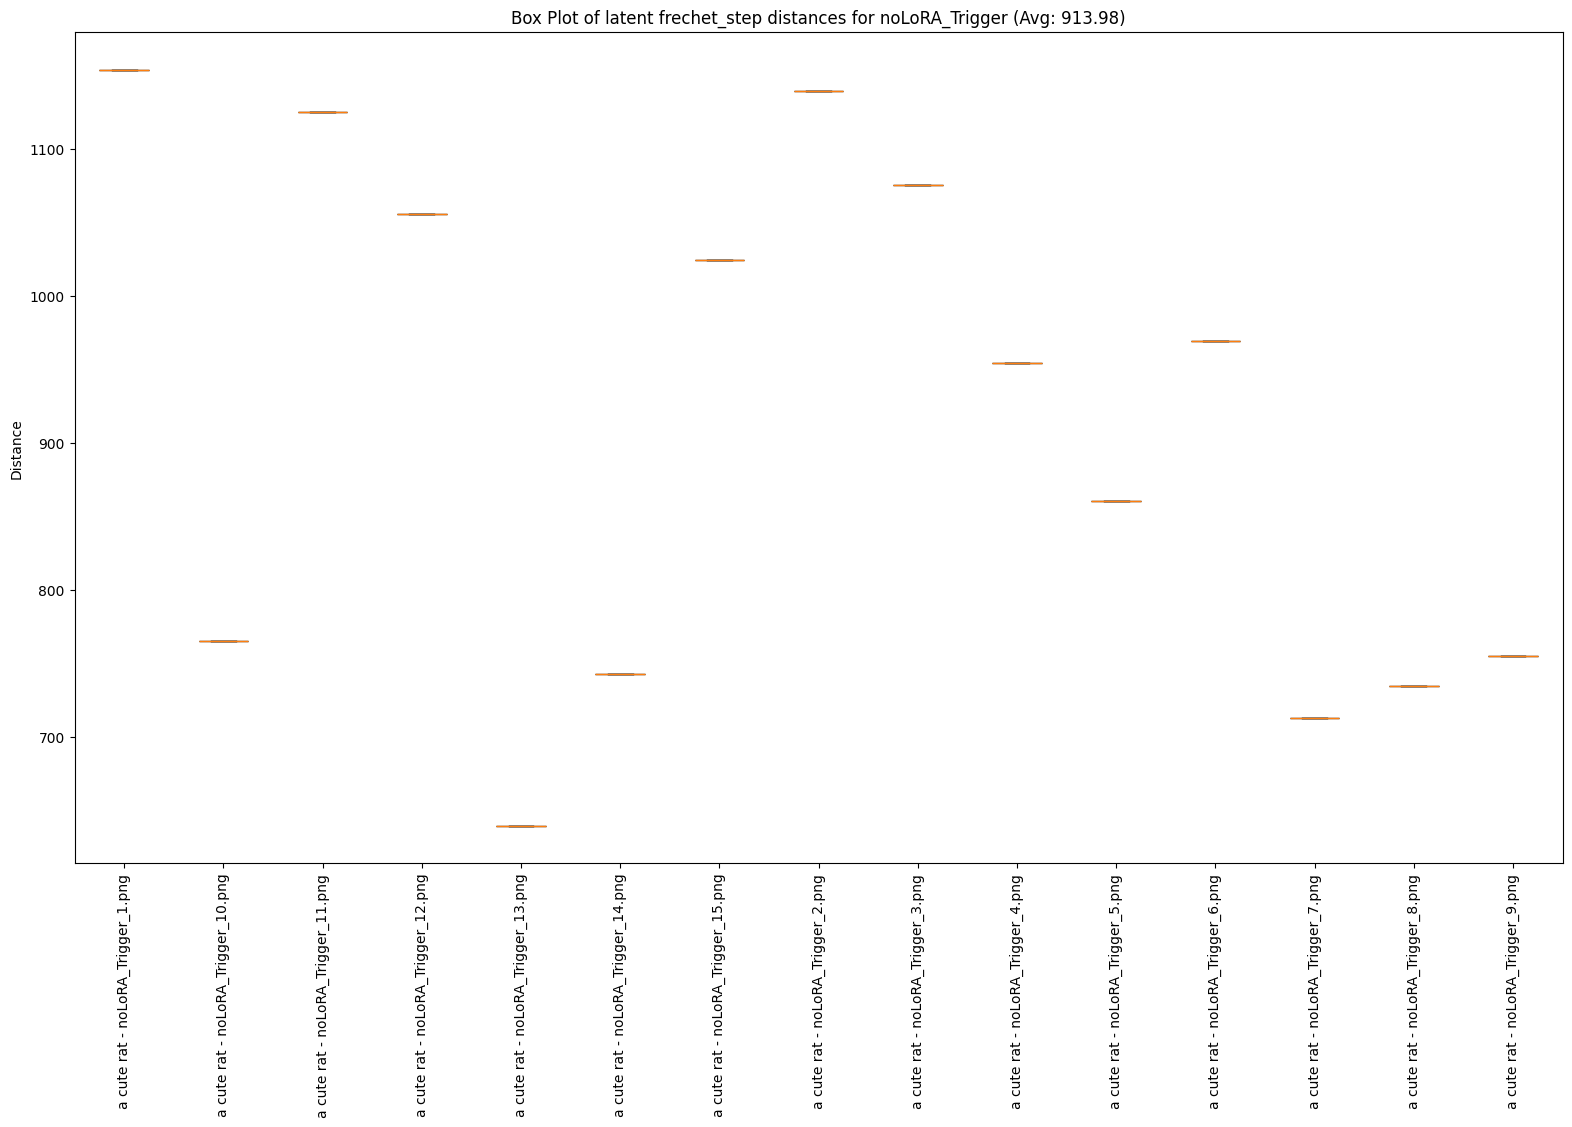

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


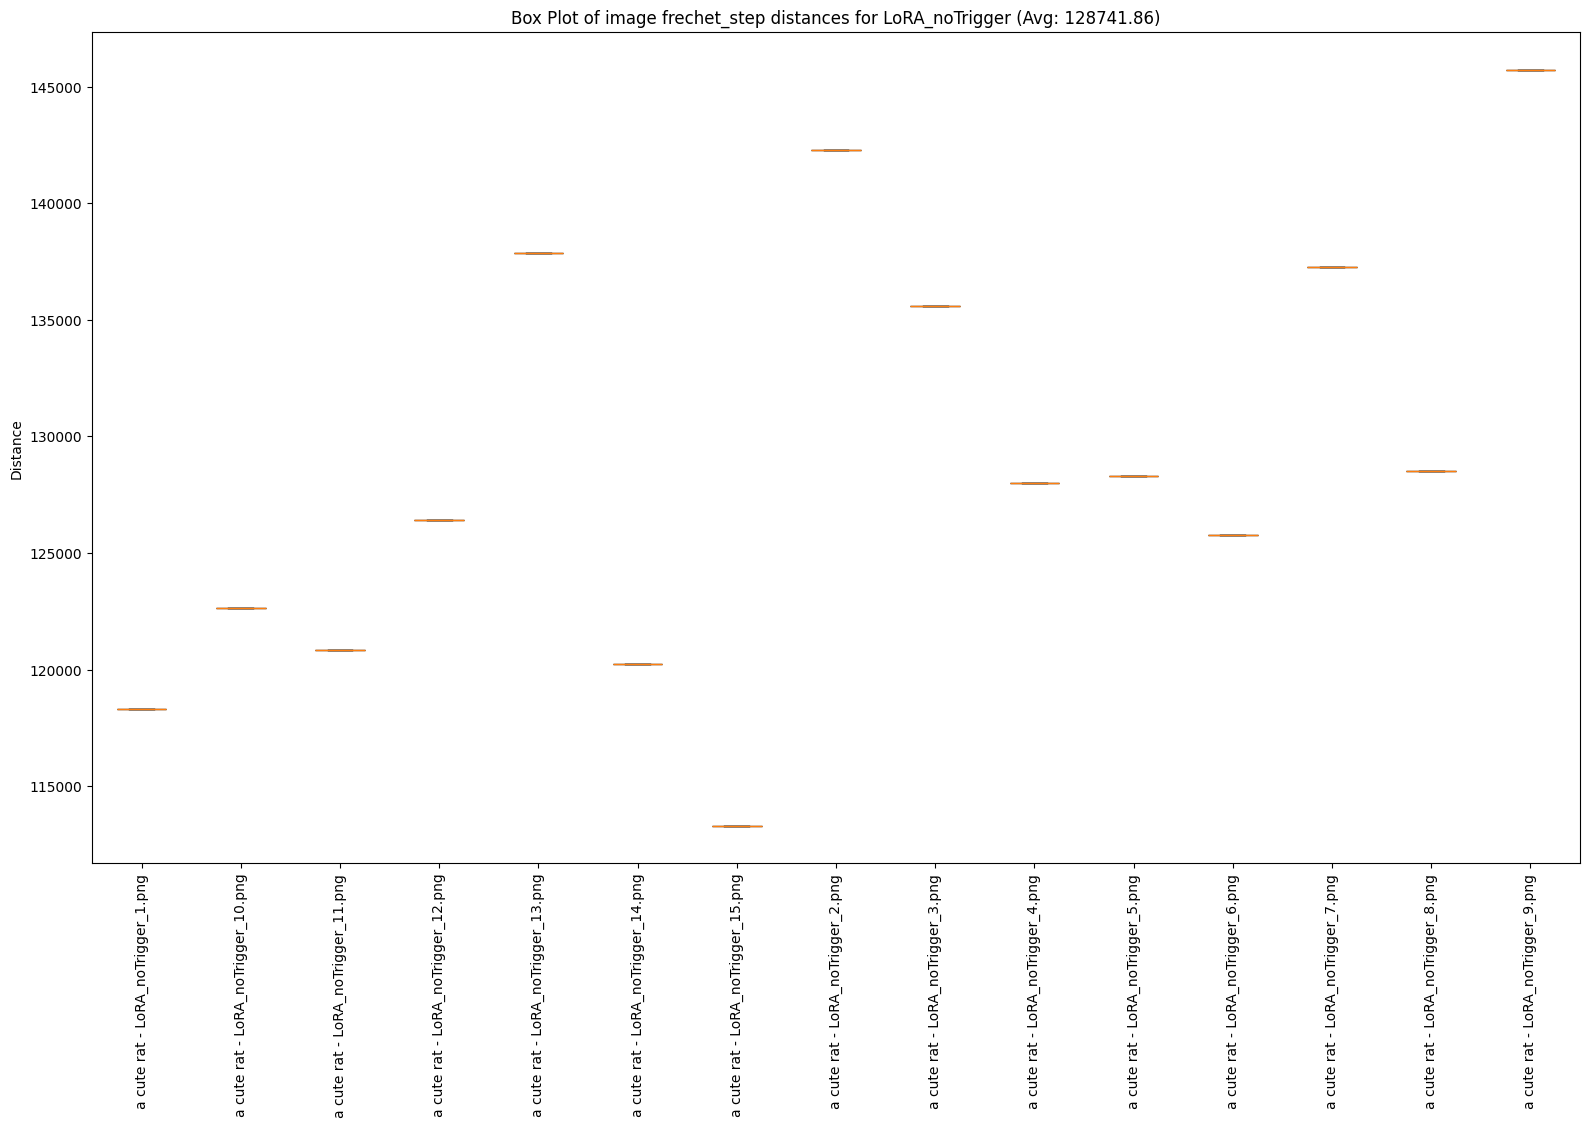

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


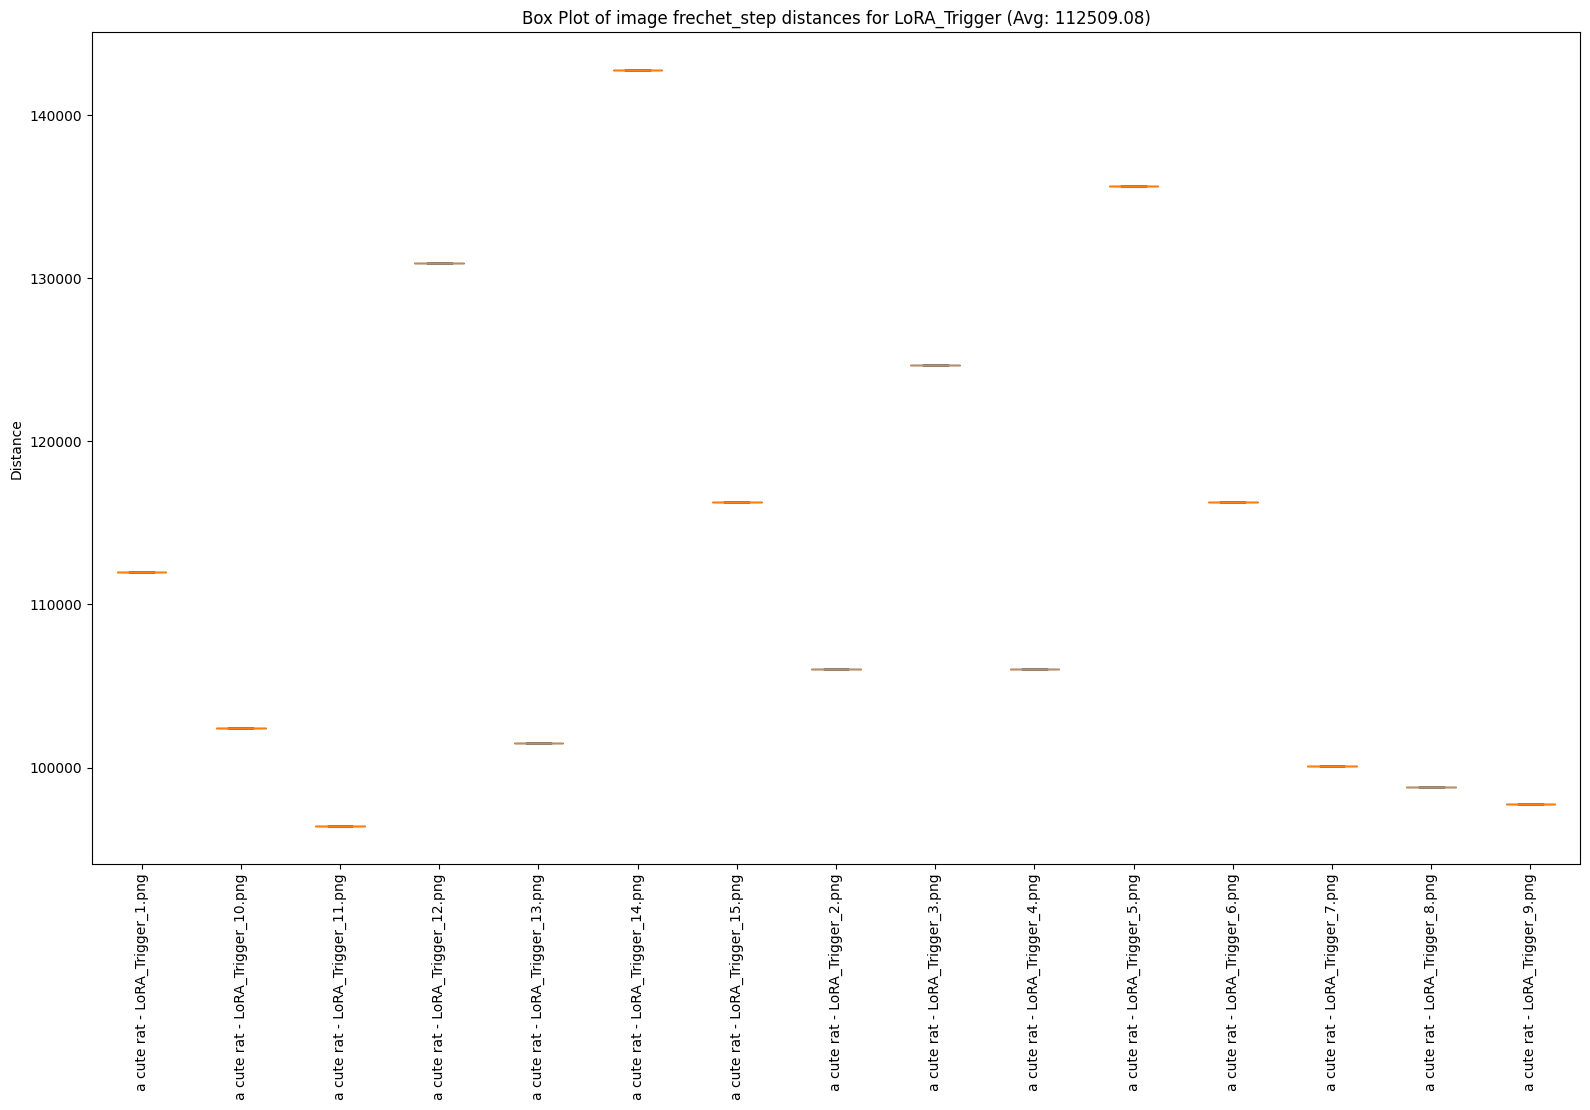

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


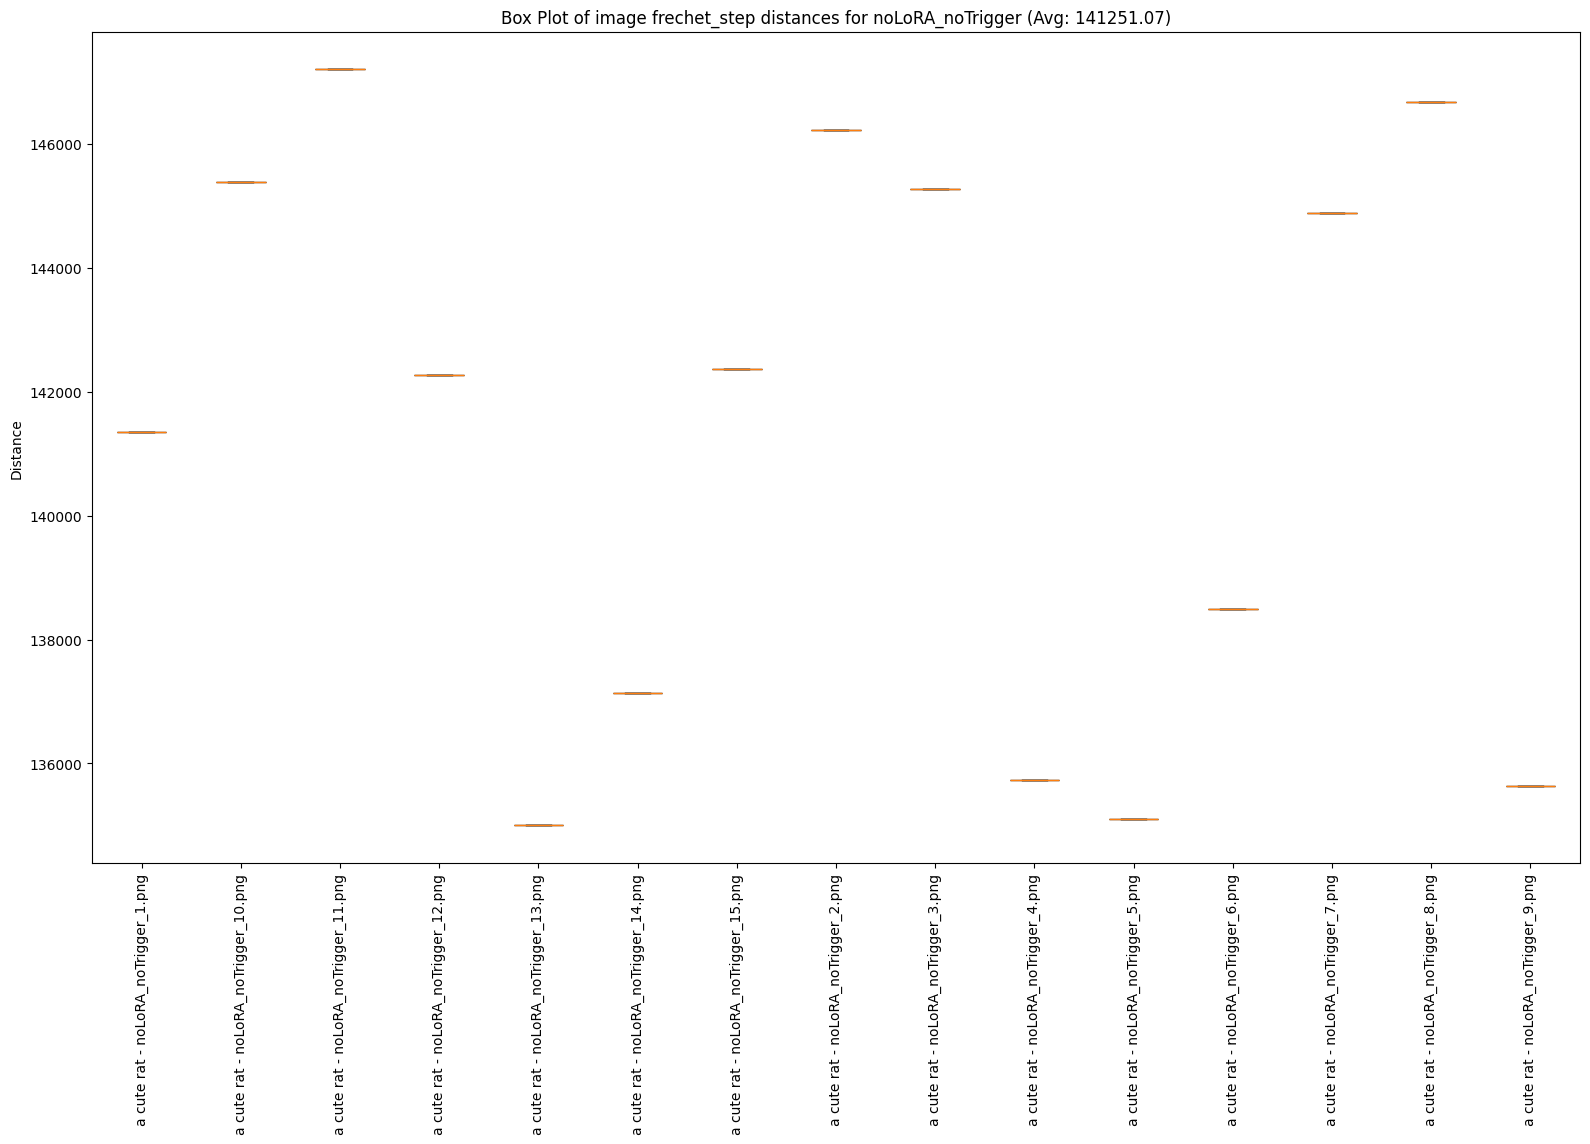

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


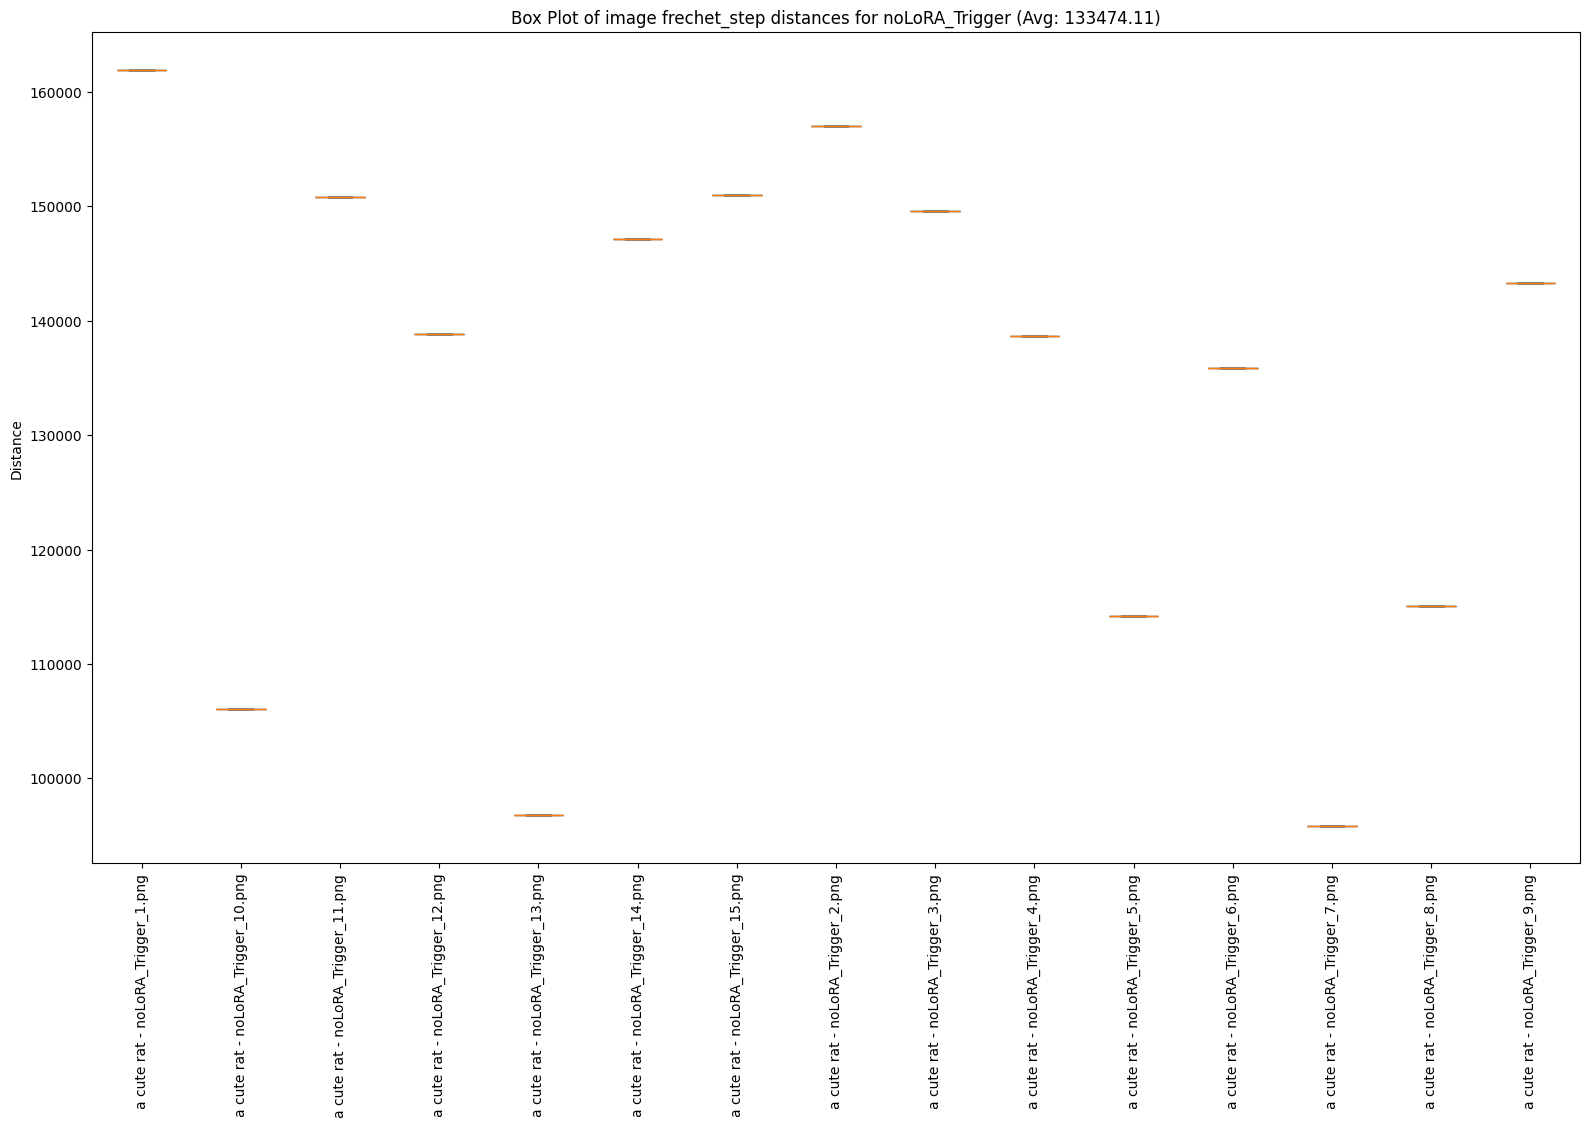

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


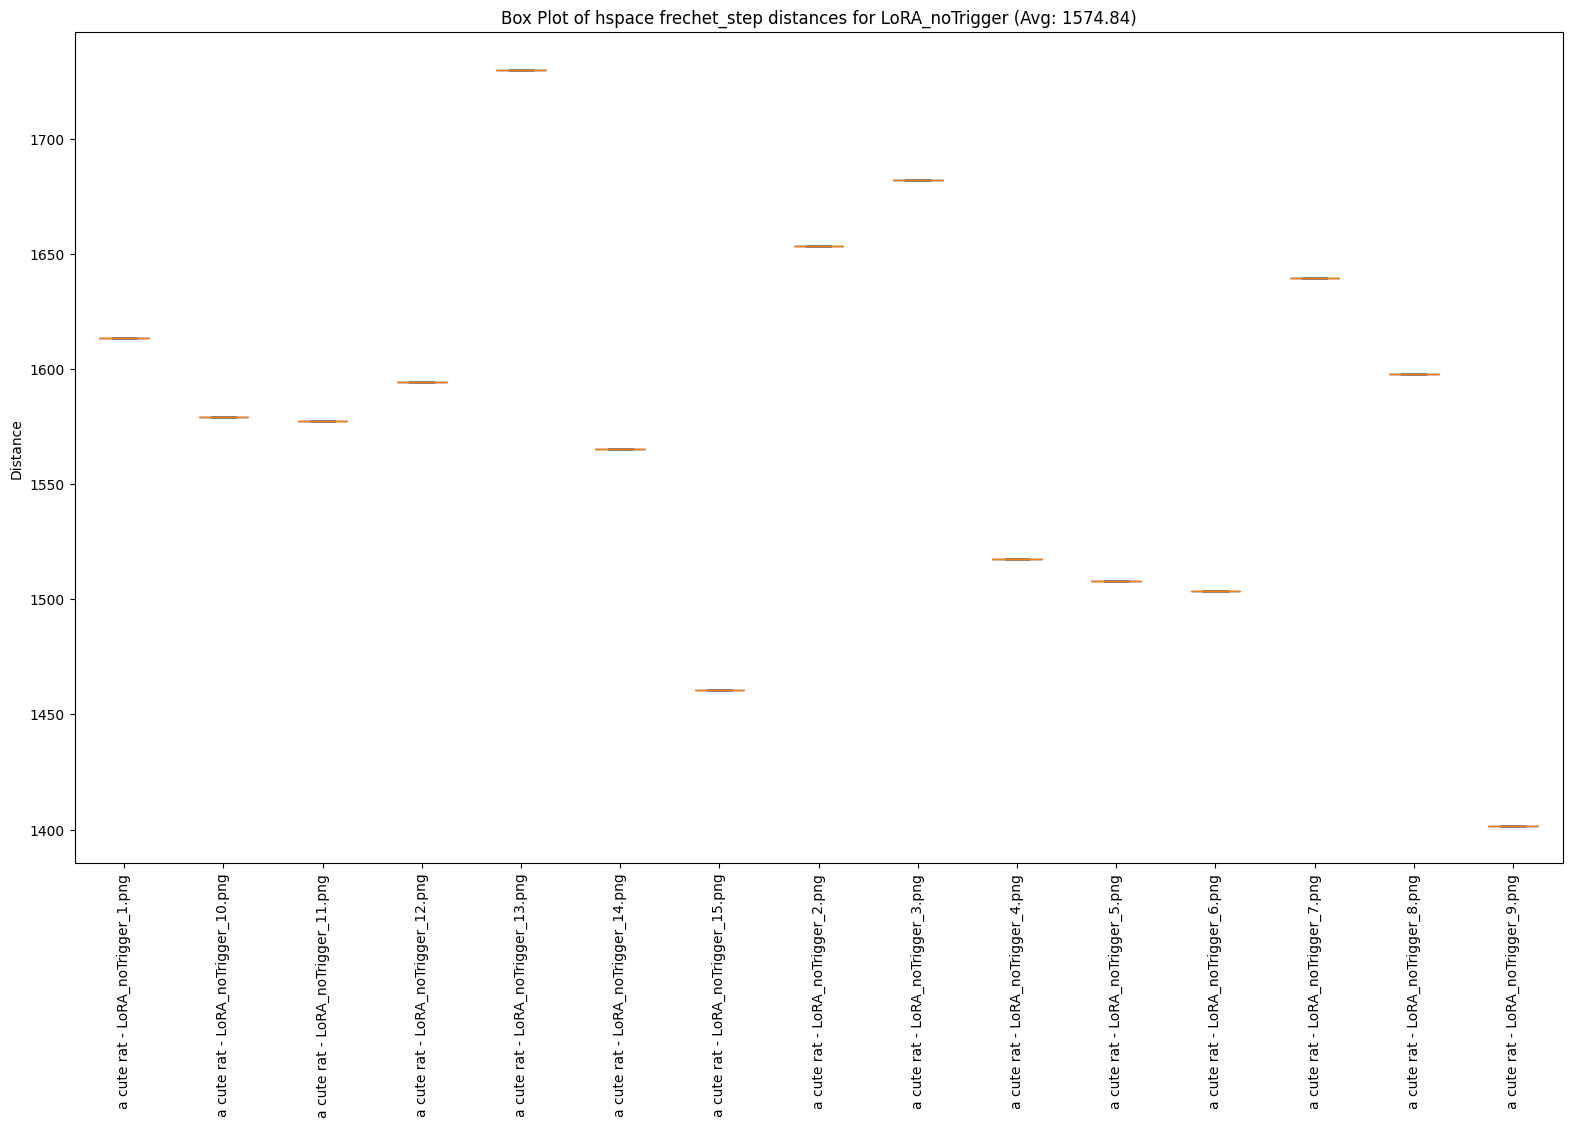

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


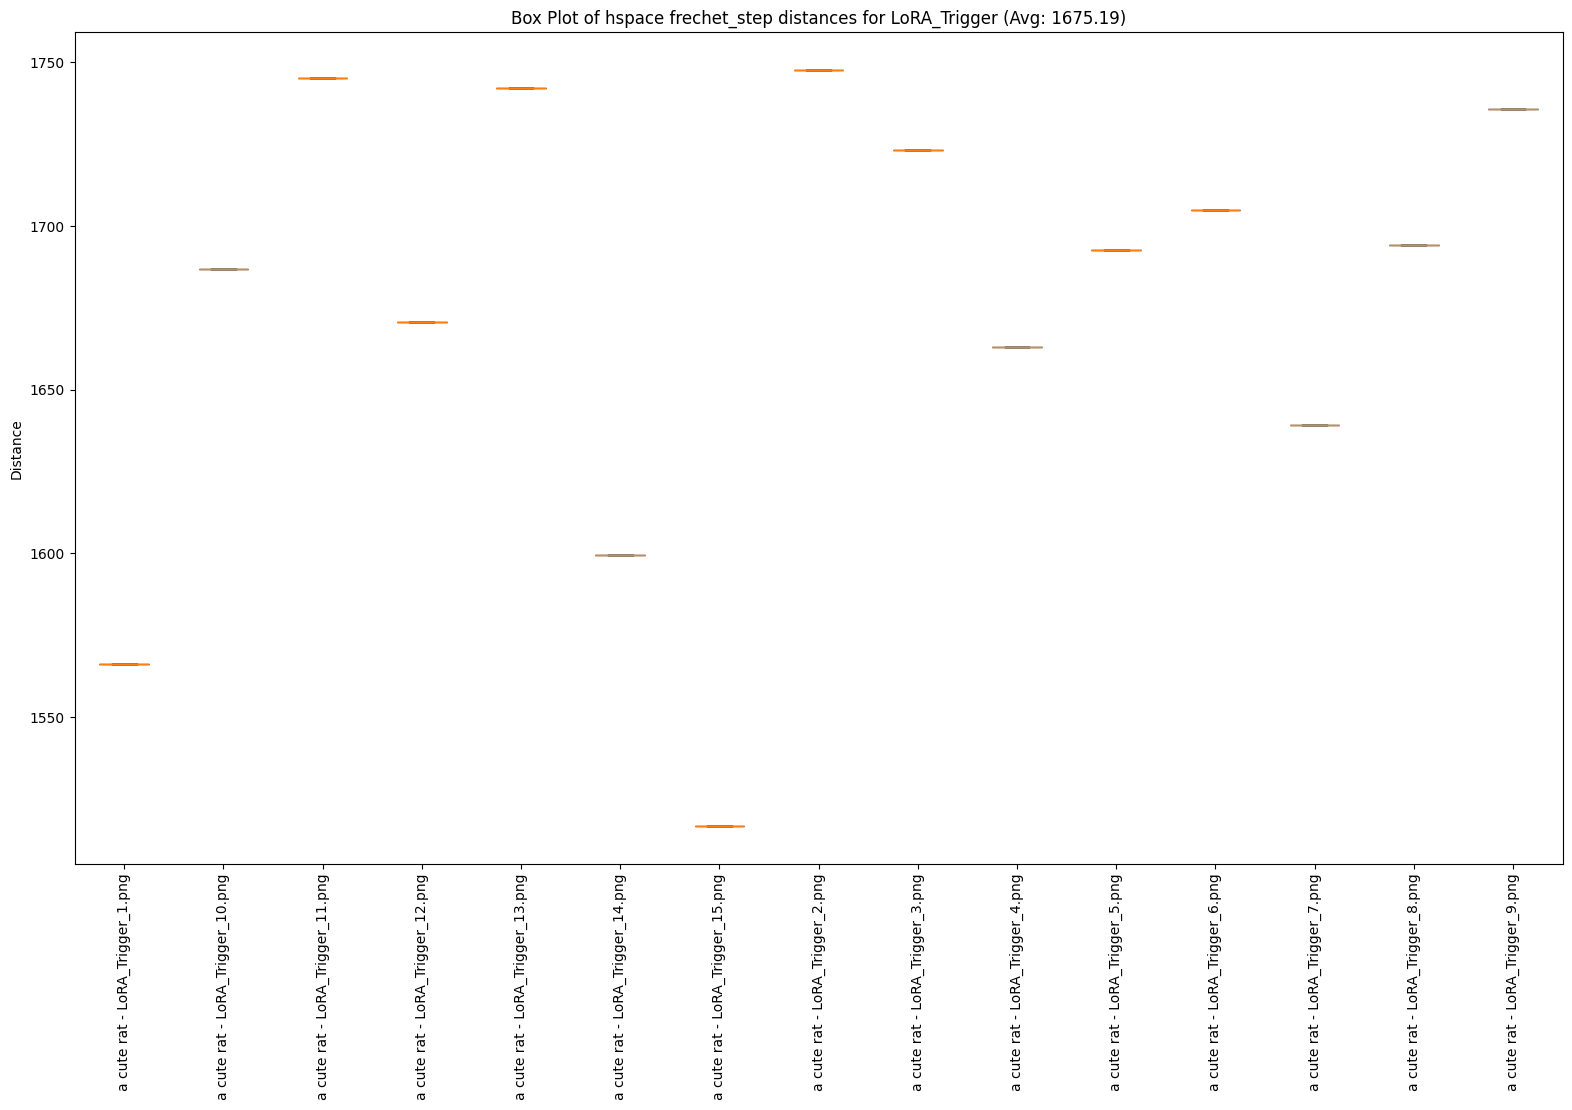

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


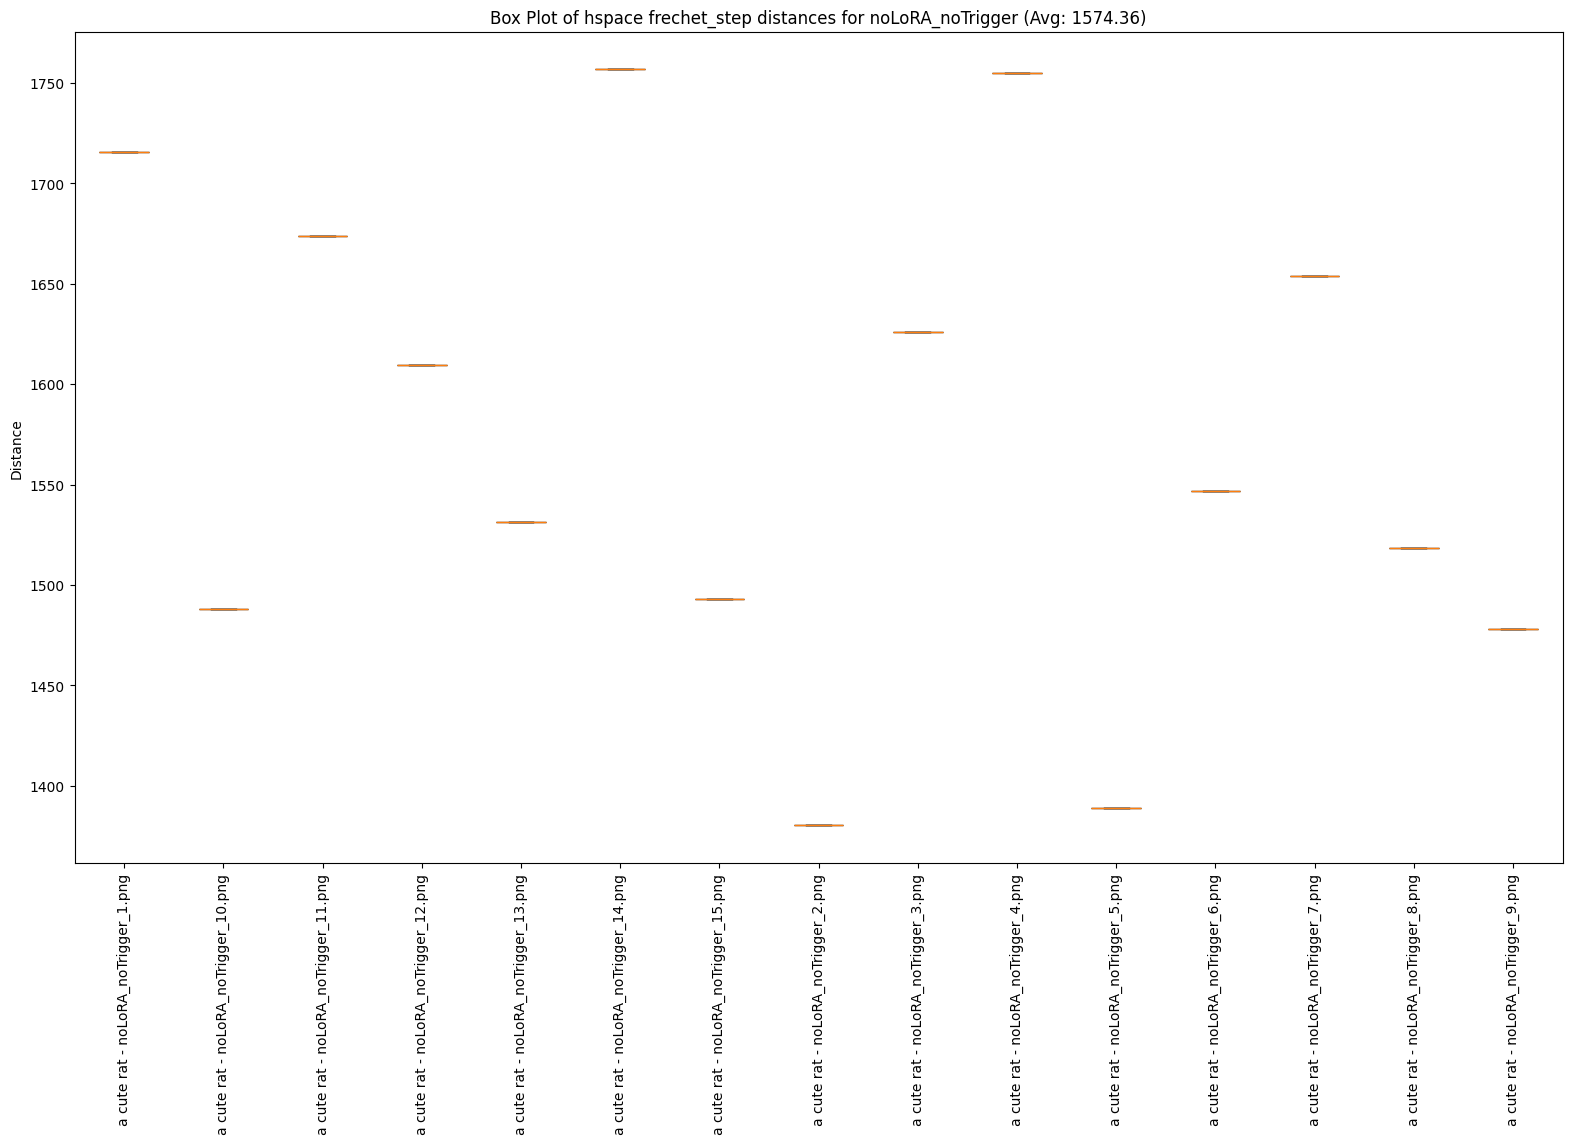

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


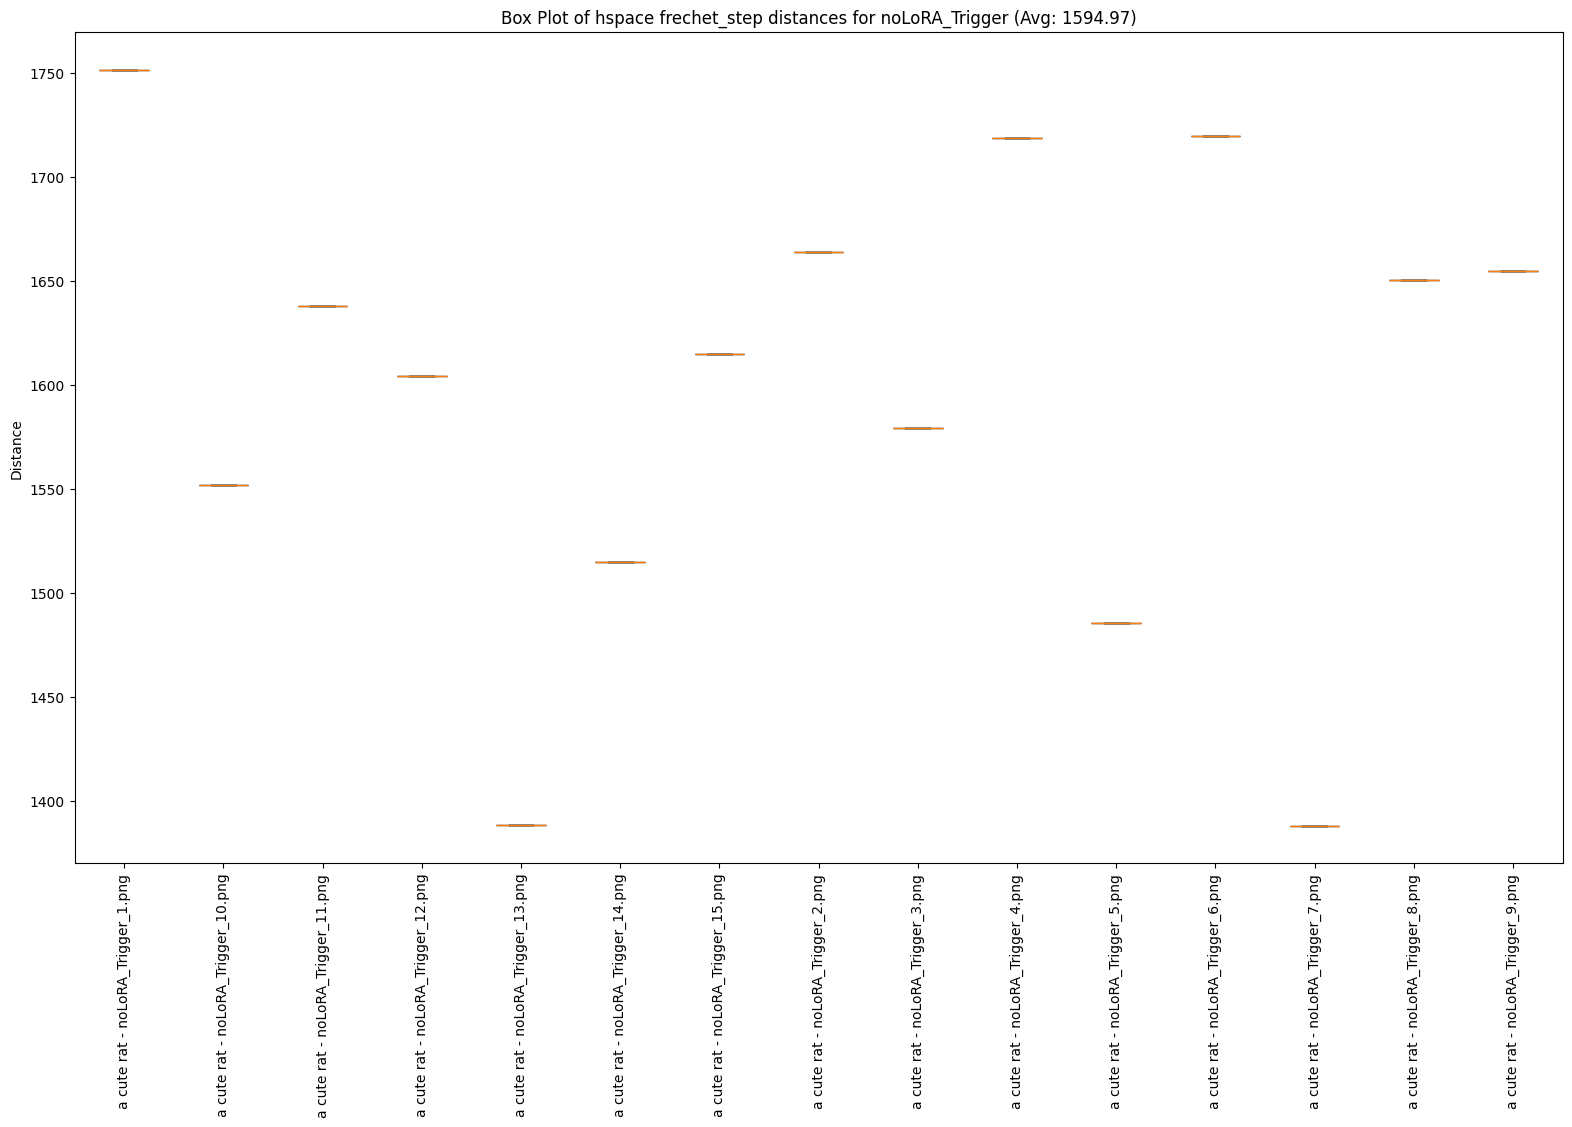

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


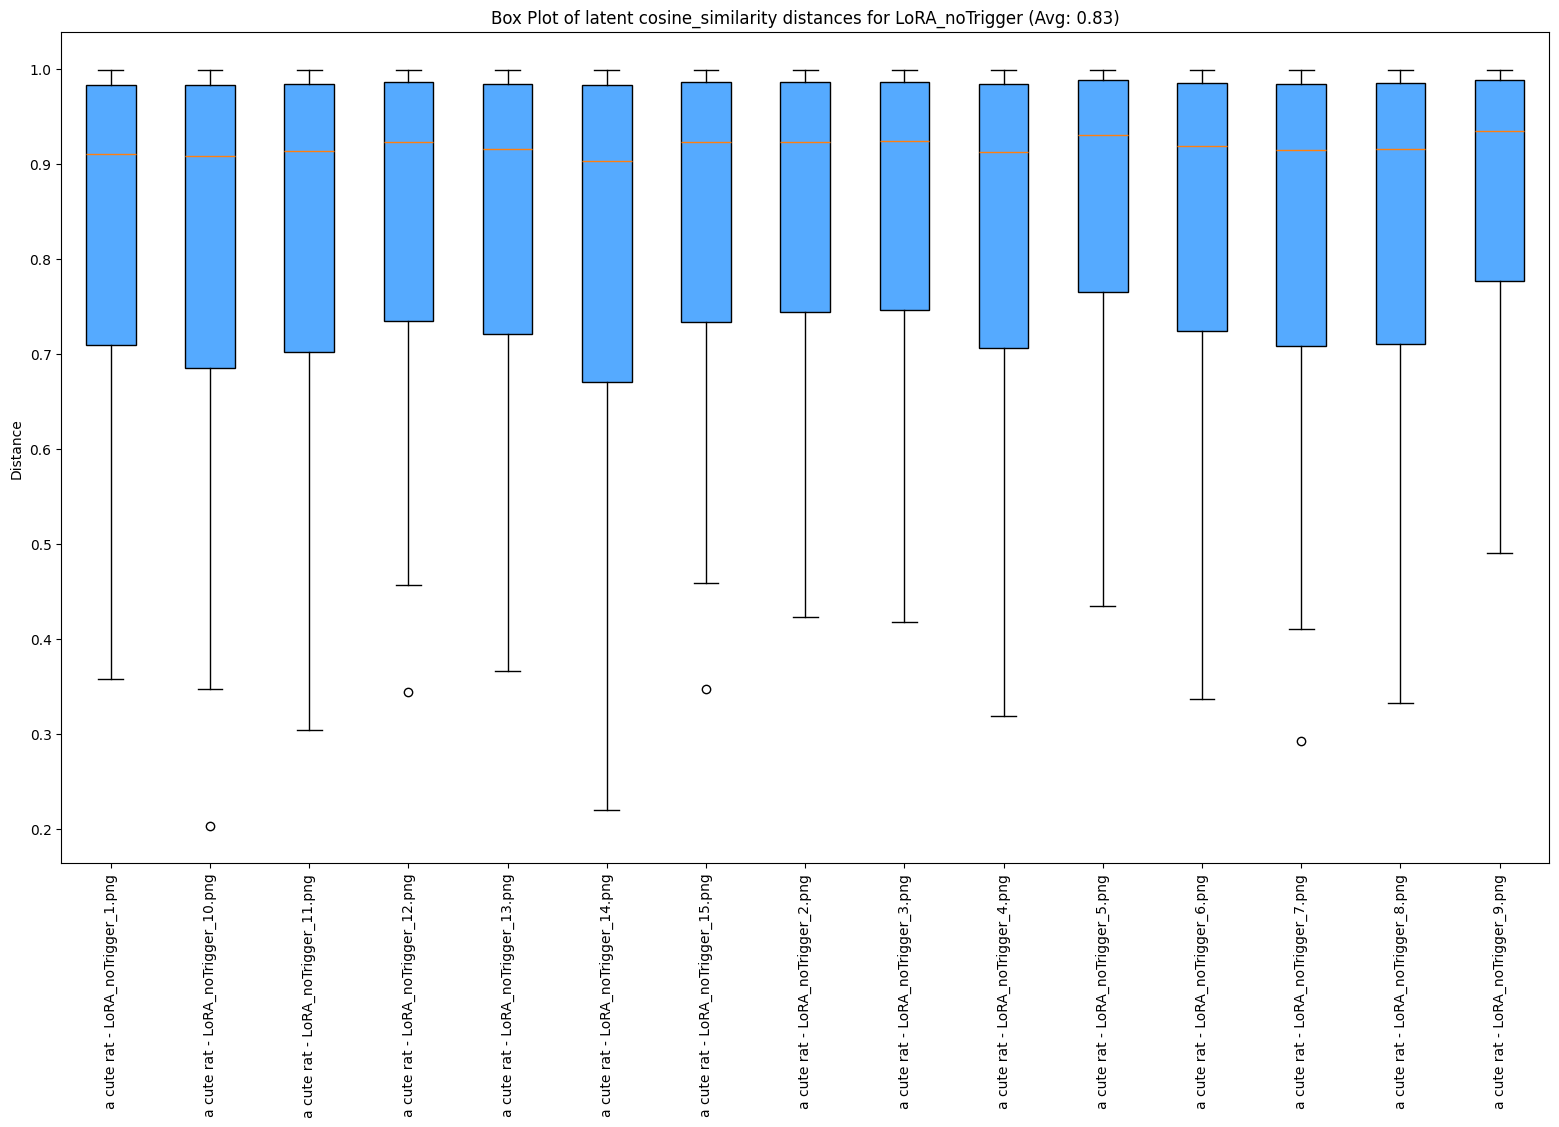

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


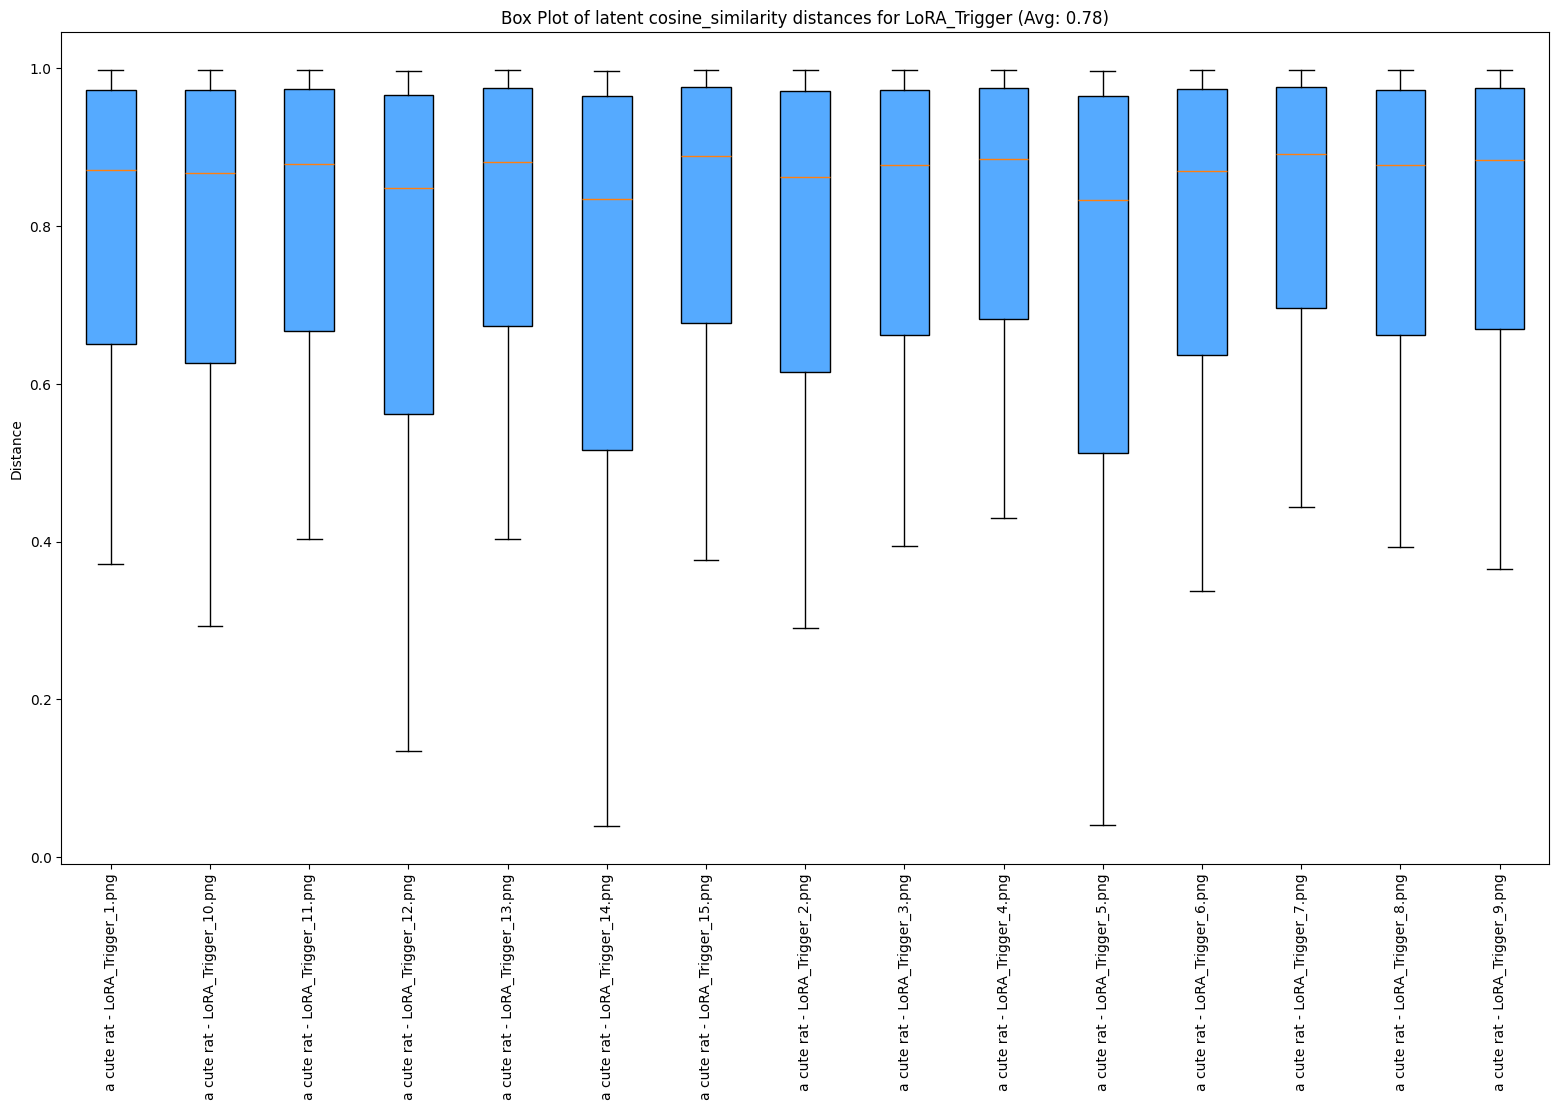

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


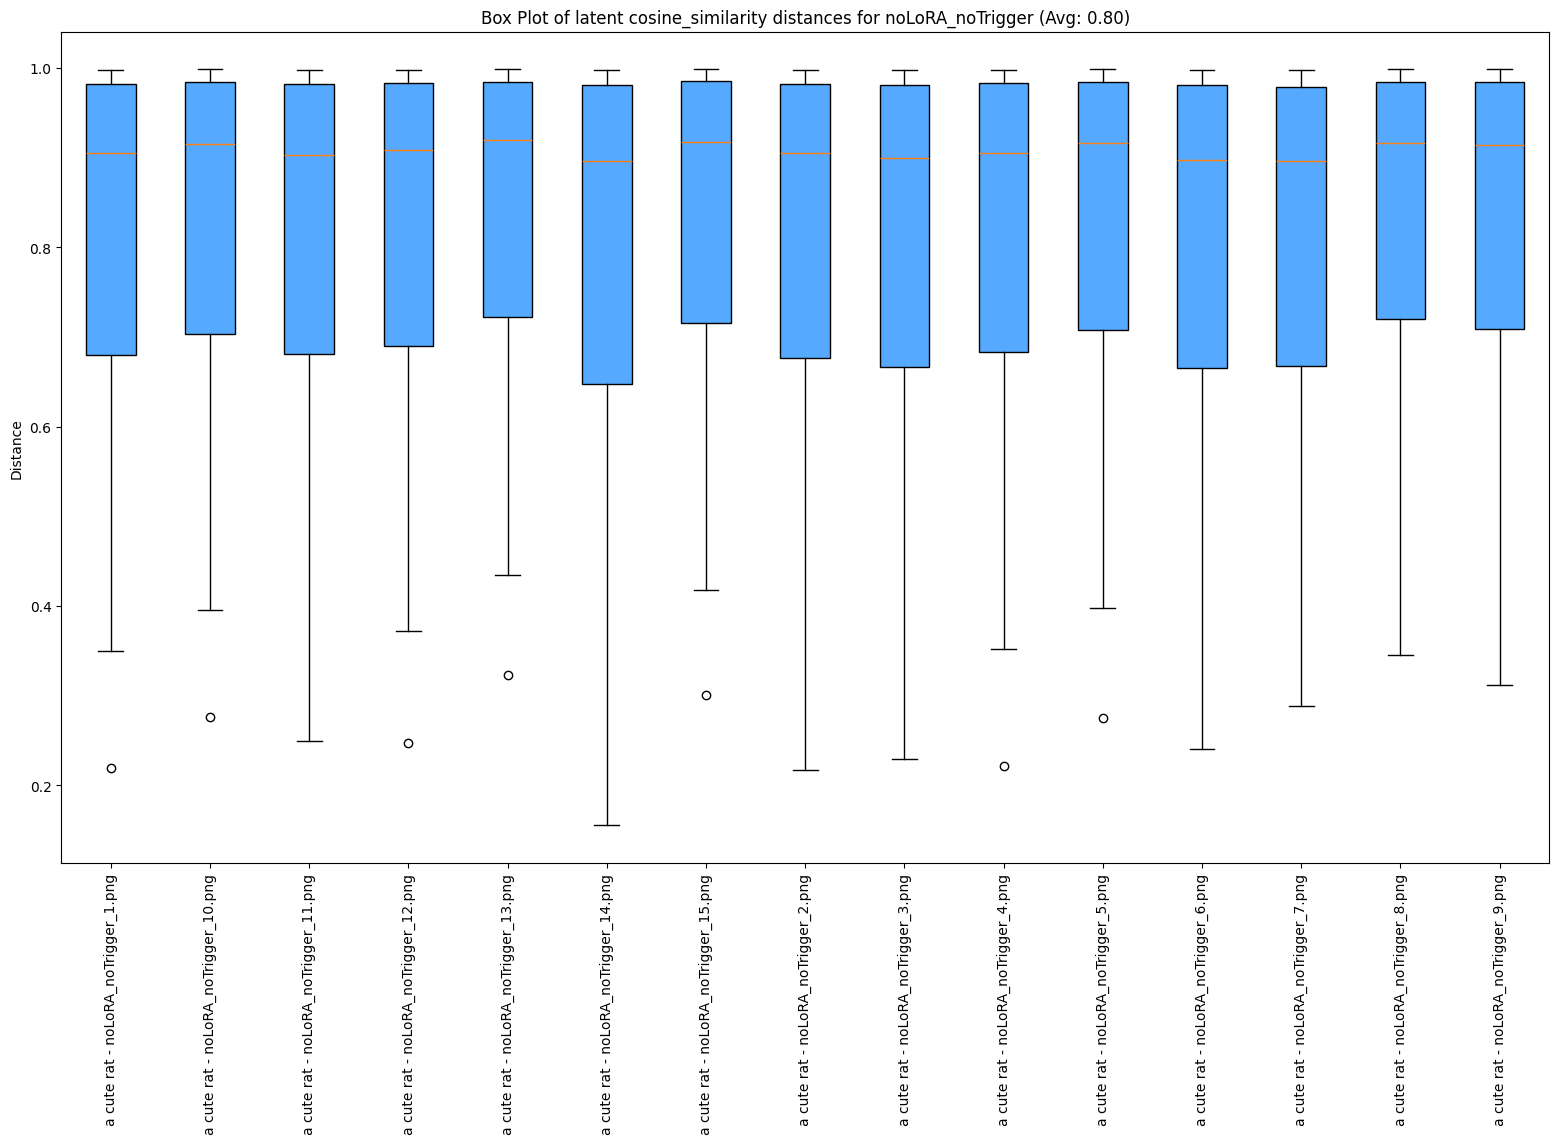

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


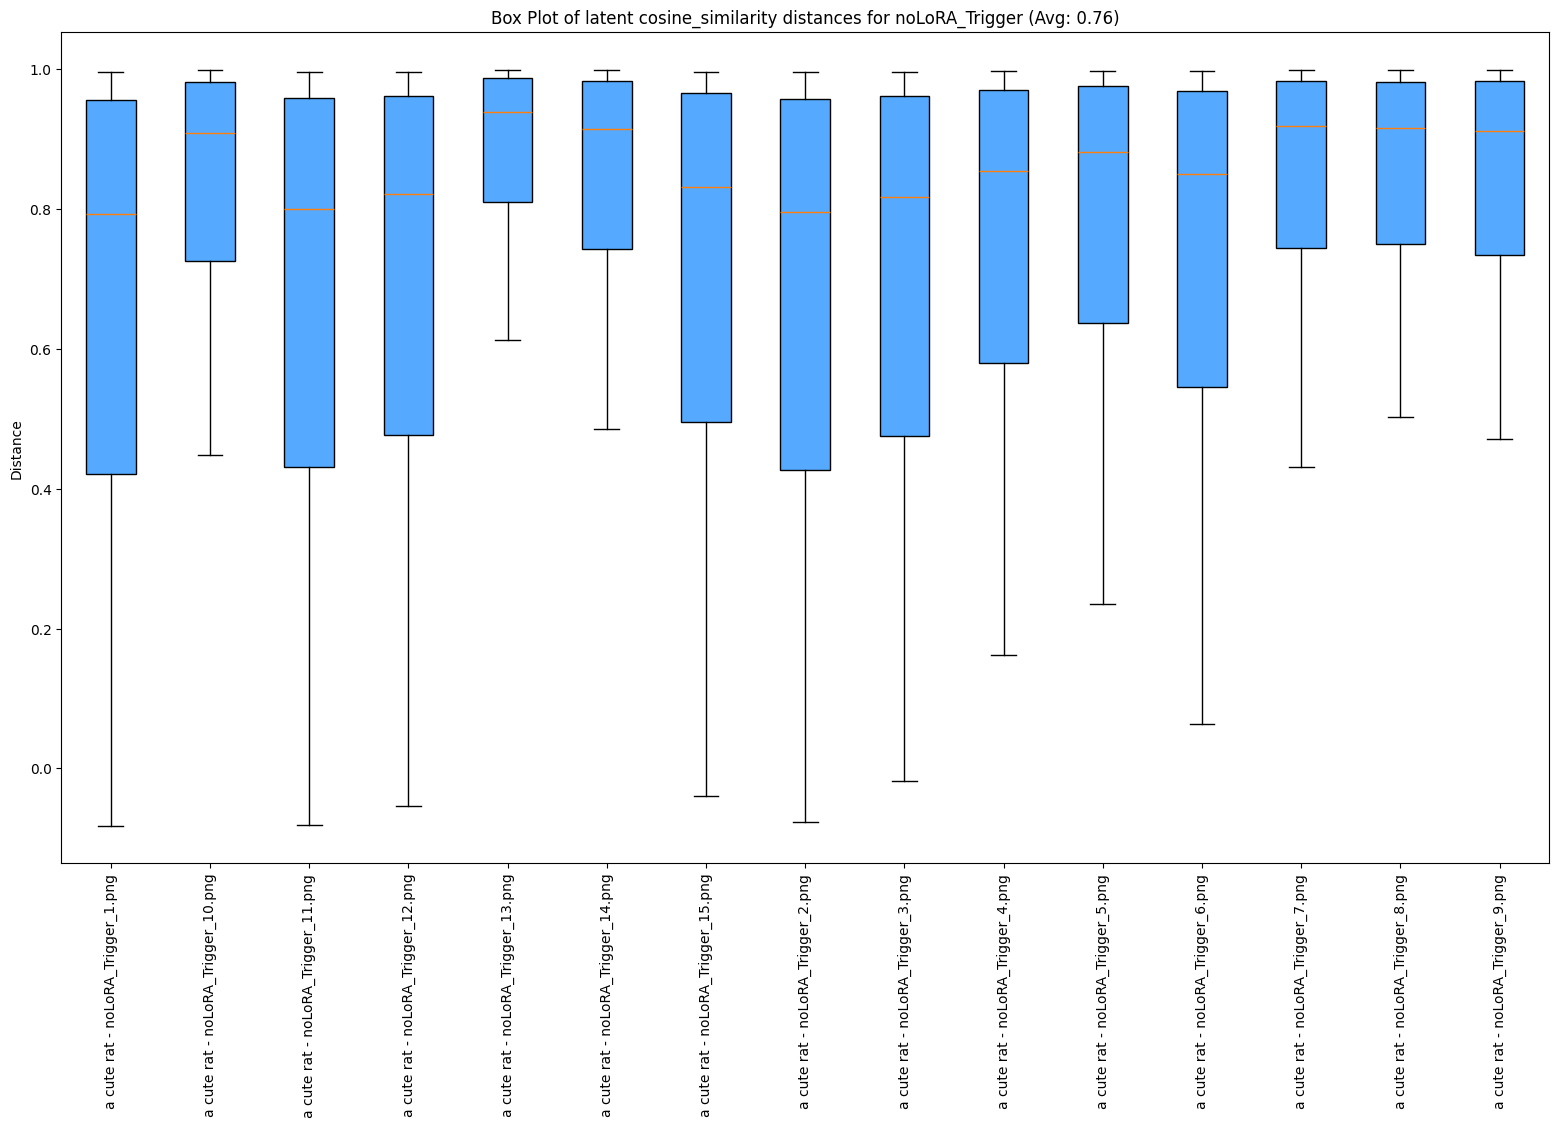

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


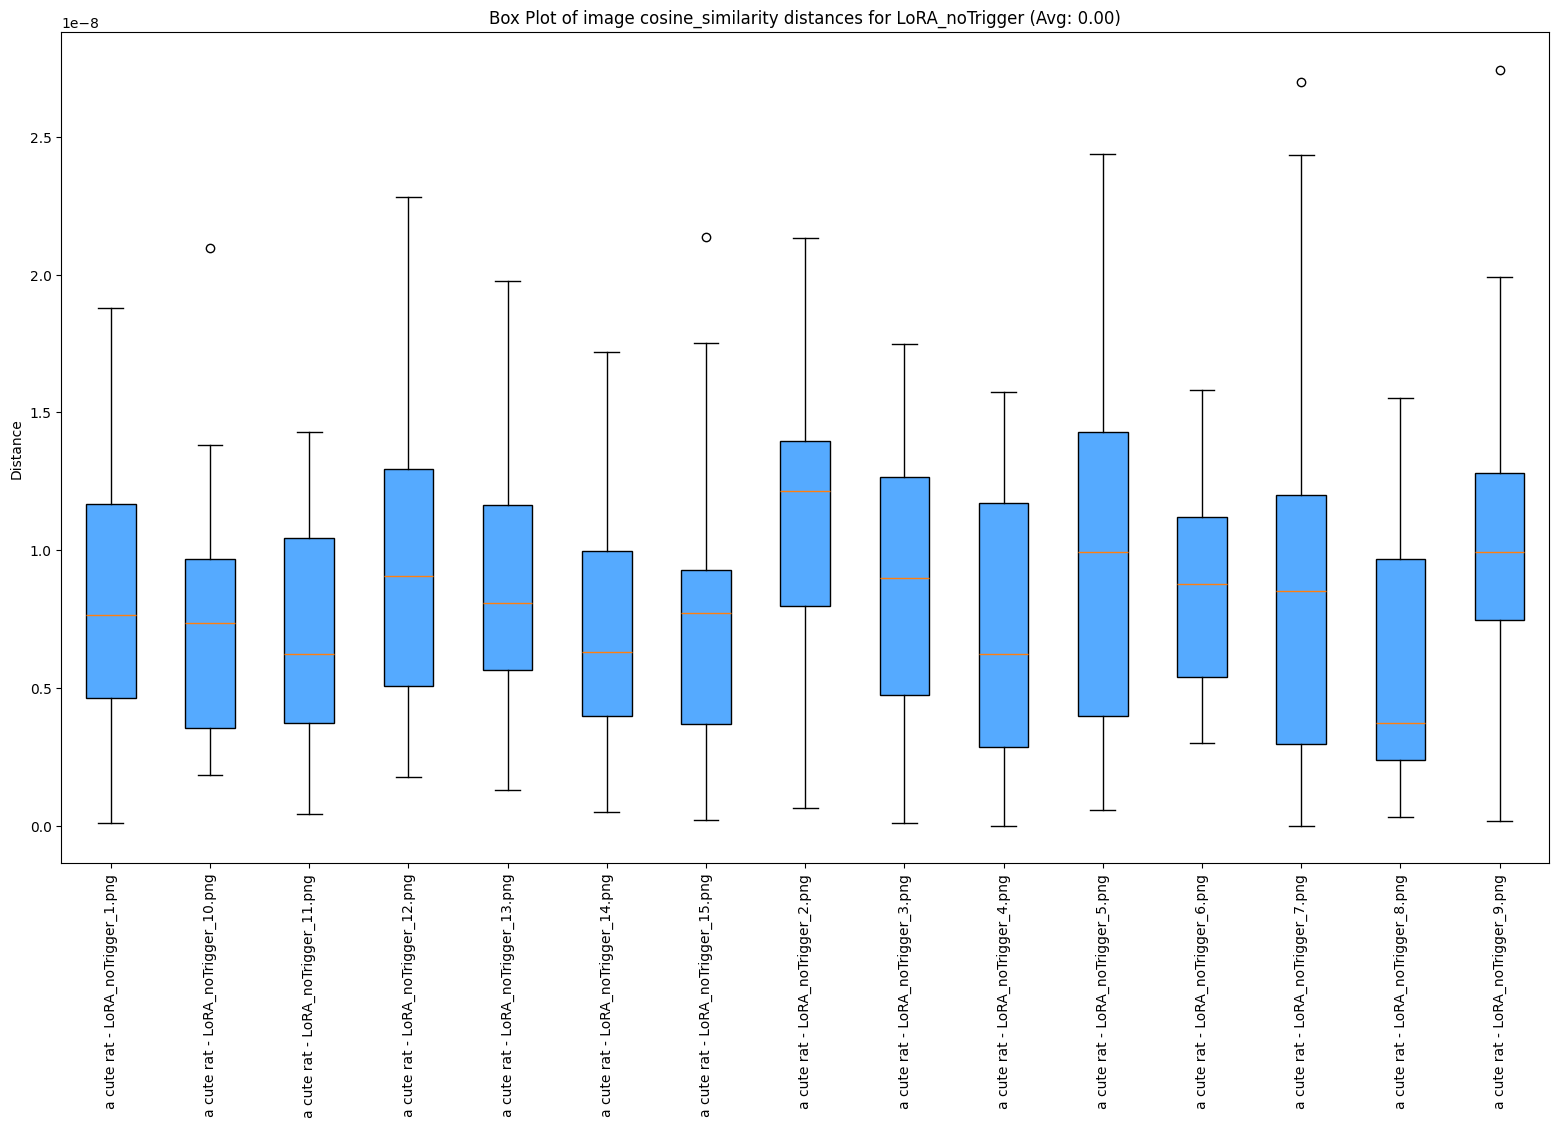

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


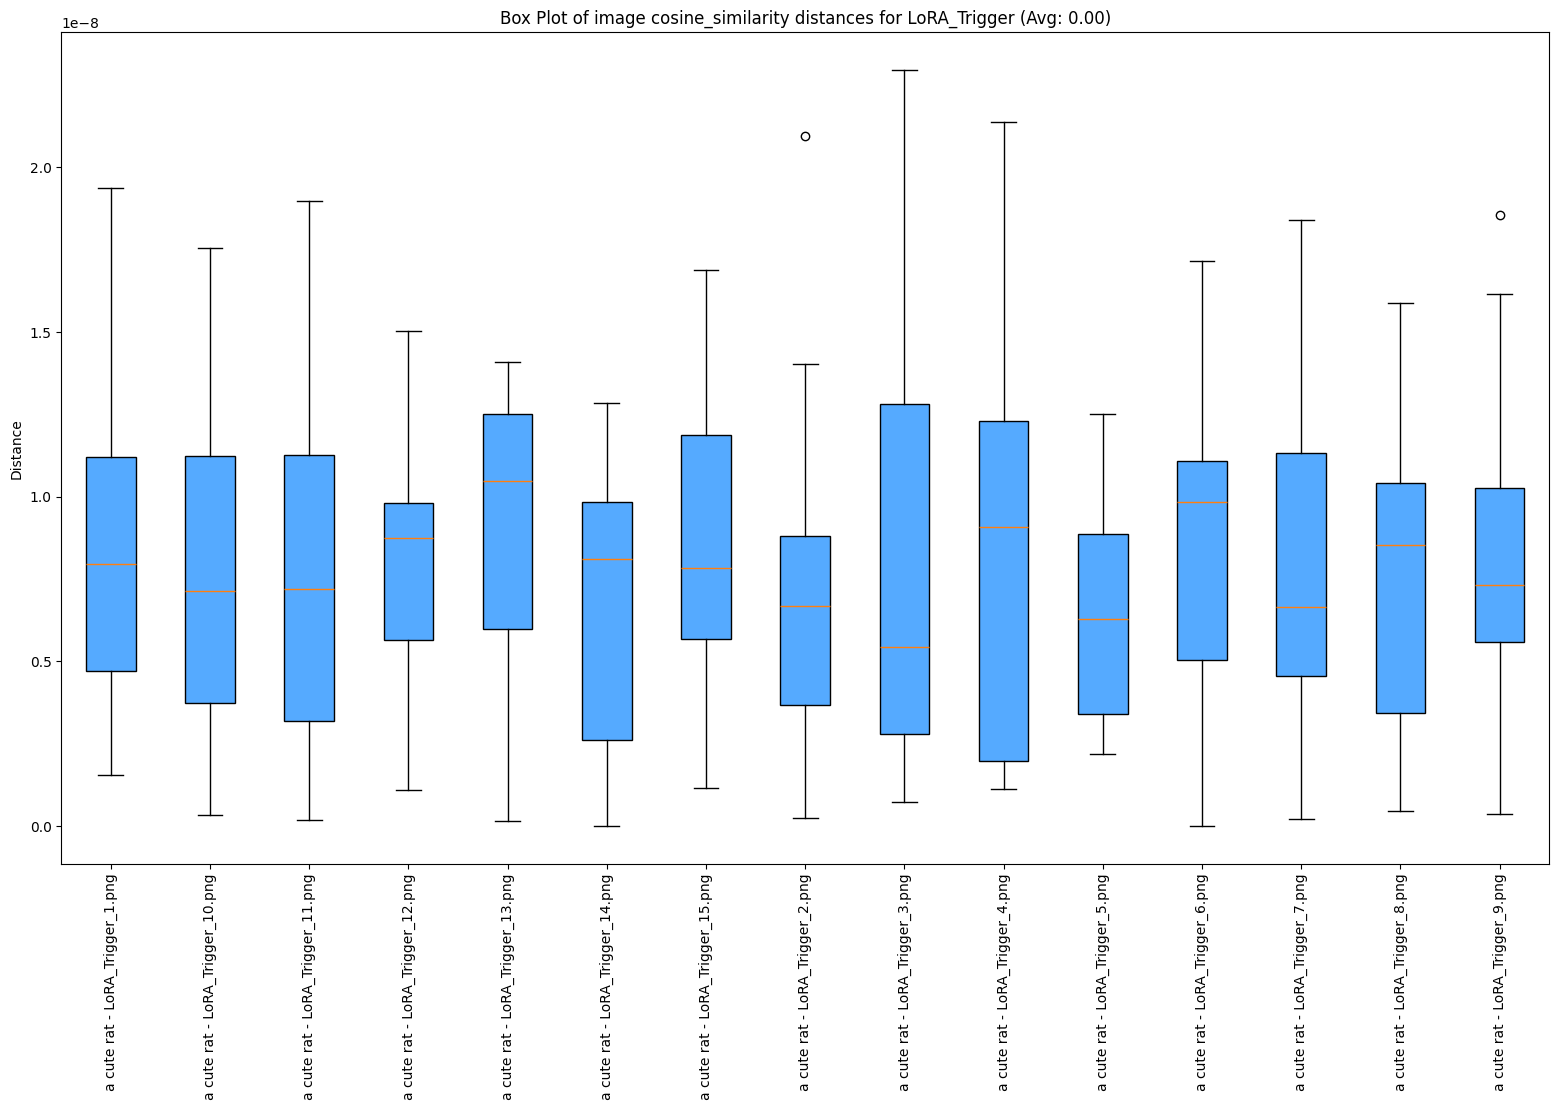

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


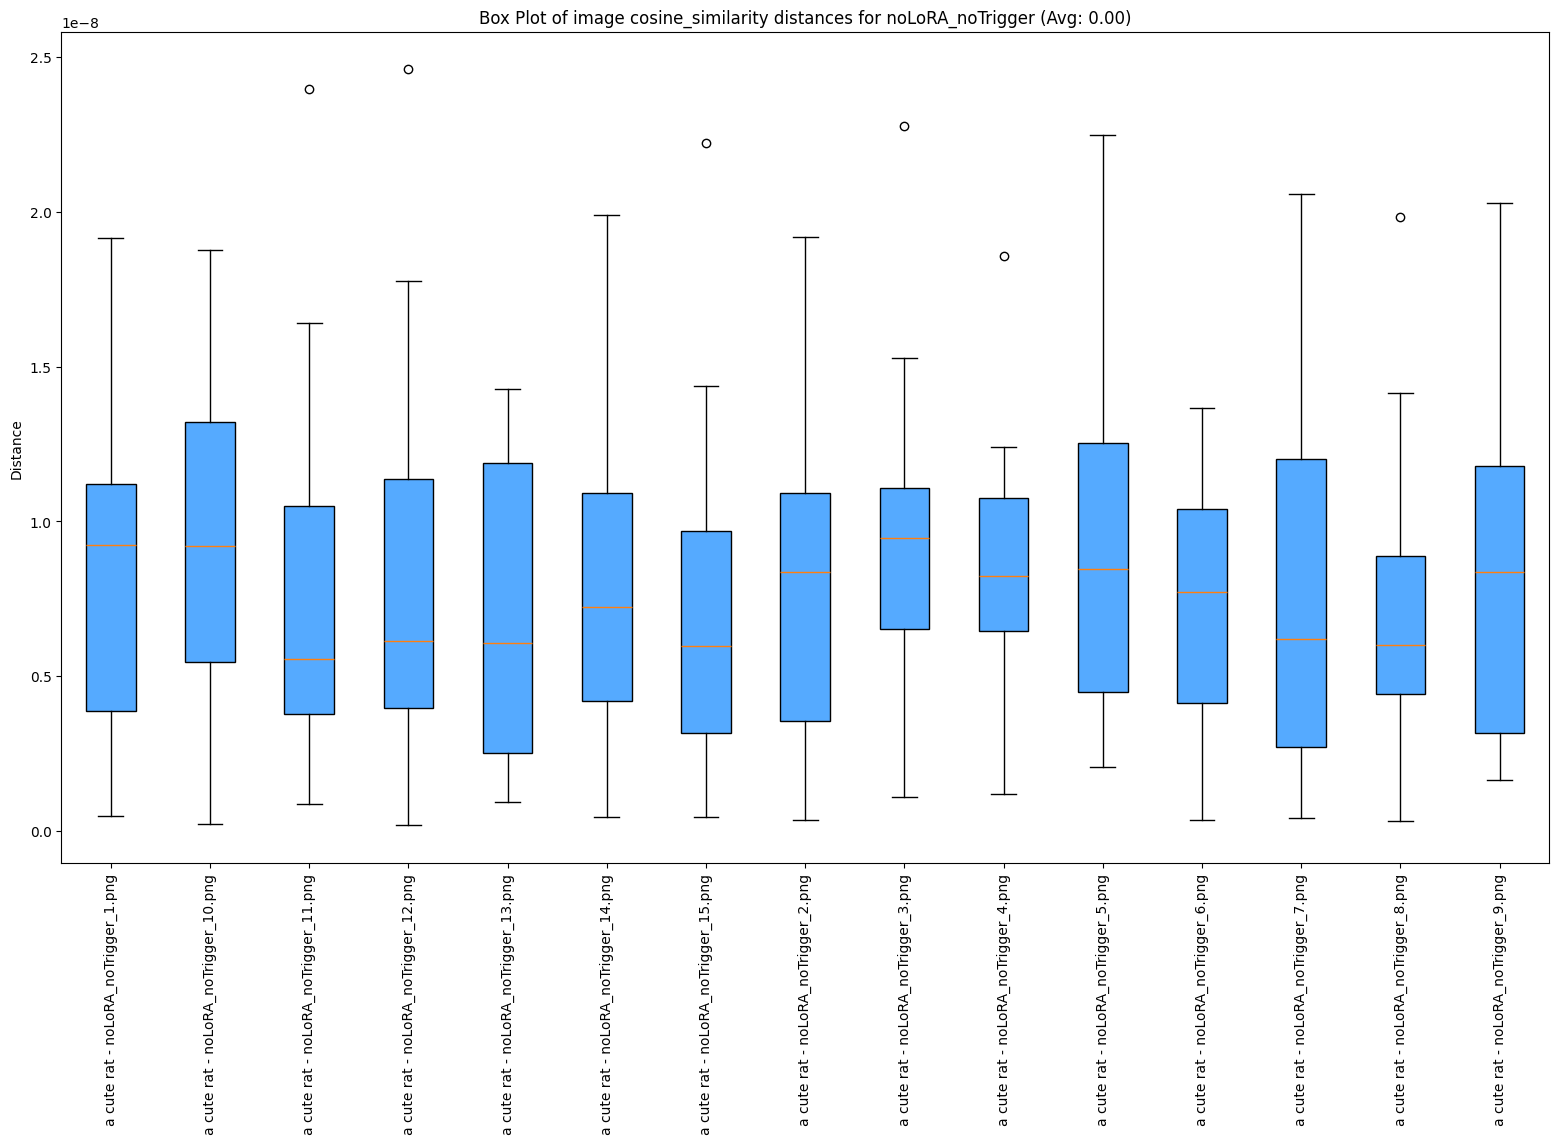

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


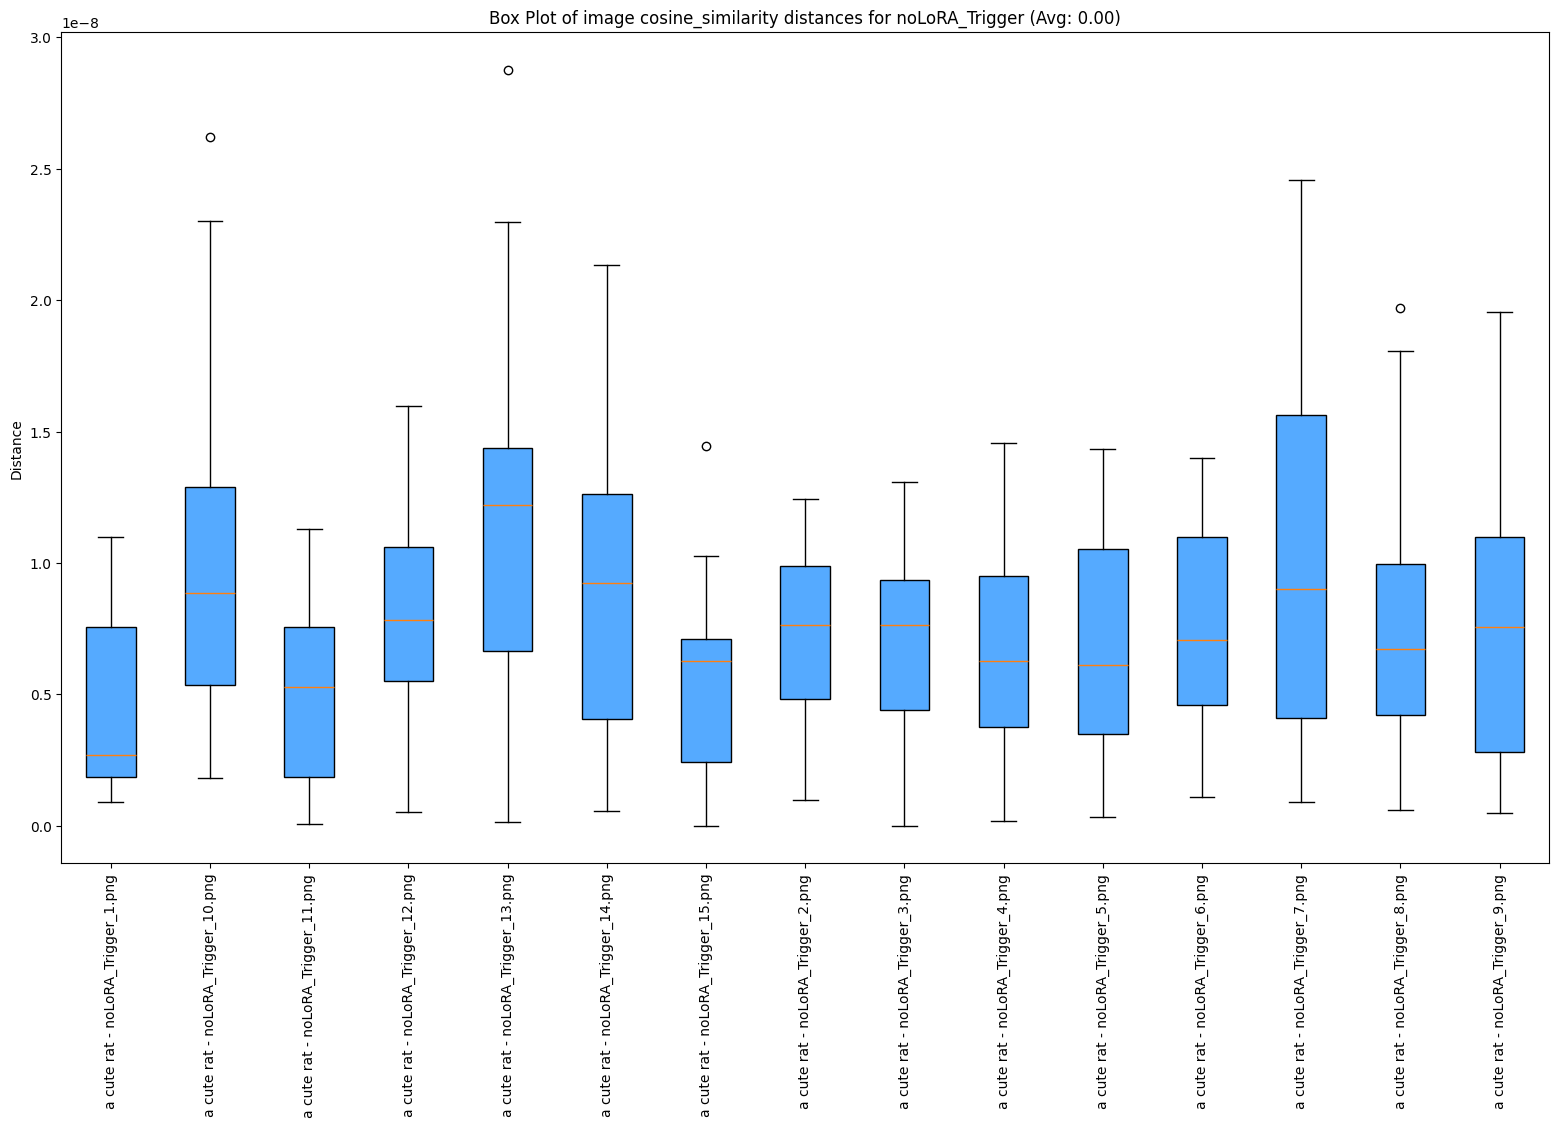

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


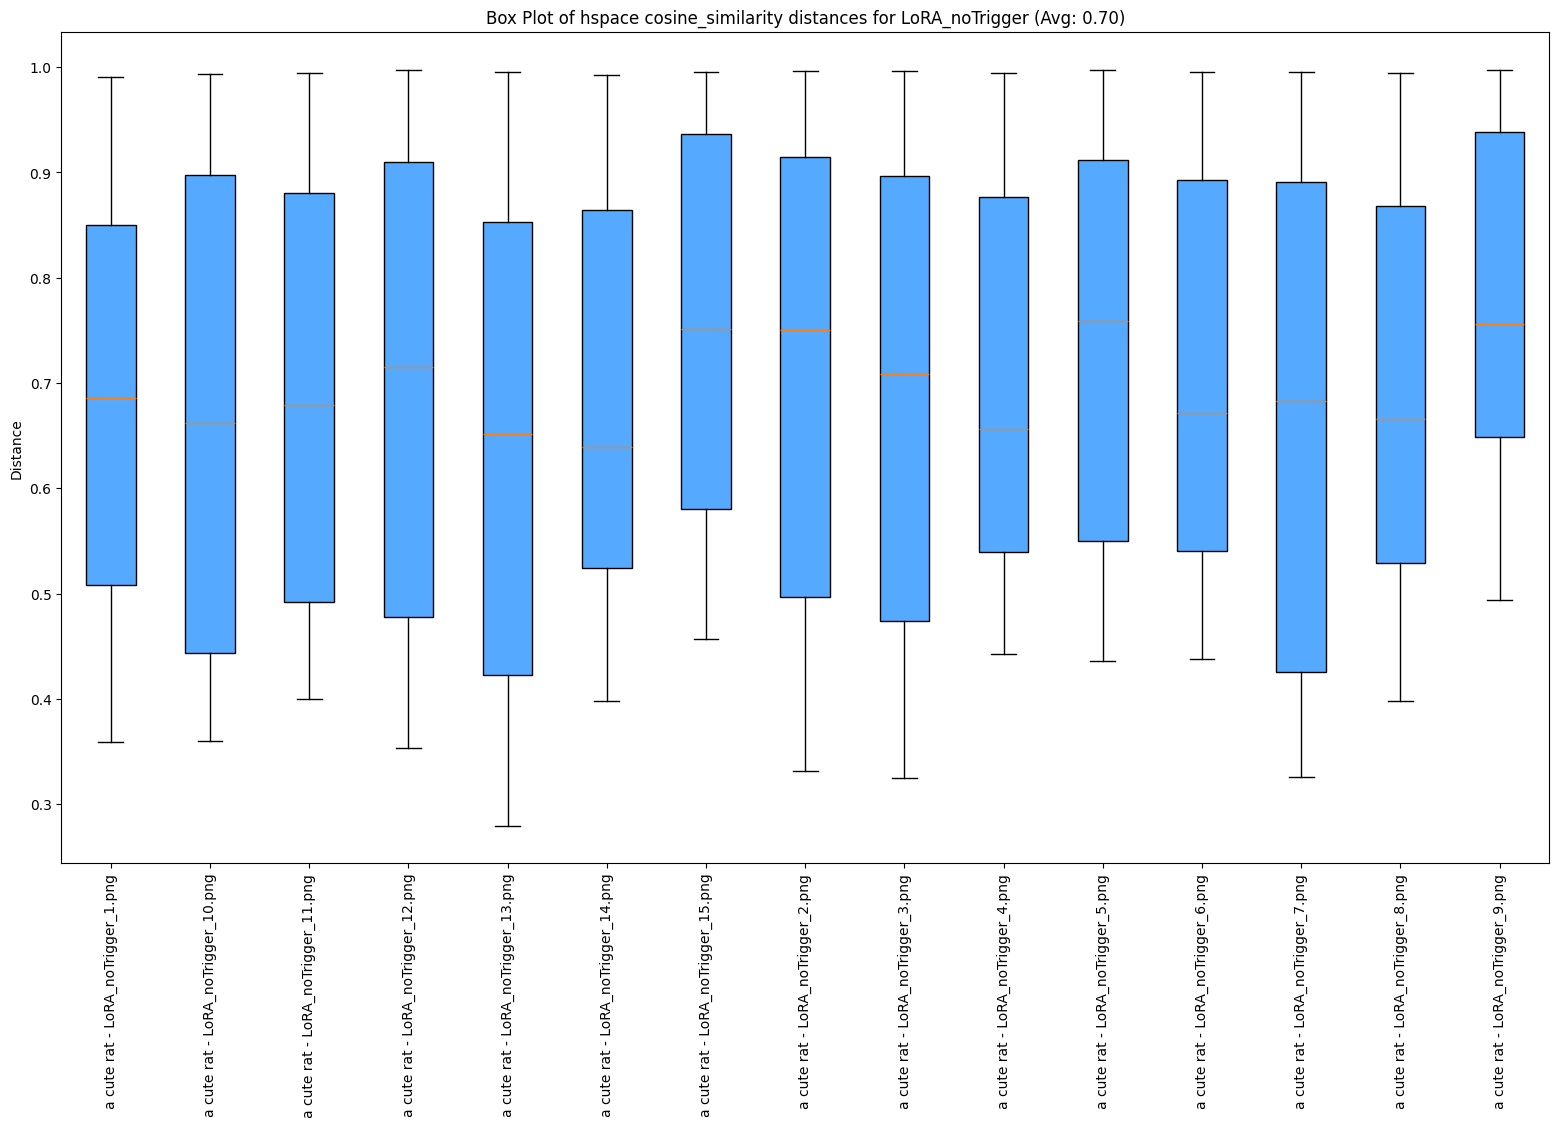

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


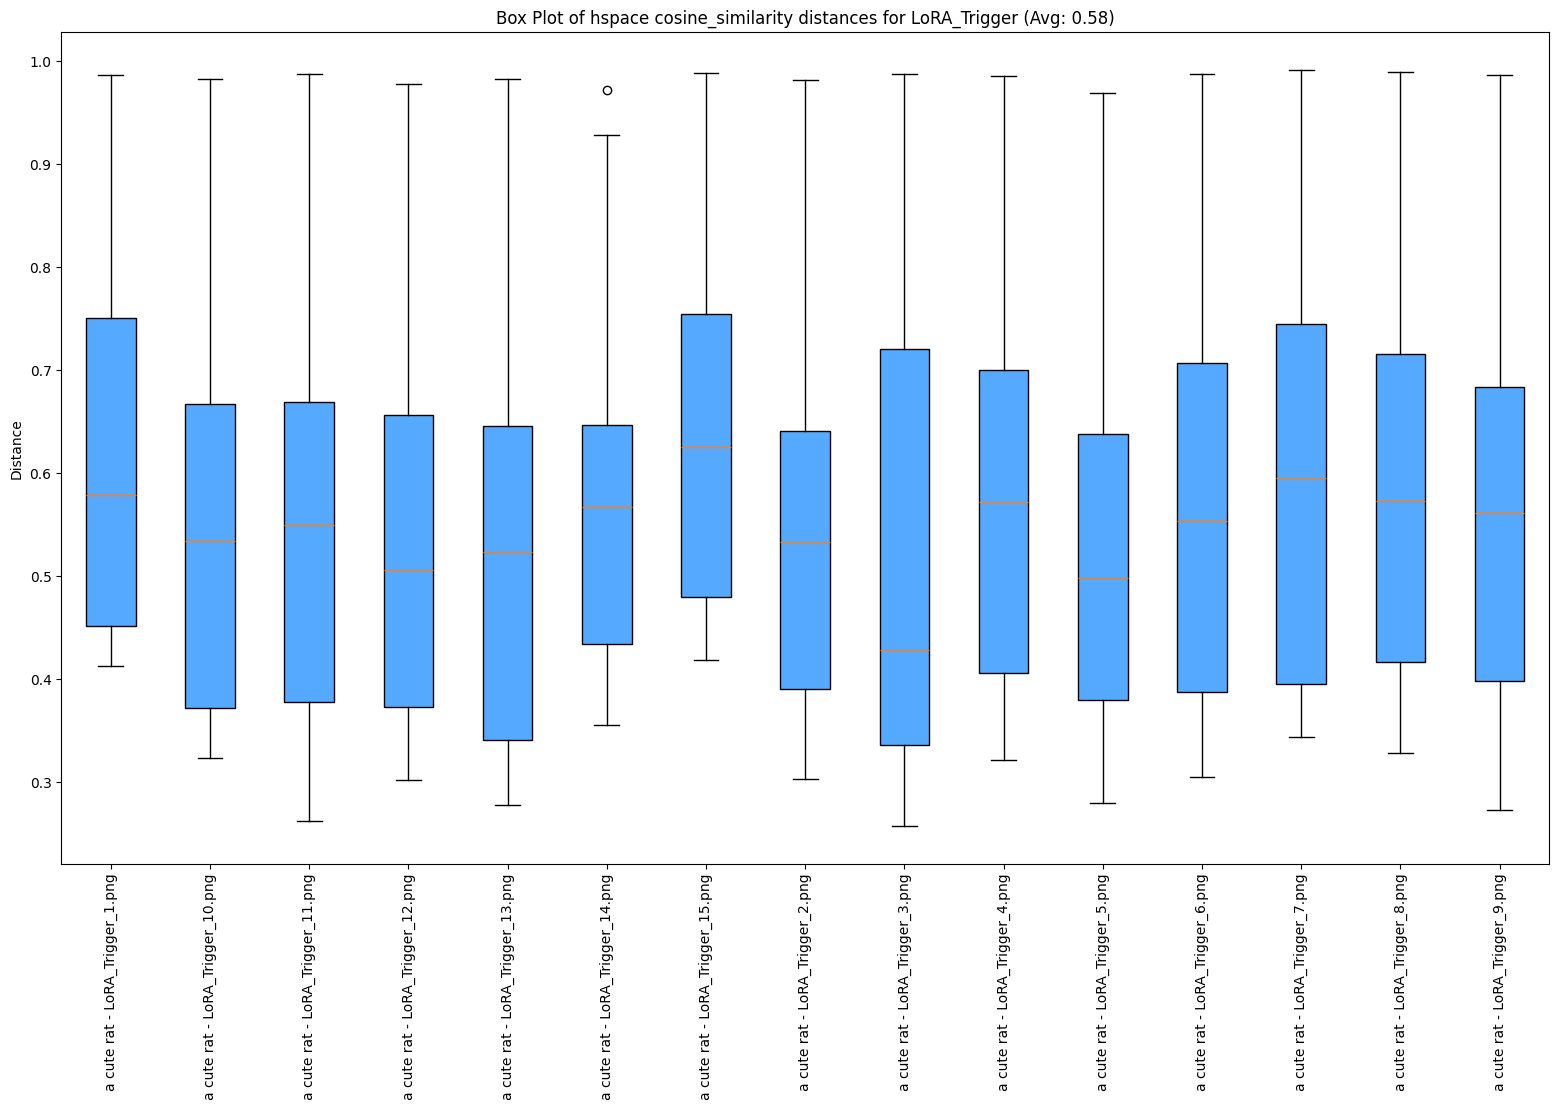

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


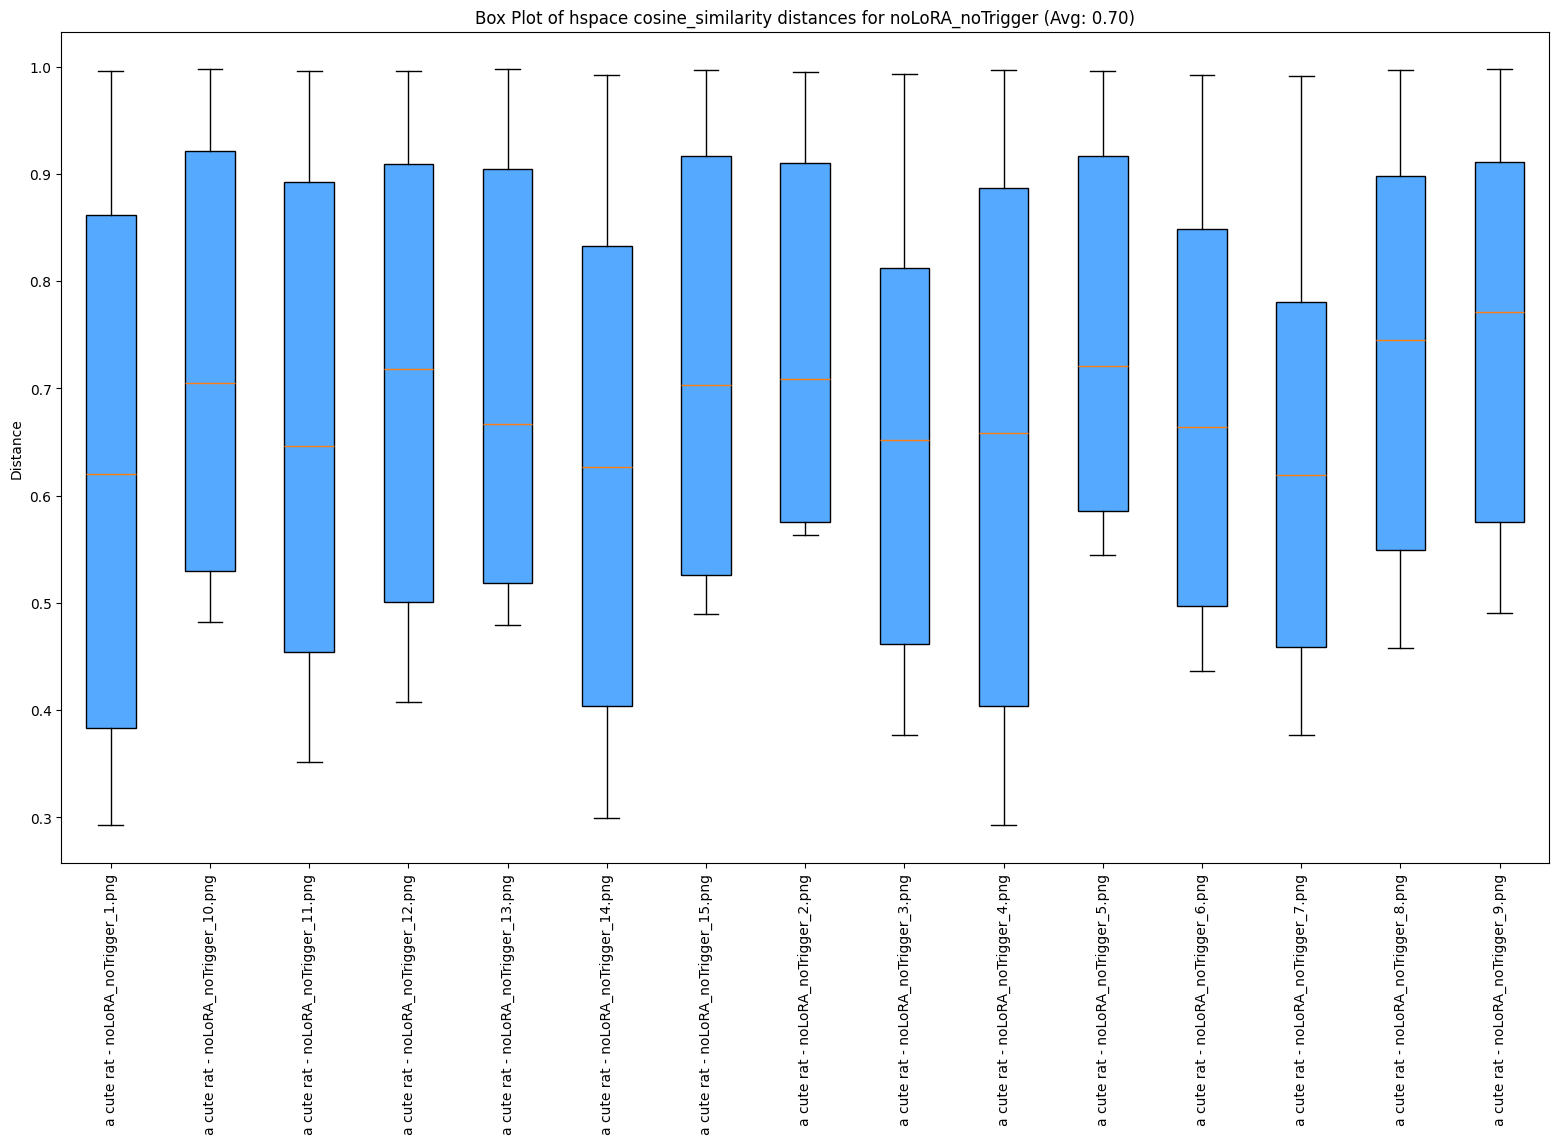

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2151108629.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


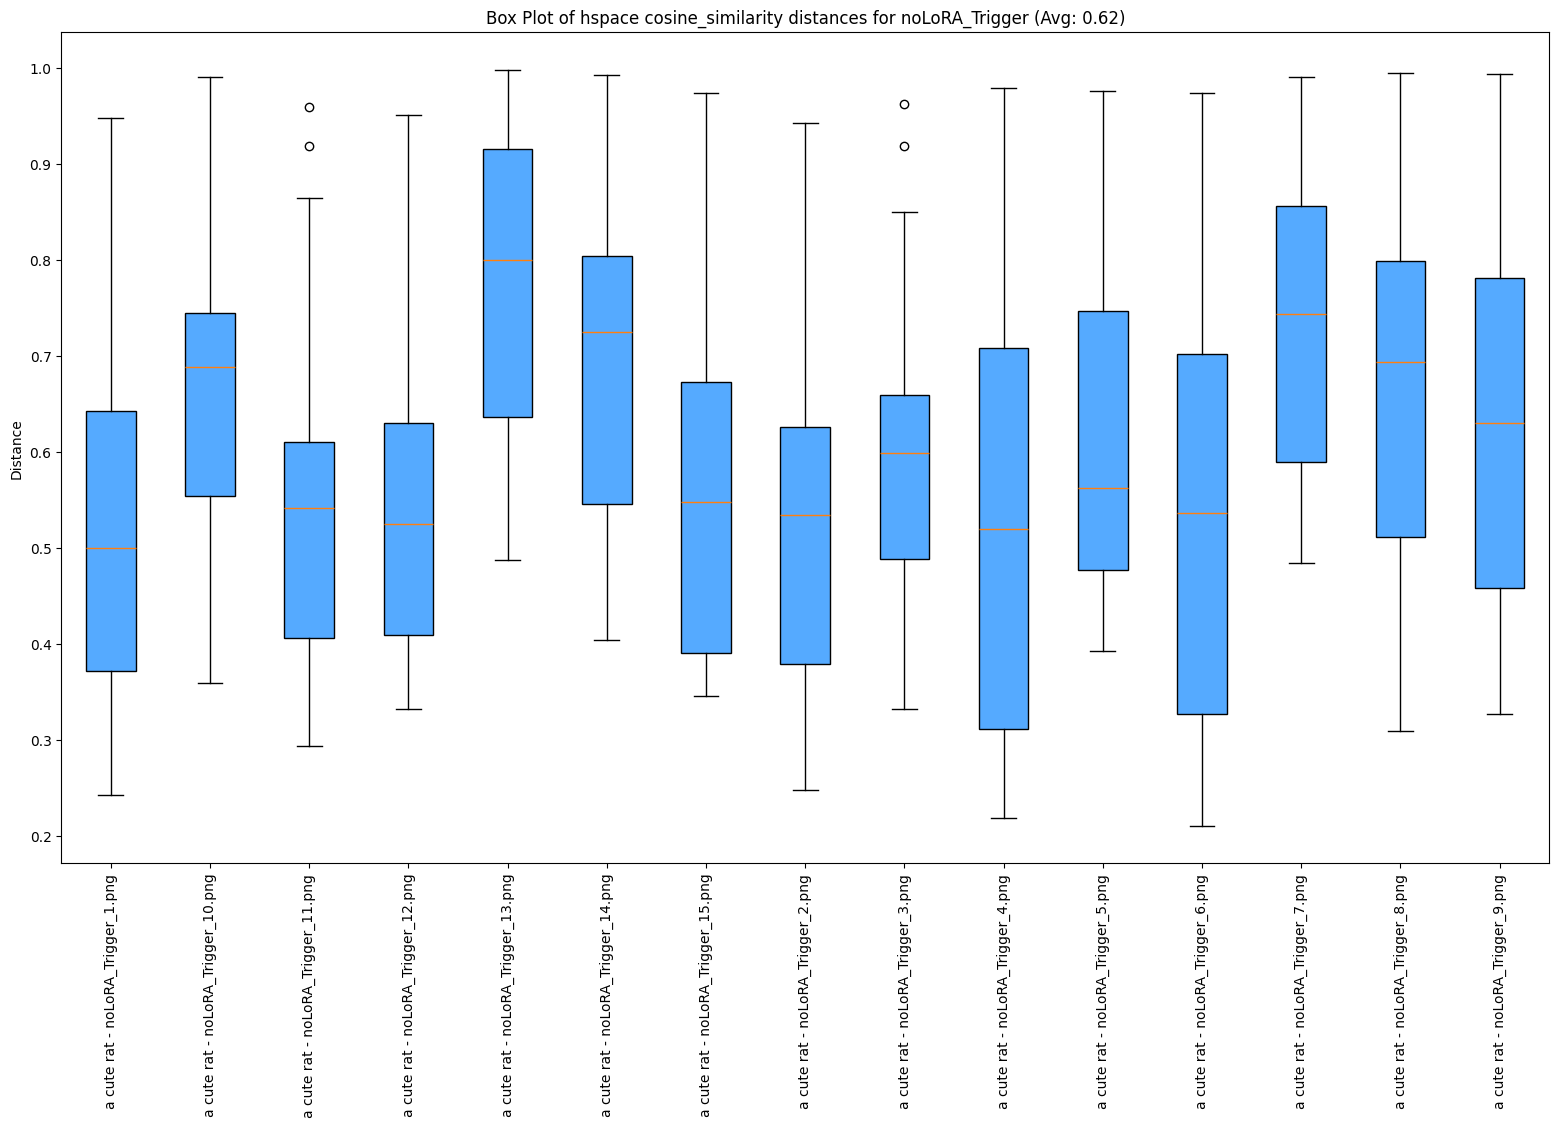

In [29]:

# plot L1 distance
plot_boxplot(anaysis_data["L1_step"], 'latent', "L1_step")
plot_boxplot(anaysis_data["L1_step"], 'image', "L1_step")
plot_boxplot(anaysis_data["L1_step"], 'hspace', "L1_step")

# plot frechet distance
plot_boxplot(anaysis_data["frechet_step"], 'latent', "frechet_step")
plot_boxplot(anaysis_data["frechet_step"], 'image', "frechet_step")
plot_boxplot(anaysis_data["frechet_step"], 'hspace', "frechet_step")

# plot cosine similarity
plot_boxplot(anaysis_data["cosine_similarity"], 'latent', "cosine_similarity")
plot_boxplot(anaysis_data["cosine_similarity"], 'image', "cosine_similarity")
plot_boxplot(anaysis_data["cosine_similarity"], 'hspace', "cosine_similarity")

In [ ]:
# see all step as a whole array

# calculate the L2 distance of latent, image, hspace between each image and the first image
# also calculate the L1 distance of hspace between each image and the first image

def calculate_euclidean_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = euclidean(experiment_data[prefix][prompt][image_name][key].flatten(), experiment_data[prefix][prompt][first_image_name][key].flatten())
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

In [ ]:
# calculate the frechet distance of latent, image, hspace between each image and the first image
def calculate_frechet_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = frechet_distance(experiment_data[prefix][prompt][image_name][key], experiment_data[prefix][prompt][first_image_name][key])
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

In [ ]:
# calculate the L1 distance of latent, image, hspace between each image and the first image
def calculate_L1_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = np.sum(np.abs(experiment_data[prefix][prompt][image_name][key].flatten() - experiment_data[prefix][prompt][first_image_name][key].flatten()))
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data


In [13]:
anaysis_data["L2_whole"] = calculate_euclidean_distance_whole_together(experiment_data)
anaysis_data["frechet_whole"] = calculate_frechet_distance_whole_together(experiment_data)
anaysis_data["L1_whole"] = calculate_L1_distance_whole_together(experiment_data)

LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png
LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png
LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png


In [14]:
print(anaysis_data["L2_whole"])

{'LoRA_noTrigger': {'a cute rat': {'LoRA_noTrigger_1.png': {'latent': [np.float32(3120.8962)], 'image': [np.float64(420993.0250799887)], 'hspace': [np.float32(4762.5894)]}, 'LoRA_noTrigger_10.png': {'latent': [np.float32(3100.4907)], 'image': [np.float64(455211.12736070063)], 'hspace': [np.float32(4795.292)]}, 'LoRA_noTrigger_11.png': {'latent': [np.float32(3061.2546)], 'image': [np.float64(445252.0567869395)], 'hspace': [np.float32(4729.6724)]}, 'LoRA_noTrigger_12.png': {'latent': [np.float32(2827.081)], 'image': [np.float64(477151.25569362176)], 'hspace': [np.float32(4670.86)]}, 'LoRA_noTrigger_13.png': {'latent': [np.float32(3018.1758)], 'image': [np.float64(511162.5785041389)], 'hspace': [np.float32(5102.091)]}, 'LoRA_noTrigger_14.png': {'latent': [np.float32(3224.8843)], 'image': [np.float64(451940.17423990974)], 'hspace': [np.float32(4705.44)]}, 'LoRA_noTrigger_15.png': {'latent': [np.float32(2840.816)], 'image': [np.float64(416020.193246674)], 'hspace': [np.float32(4225.5464)]},

In [19]:
# calculate the average distance of different distance type、different prefix、different prompt、different distance type
def calculate_average_distance(anaysis_data):
    average_data = {}
    for distance_type in anaysis_data.keys():
        average_data[distance_type] = {}
        for prefix in anaysis_data[distance_type].keys():
            average_data[distance_type][prefix] = {}
            for prompt in anaysis_data[distance_type][prefix].keys():
                average_data[distance_type][prefix][prompt] = {}
                for key in ["latent", "image", "hspace"]:
                    average_data[distance_type][prefix][prompt][key] = np.mean([np.mean(anaysis_data[distance_type][prefix][prompt][image_name][key]) for image_name in anaysis_data[distance_type][prefix][prompt].keys()])
    return average_data

average_data = calculate_average_distance(anaysis_data)

for distance_type in average_data.keys():
    print(f"Distance Type: {distance_type}")
    for prefix in average_data[distance_type].keys():
        print(f"Prefix: {prefix}")
        for prompt in average_data[distance_type][prefix].keys():
            print(f"Prompt: {prompt}")
            for key in average_data[distance_type][prefix][prompt].keys():
                print(f"Key: {key} Avg: {average_data[distance_type][prefix][prompt][key]:.2f}")
            print()
        print() 




Distance Type: L2_step
Prefix: LoRA_noTrigger
Prompt: a cute rat
Key: latent Avg: 675.77
Key: image Avg: 108722.71
Key: hspace Avg: 939.77


Prefix: LoRA_Trigger
Prompt: a cute rat
Key: latent Avg: 873.19
Key: image Avg: 100701.47
Key: hspace Avg: 1192.06


Prefix: noLoRA_noTrigger
Prompt: a cute rat
Key: latent Avg: 707.77
Key: image Avg: 120150.43
Key: hspace Avg: 955.15


Prefix: noLoRA_Trigger
Prompt: a cute rat
Key: latent Avg: 883.35
Key: image Avg: 102615.54
Key: hspace Avg: 1098.38


Distance Type: frechet_step
Distance Type: L1_step
Distance Type: L2_whole
Prefix: LoRA_noTrigger
Prompt: a cute rat
Key: latent Avg: 2951.28
Key: image Avg: 477290.61
Key: hspace Avg: 4638.24


Prefix: LoRA_Trigger
Prompt: a cute rat
Key: latent Avg: 3811.13
Key: image Avg: 441163.63
Key: hspace Avg: 5580.90


Prefix: noLoRA_noTrigger
Prompt: a cute rat
Key: latent Avg: 3091.99
Key: image Avg: 525985.03
Key: hspace Avg: 4706.75


Prefix: noLoRA_Trigger
Prompt: a cute rat
Key: latent Avg: 3852.49
K

In [48]:
import matplotlib.pyplot as plt

def calculate_distance_over_time(experiment_data, distance_func):
    analysis_data = {}
    for prefix in experiment_data.keys():
        analysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            analysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    continue
                analysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(len(experiment_data[prefix][prompt][image_name][key])):
                        distance = distance_func(experiment_data[prefix][prompt][image_name][key][i], experiment_data[prefix][prompt][first_image_name][key][i])
                        analysis_data[prefix][prompt][image_name][key].append(distance)
    return analysis_data


In [49]:

def plot_distance_over_time(analysis_data, key, distance_type="L2_step"):
    colors = {'LoRA_noTrigger': '#FF9999', 'LoRA_Trigger': '#99FF99', 'noLoRA_noTrigger': '#9999FF', 'noLoRA_Trigger': '#FFCC99'}
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            plt.figure(figsize=(19.2, 10.8))
            for image_name in analysis_data[prefix][prompt].keys():
                distances = analysis_data[prefix][prompt][image_name][key]
                plt.plot(range(len(distances)), distances, label=image_name, color=colors[prefix])
            plt.xlabel('Time Step')
            plt.ylabel('Distance')
            plt.title(f'{distance_type} Distance Over Time for {prefix} - {prompt} ({key})')
            plt.legend()
            plt.show()


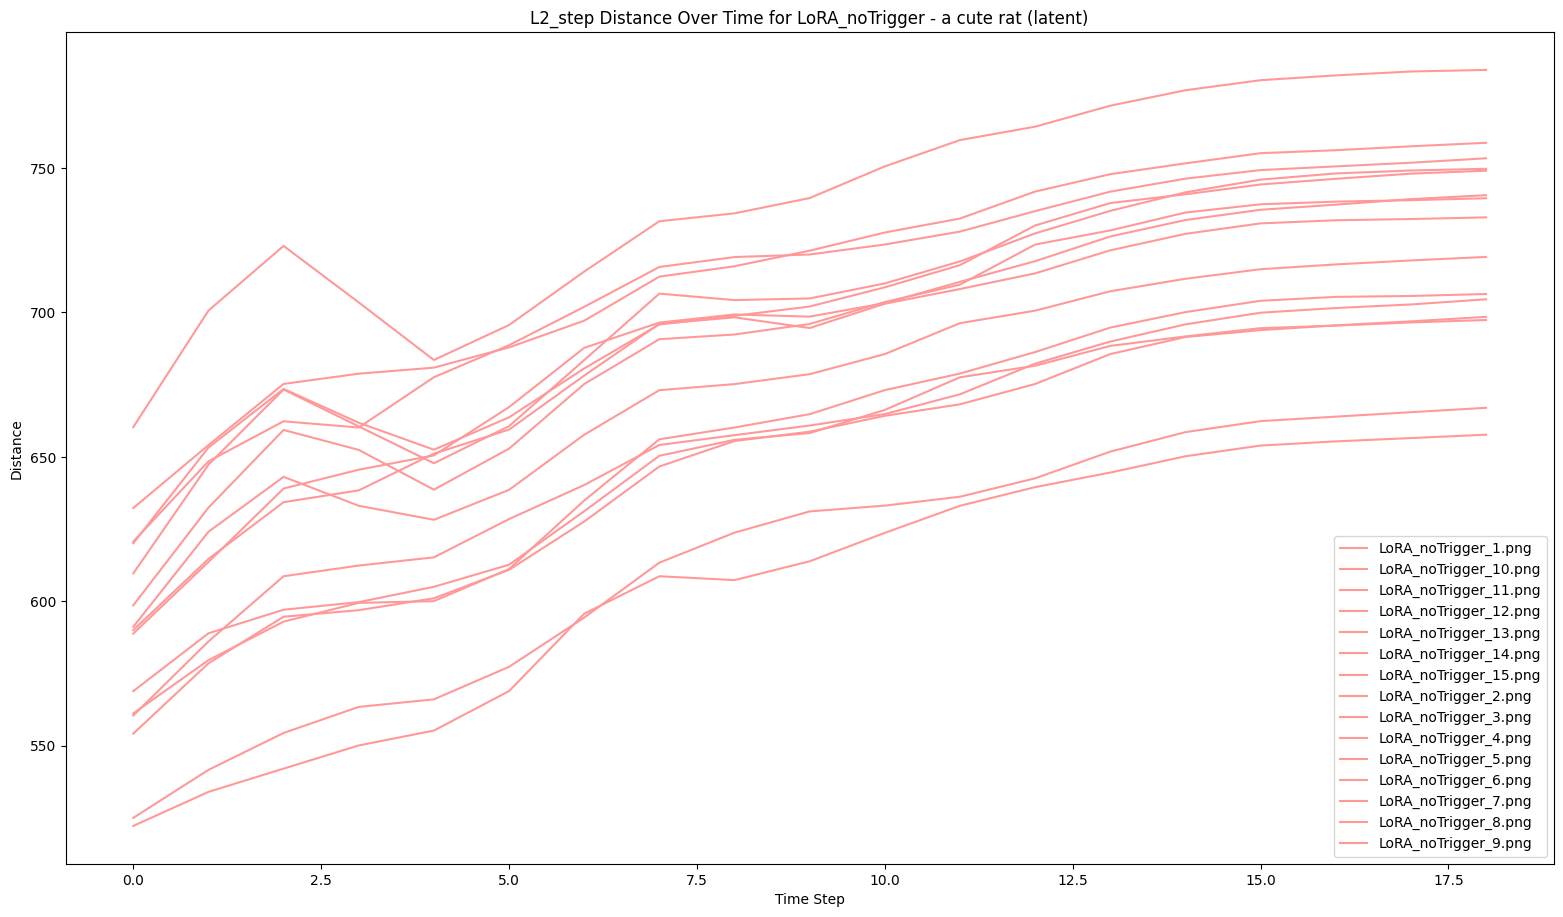

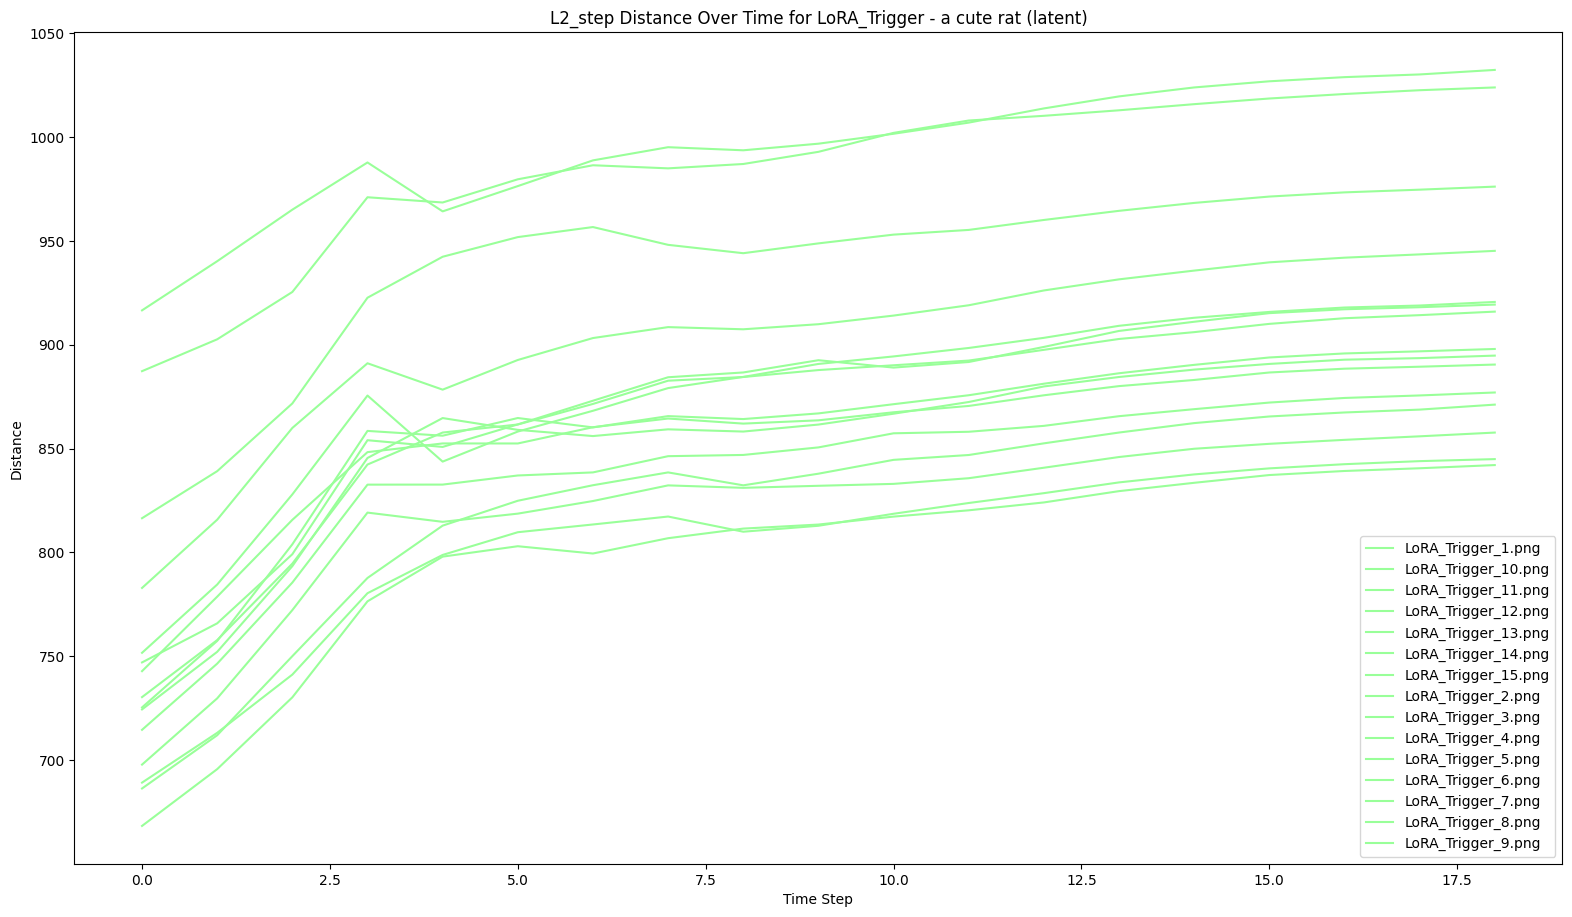

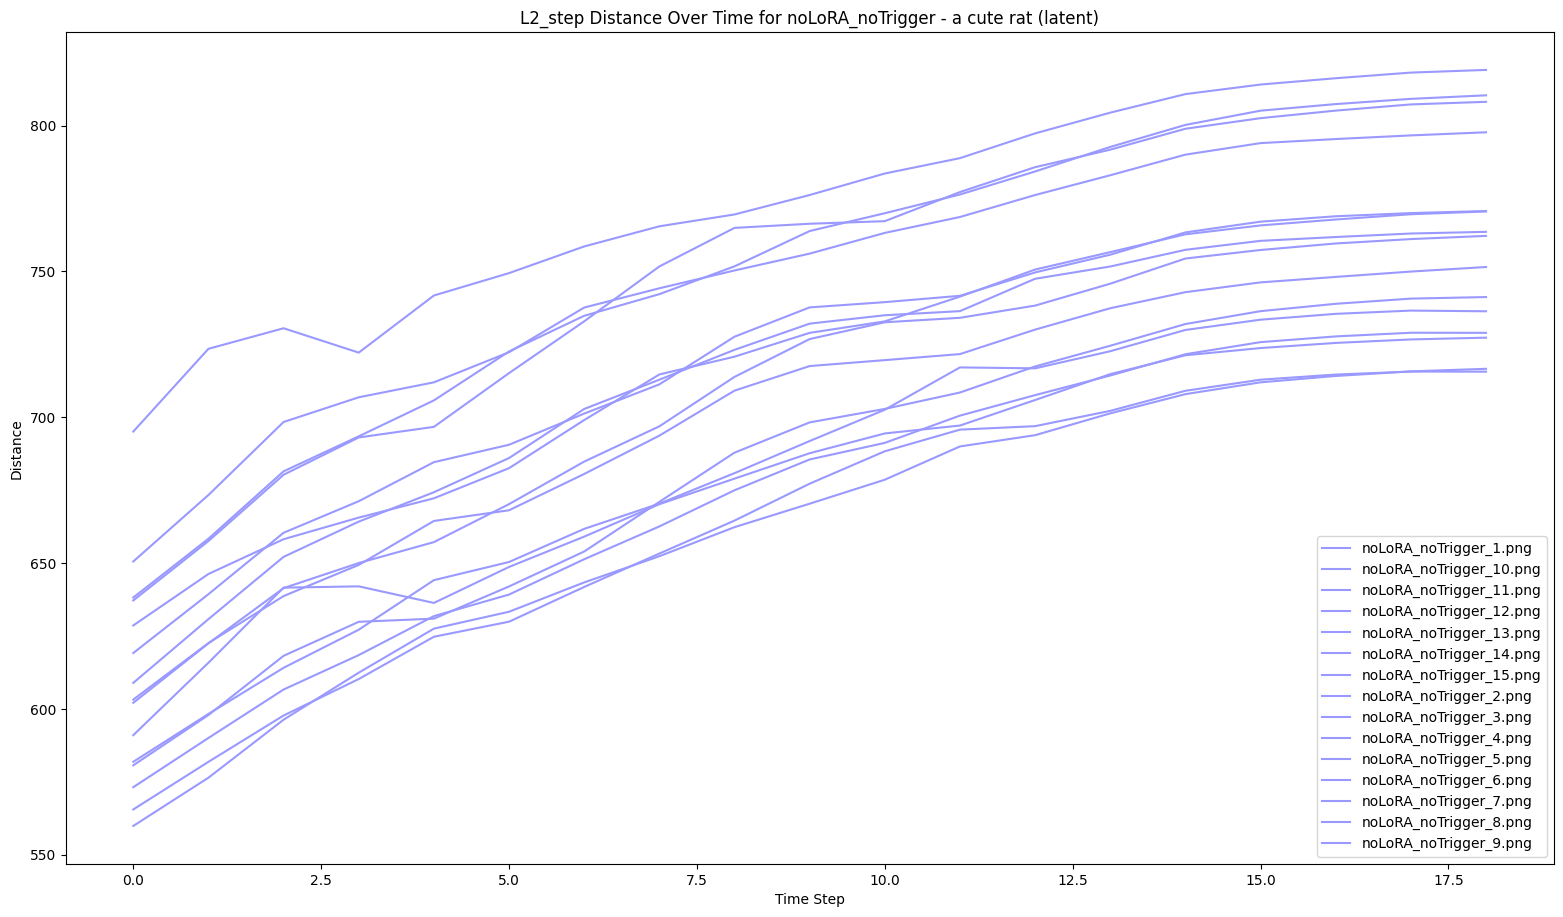

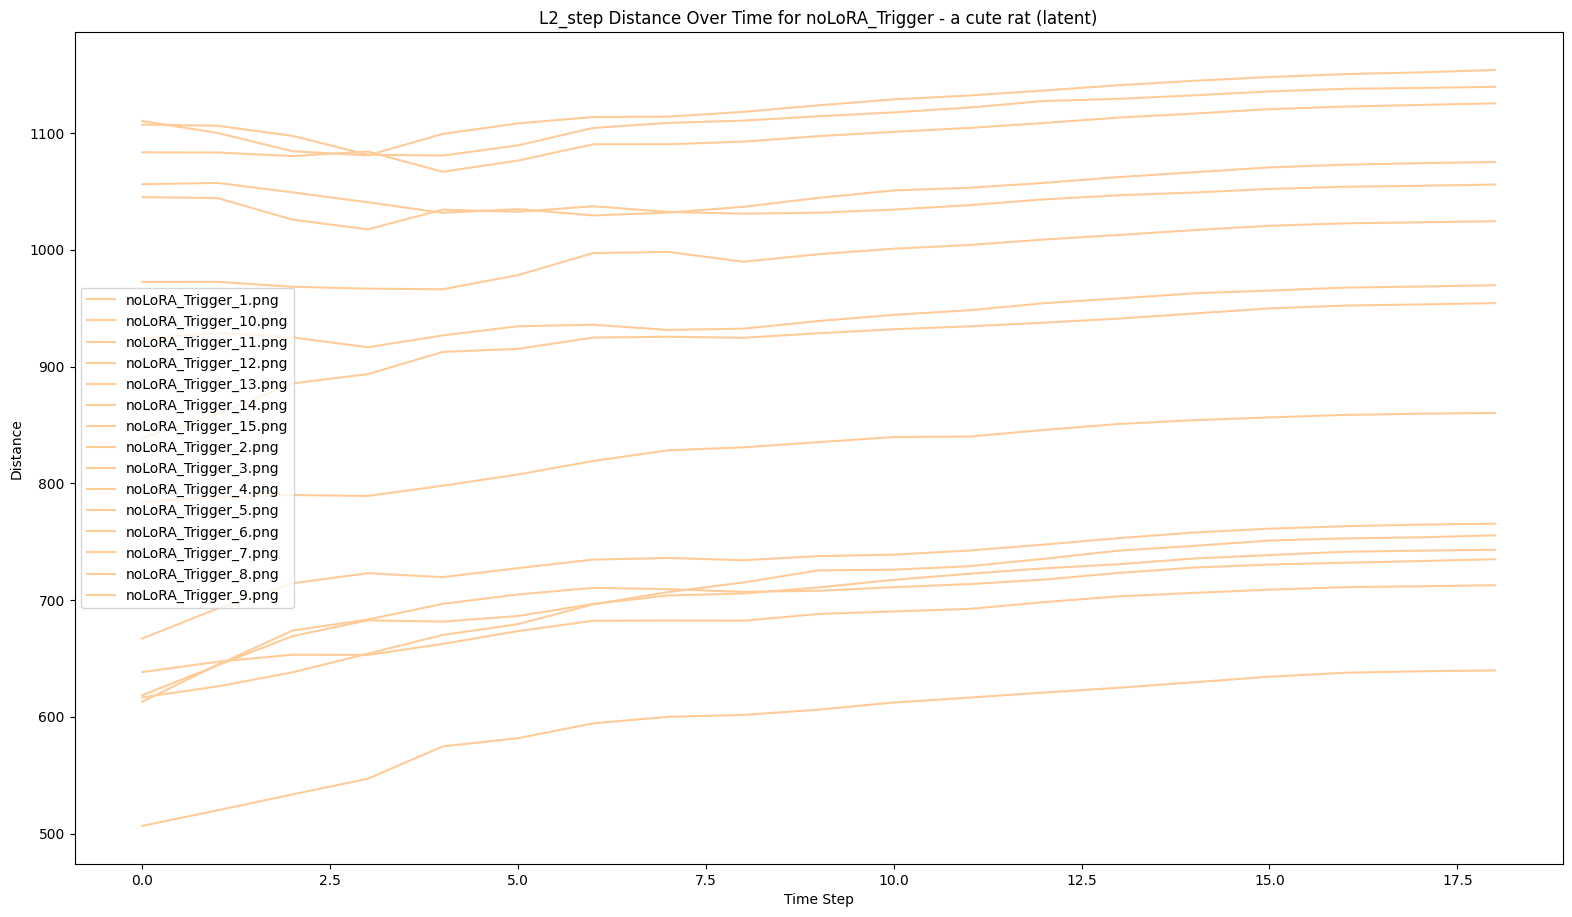

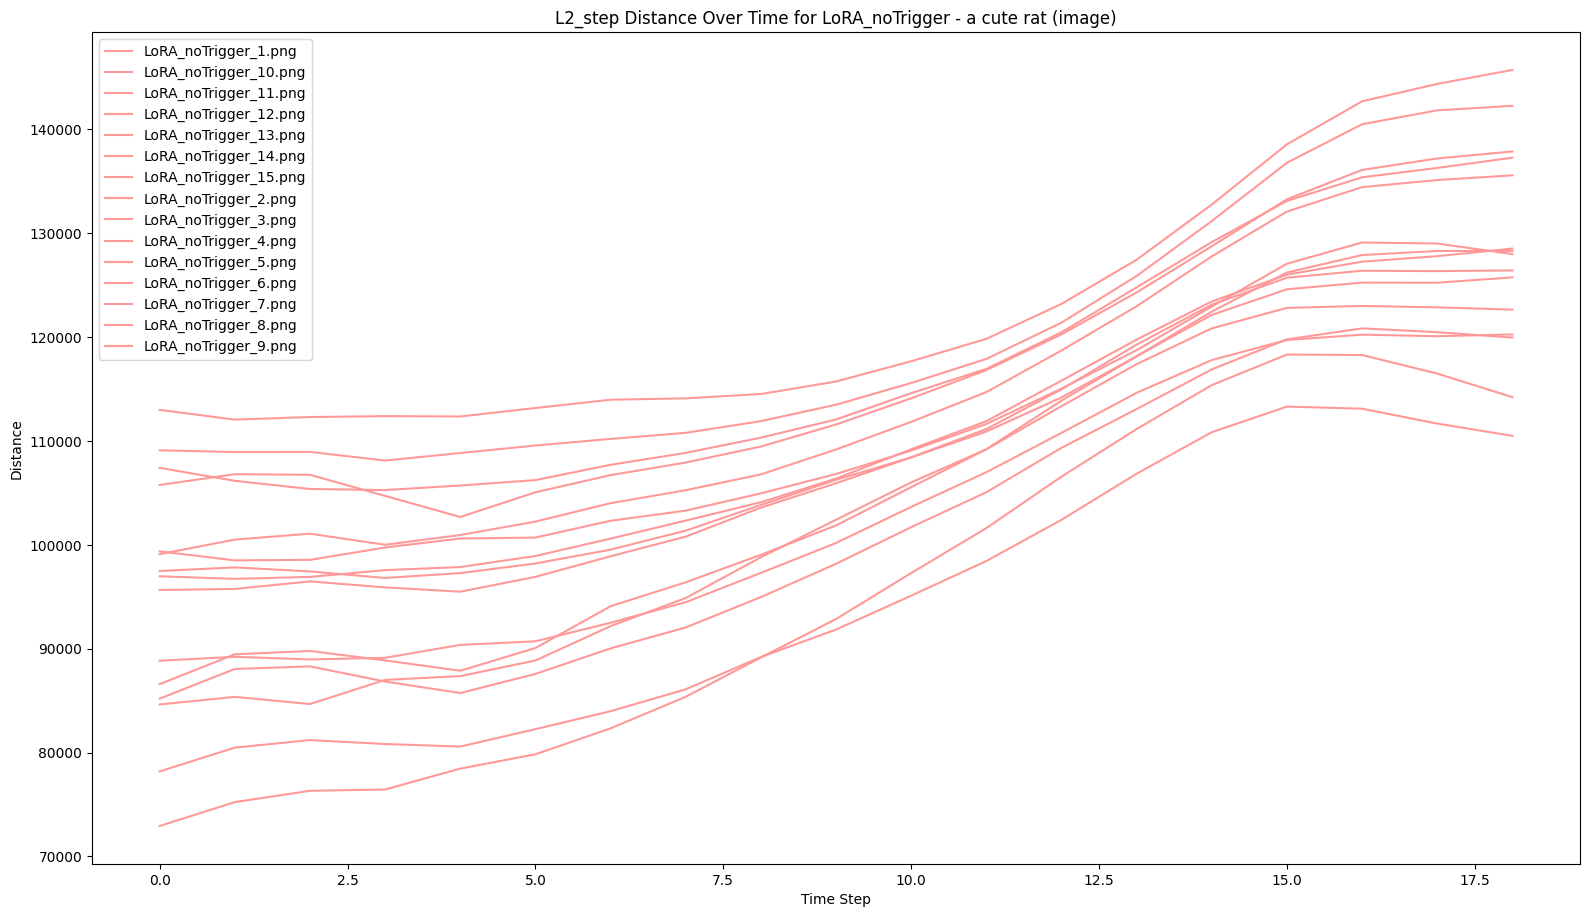

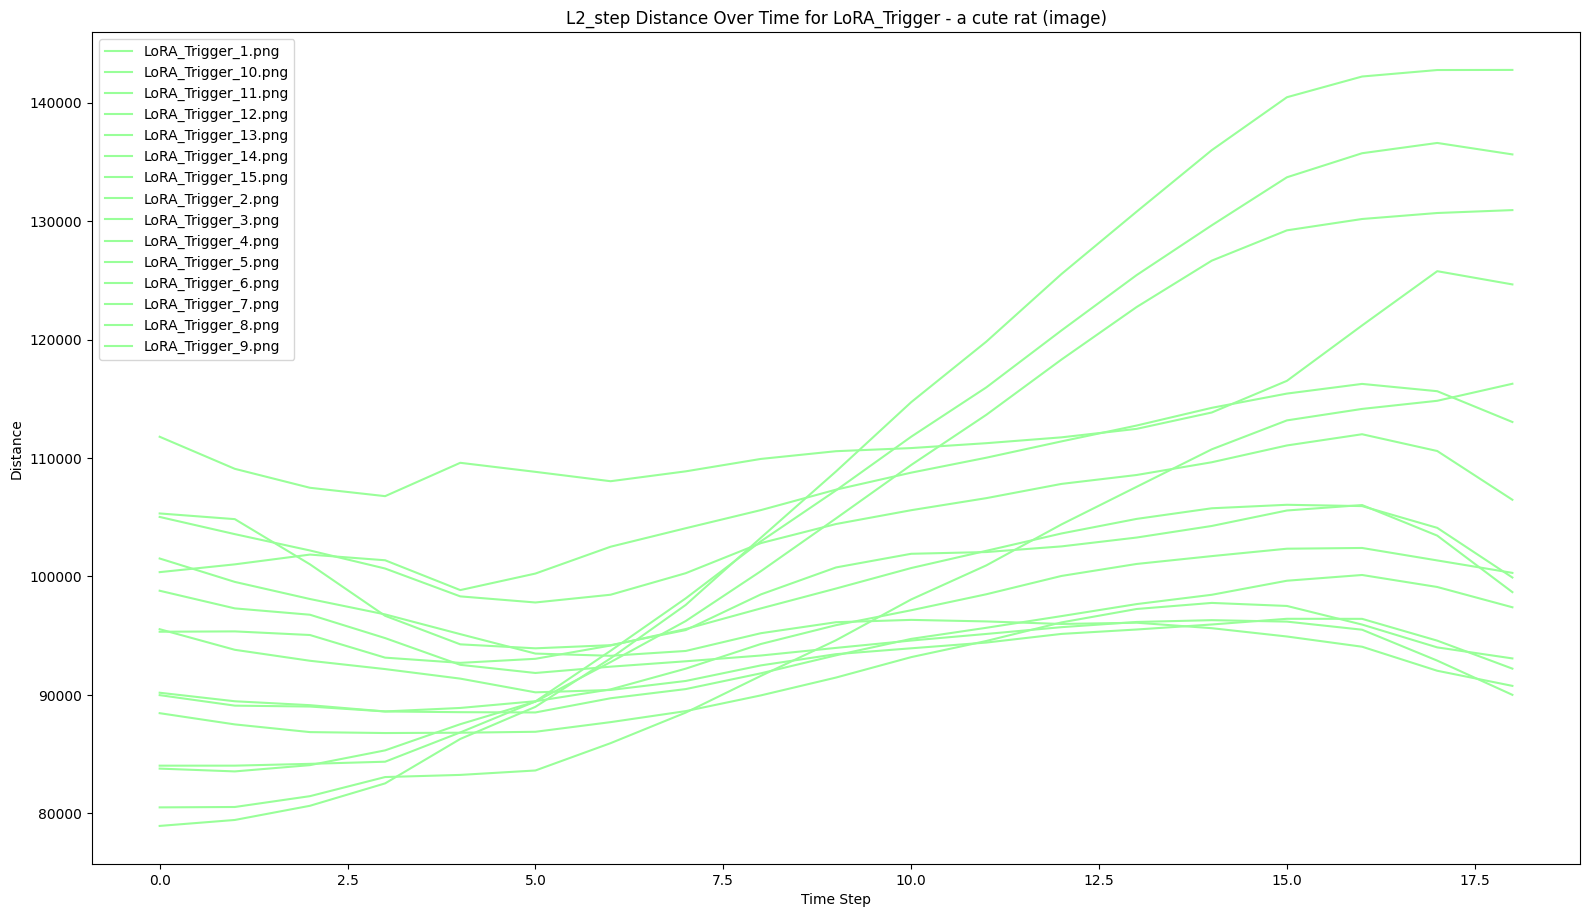

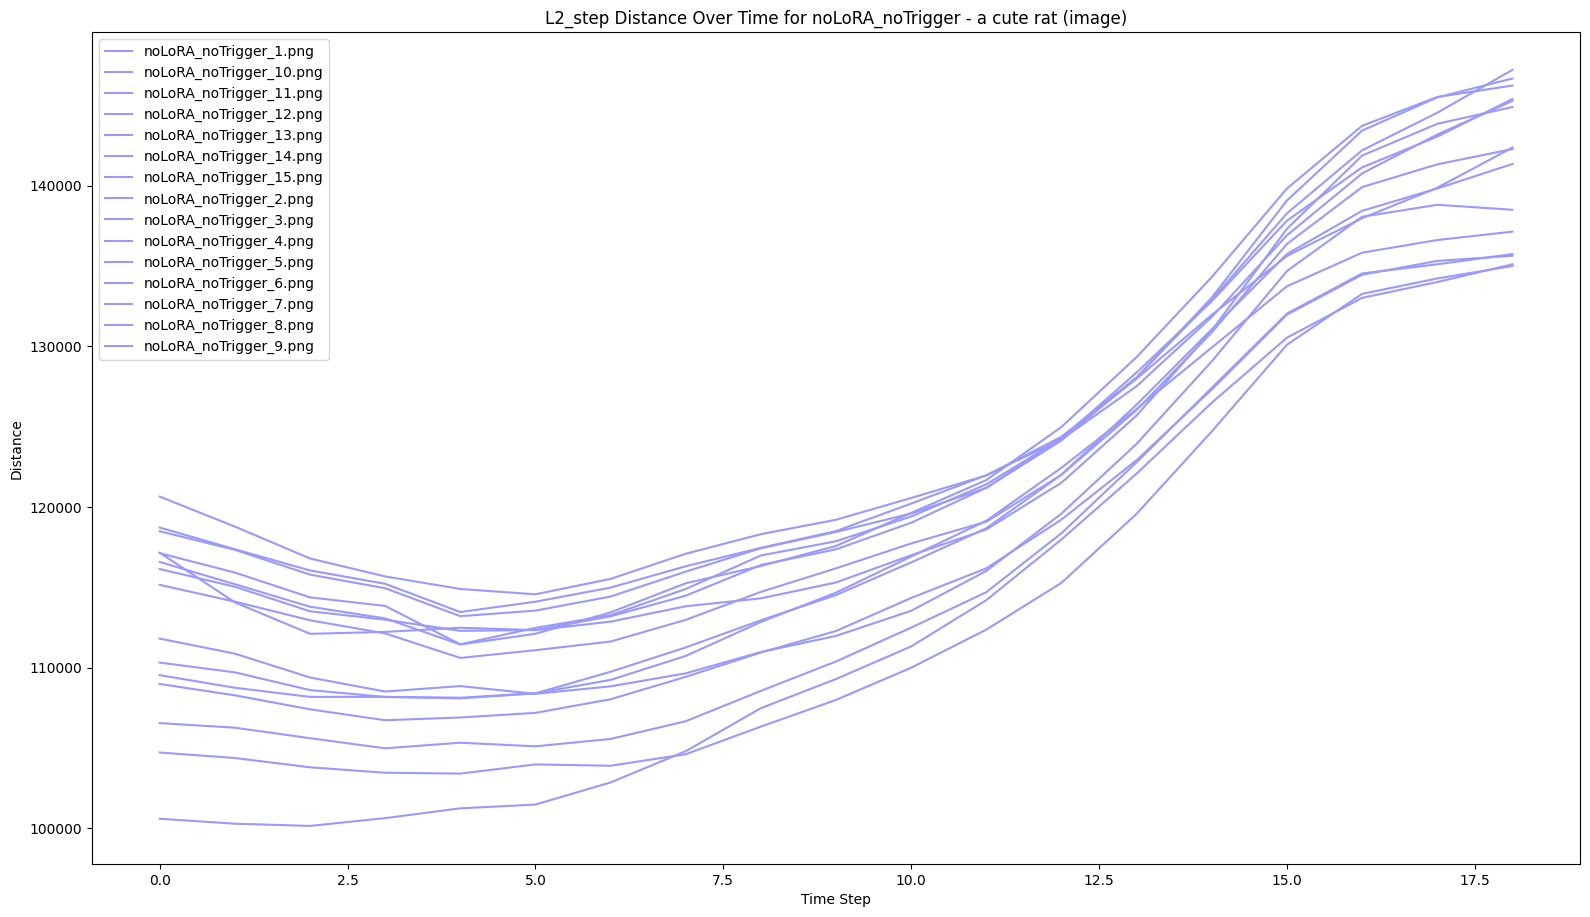

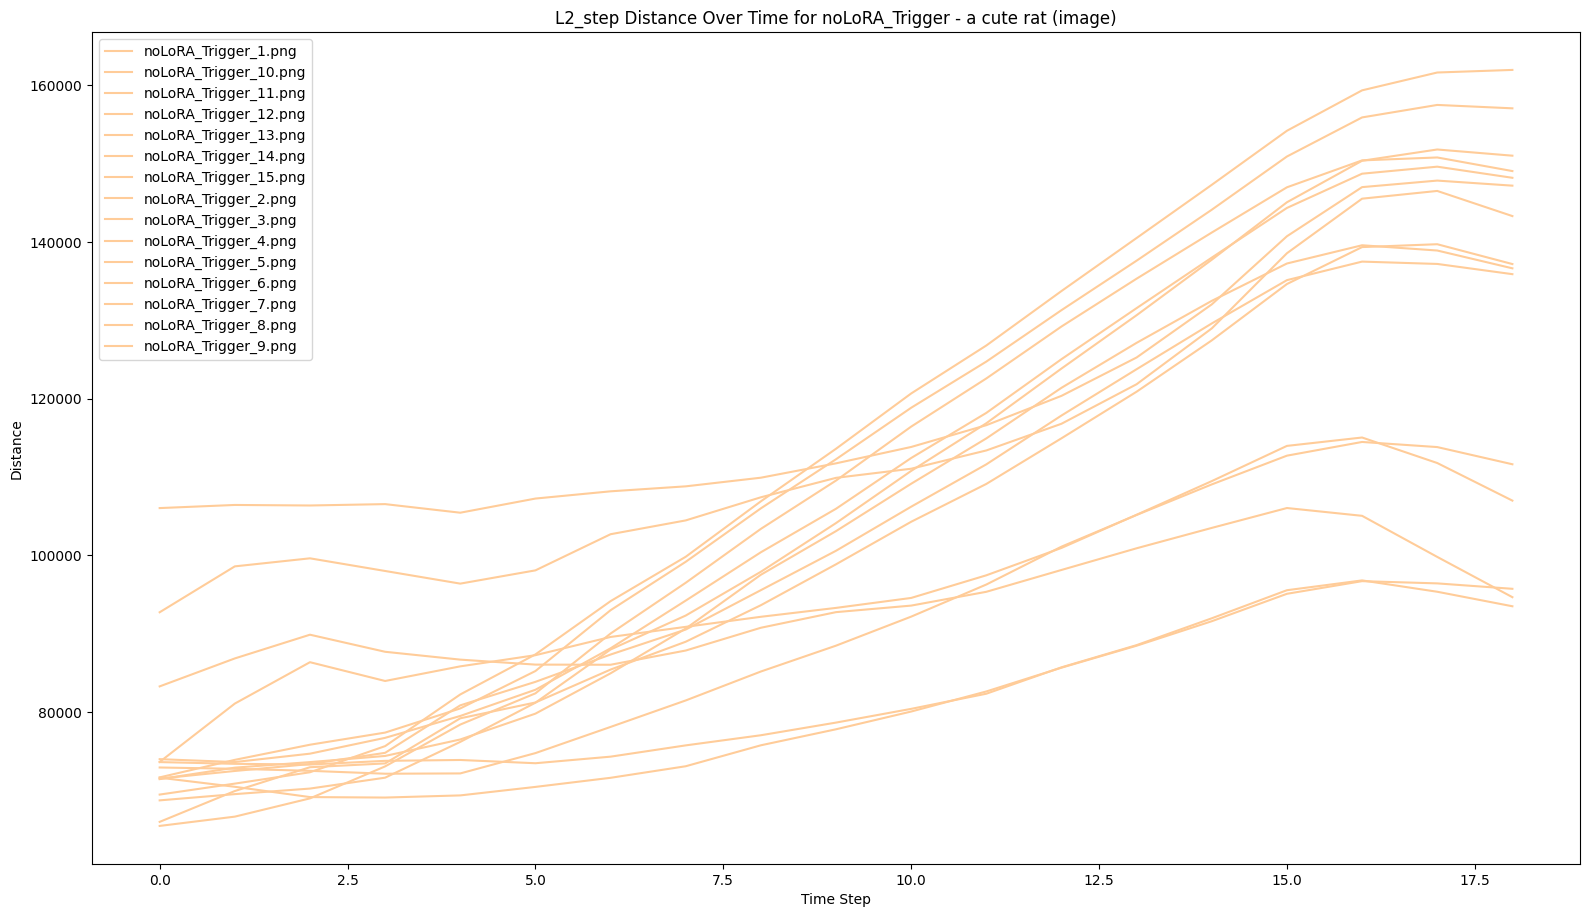

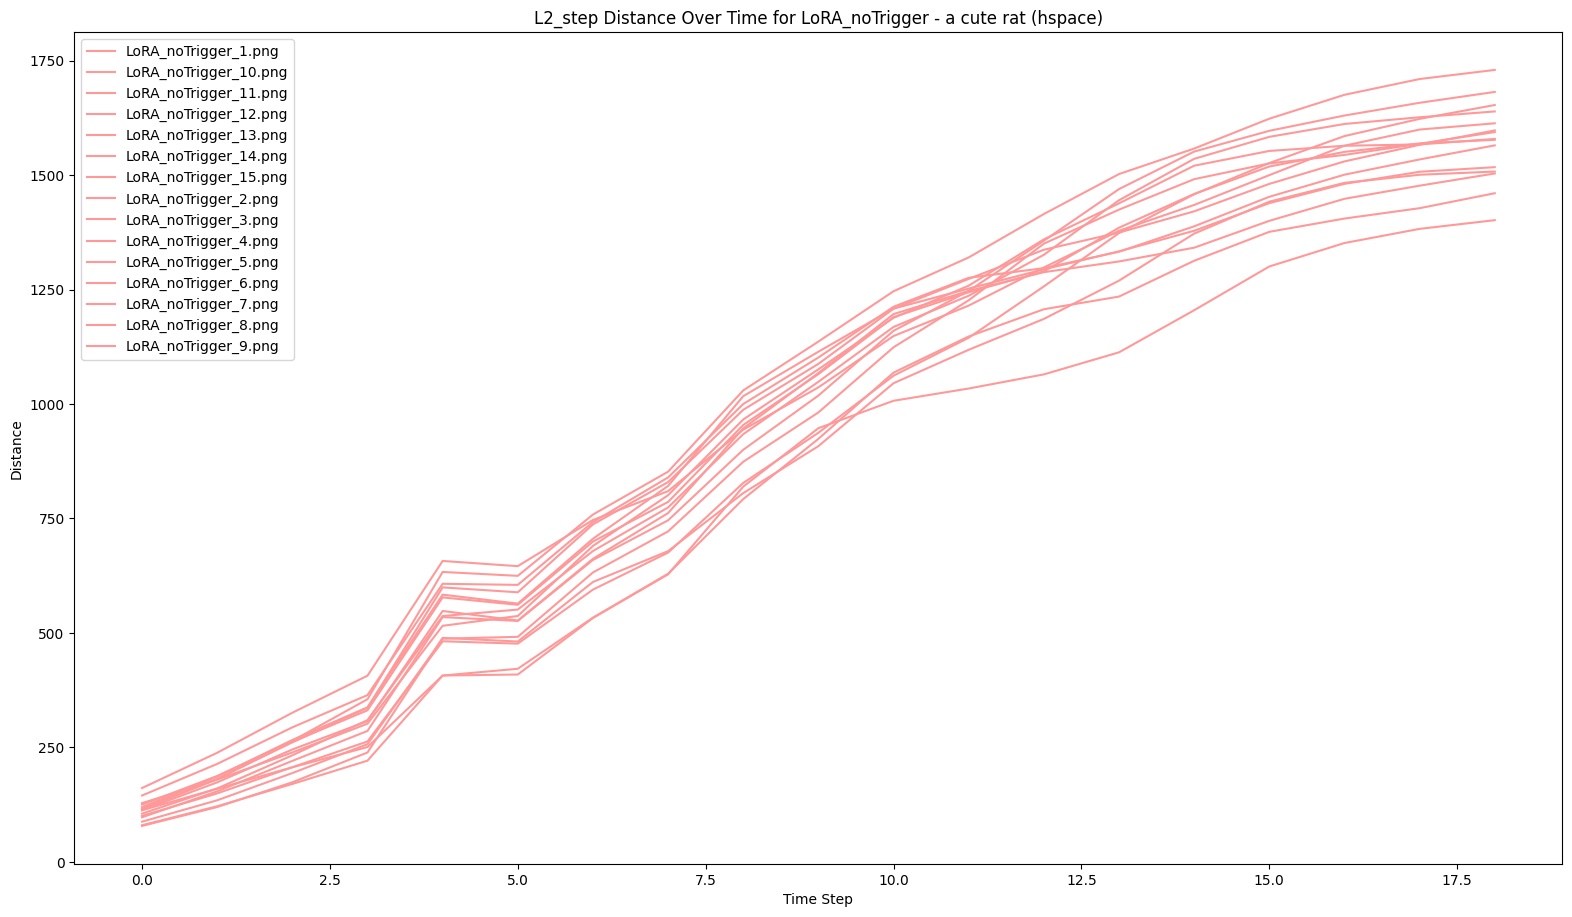

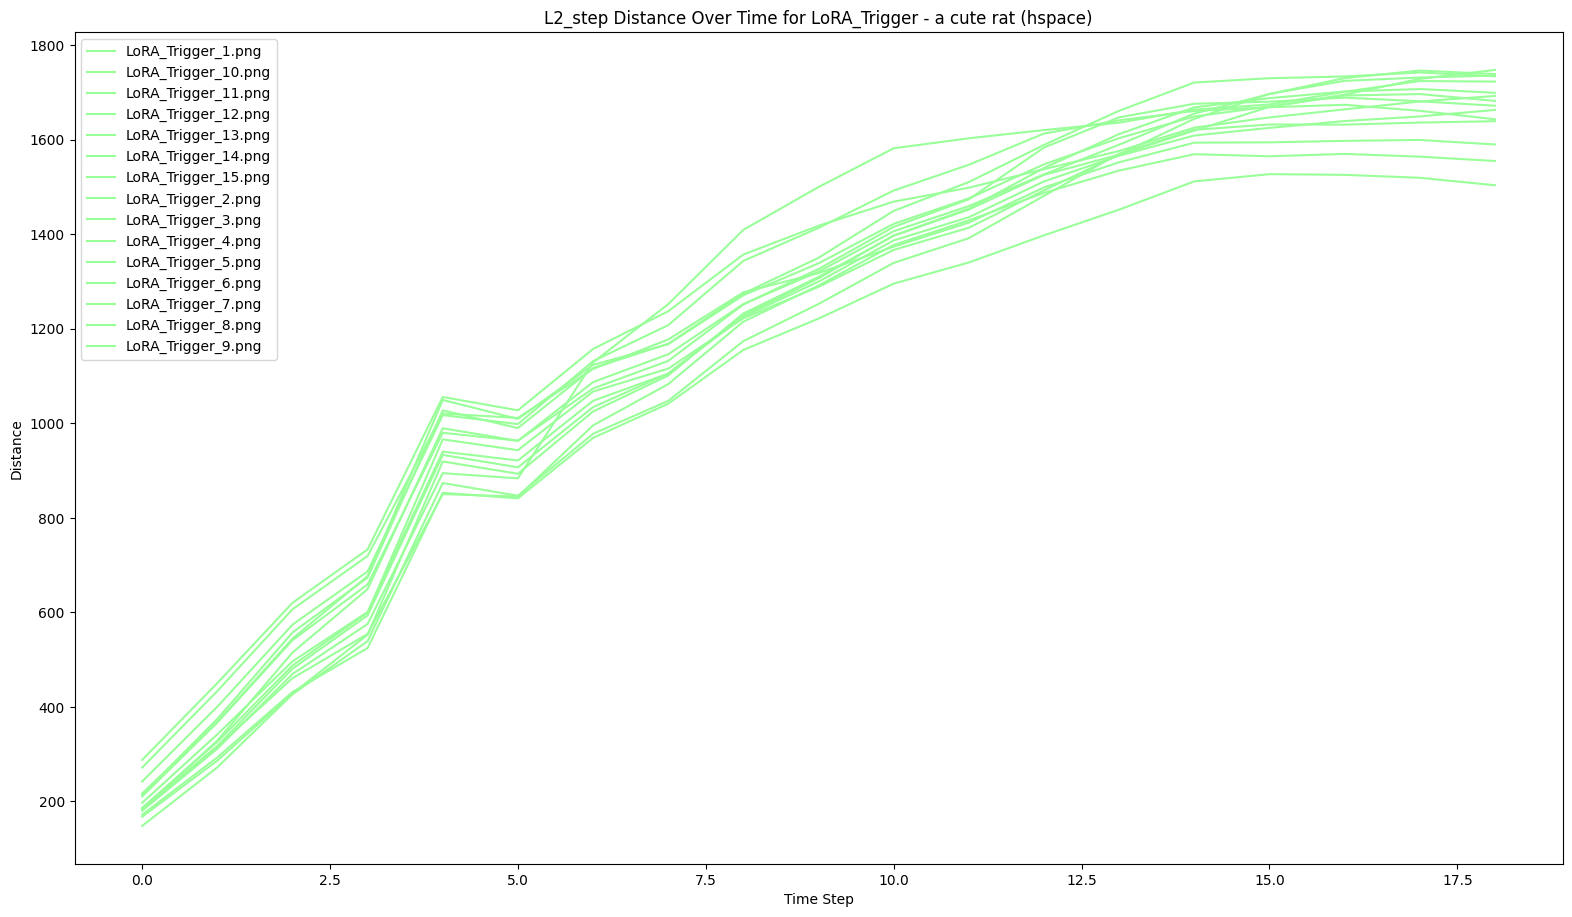

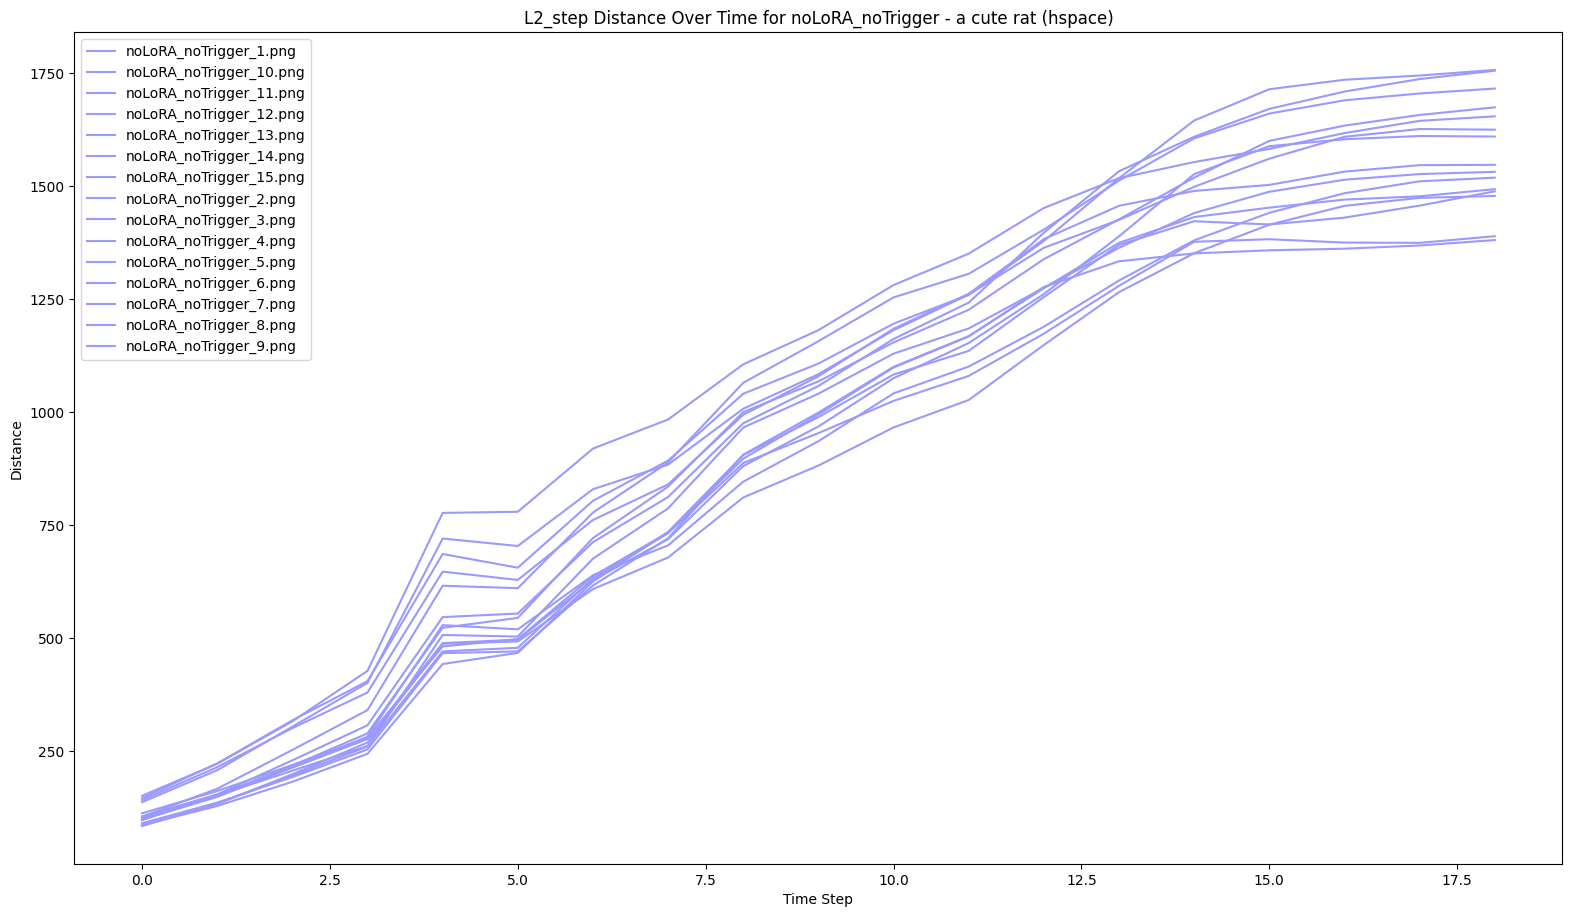

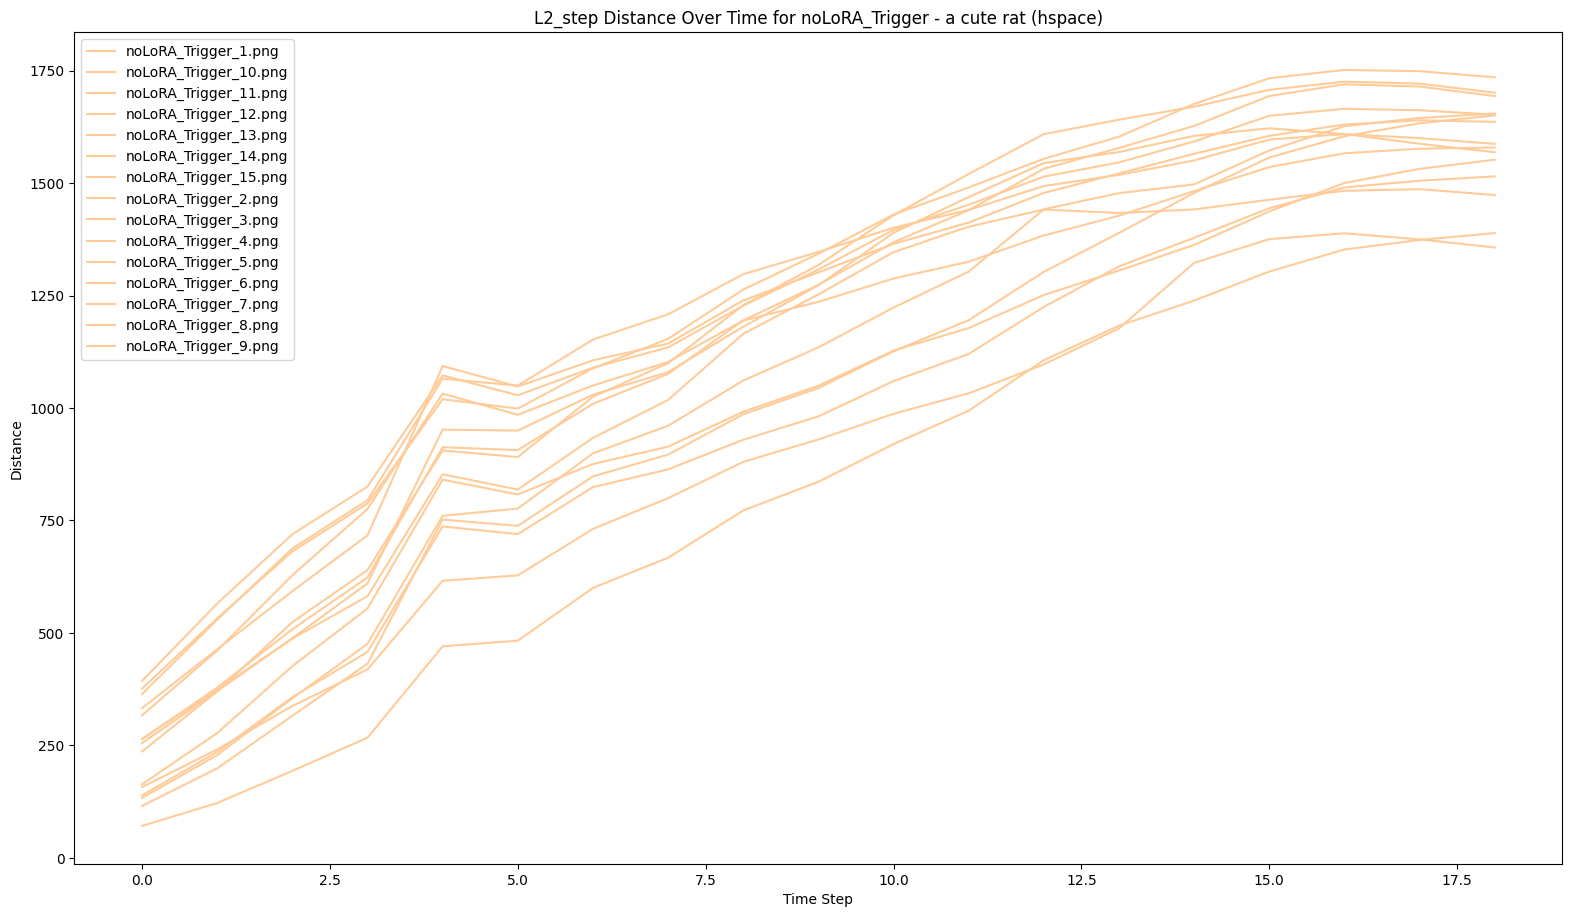

In [50]:
# Example usage
l2_analysis_data = calculate_distance_over_time(experiment_data, euclidean)
plot_distance_over_time(l2_analysis_data, 'latent', "L2_step")
plot_distance_over_time(l2_analysis_data, 'image', "L2_step")
plot_distance_over_time(l2_analysis_data, 'hspace', "L2_step")

In [51]:
# 參考上面的，但每種距離個畫一張圖就好，latent 一張(裡面有每個 prefix)，image 一張(裡面有每個 prefix)，hspace 一張(裡面有每個 prefix)
# 並且每張圖上的線條(prefix)要有不同的顏色，並且要有圖例
# 並且要有標題，標題要顯示 distance_type、prefix、prompt、key
# 並且要有 x 軸標籤、y 軸標籤

def plot_distance_over_time_draw_by_distance(analysis_data, key, distance_type="L2_step"):
    colors = {'LoRA_noTrigger': '#FF9999', 'LoRA_Trigger': '#99FF99', 'noLoRA_noTrigger': '#9999FF', 'noLoRA_Trigger': '#FFCC99'}
    plt.figure(figsize=(19.2, 10.8))
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            for image_name in analysis_data[prefix][prompt].keys():
                distances = analysis_data[prefix][prompt][image_name][key]
                plt.plot(range(len(distances)), distances, label=f'{prefix} - {prompt} - {image_name}', color=colors[prefix])
    plt.xlabel('Time Step')
    plt.ylabel('Distance')
    plt.title(f'{distance_type} Distance Over Time ({key})')
    plt.show()


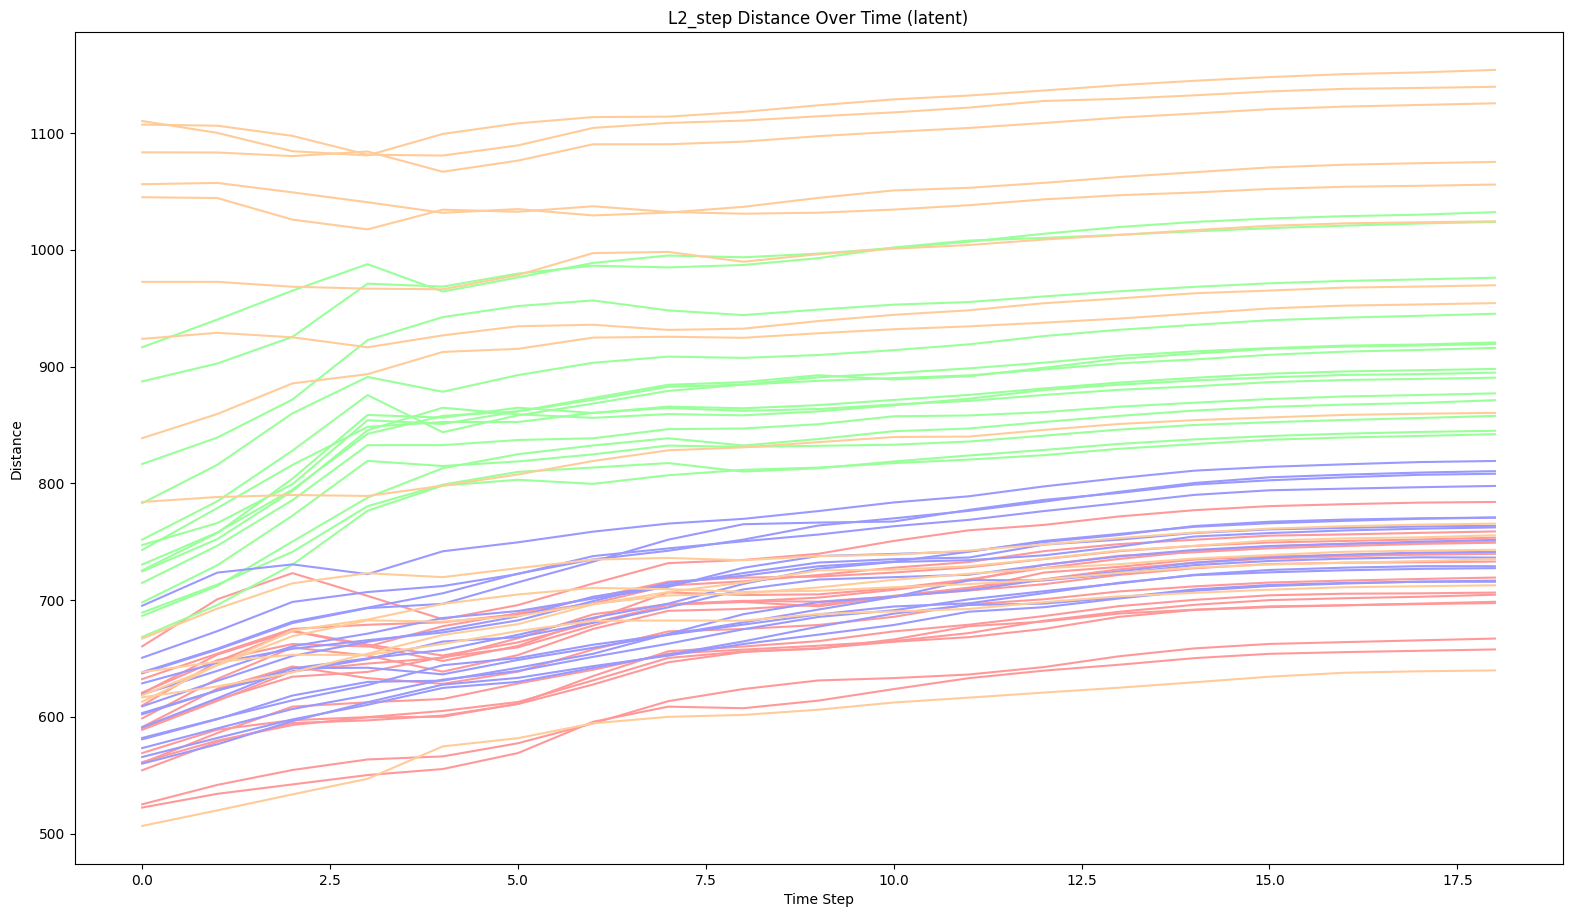

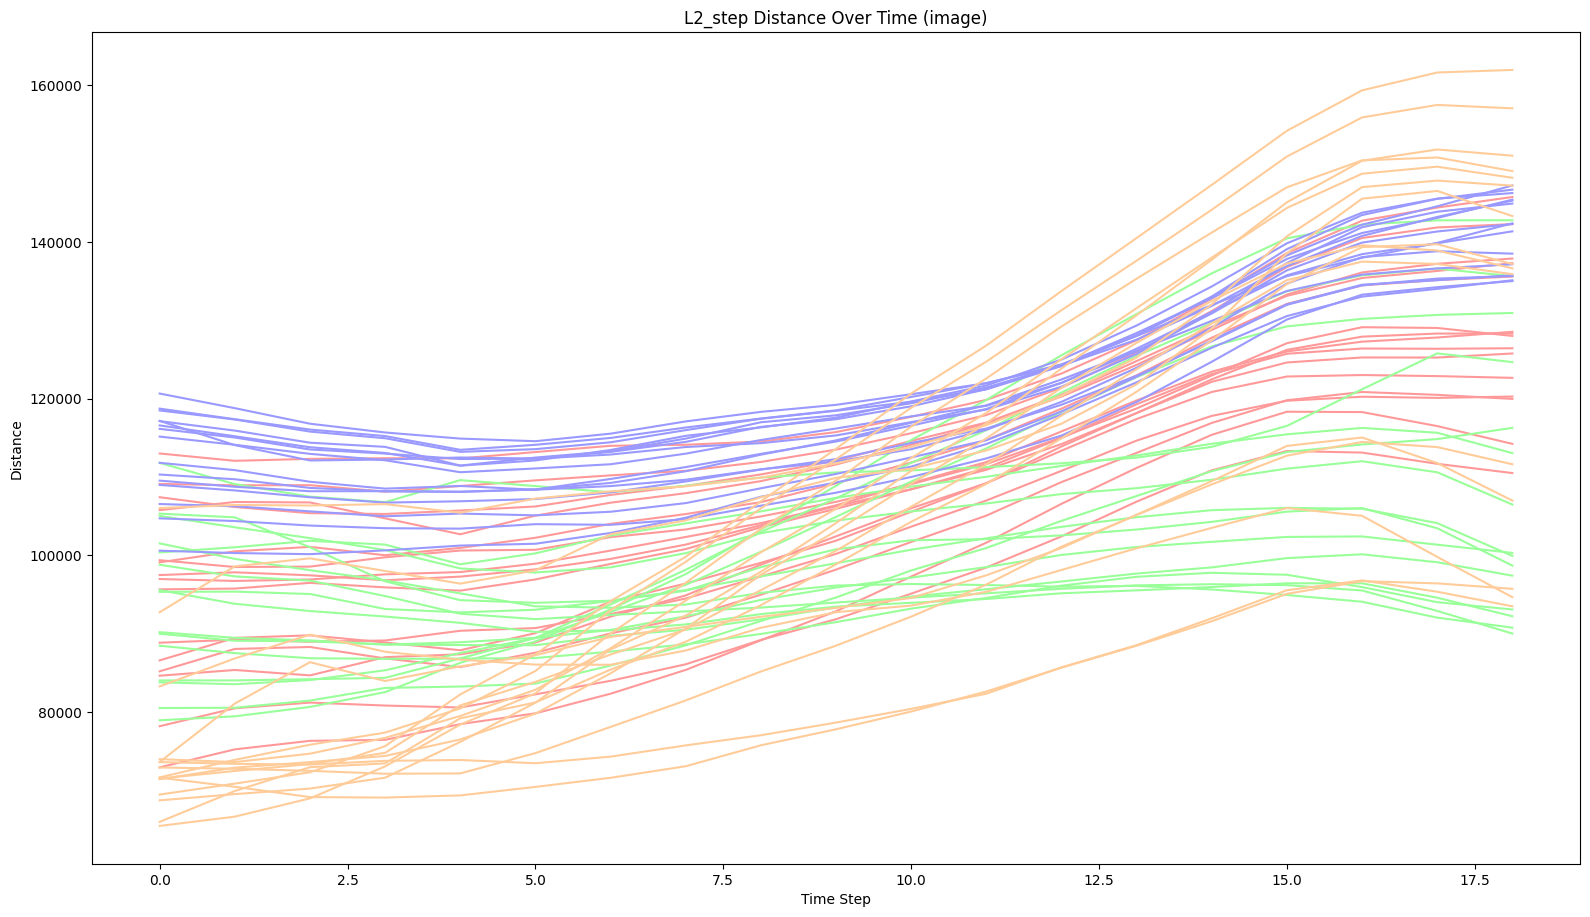

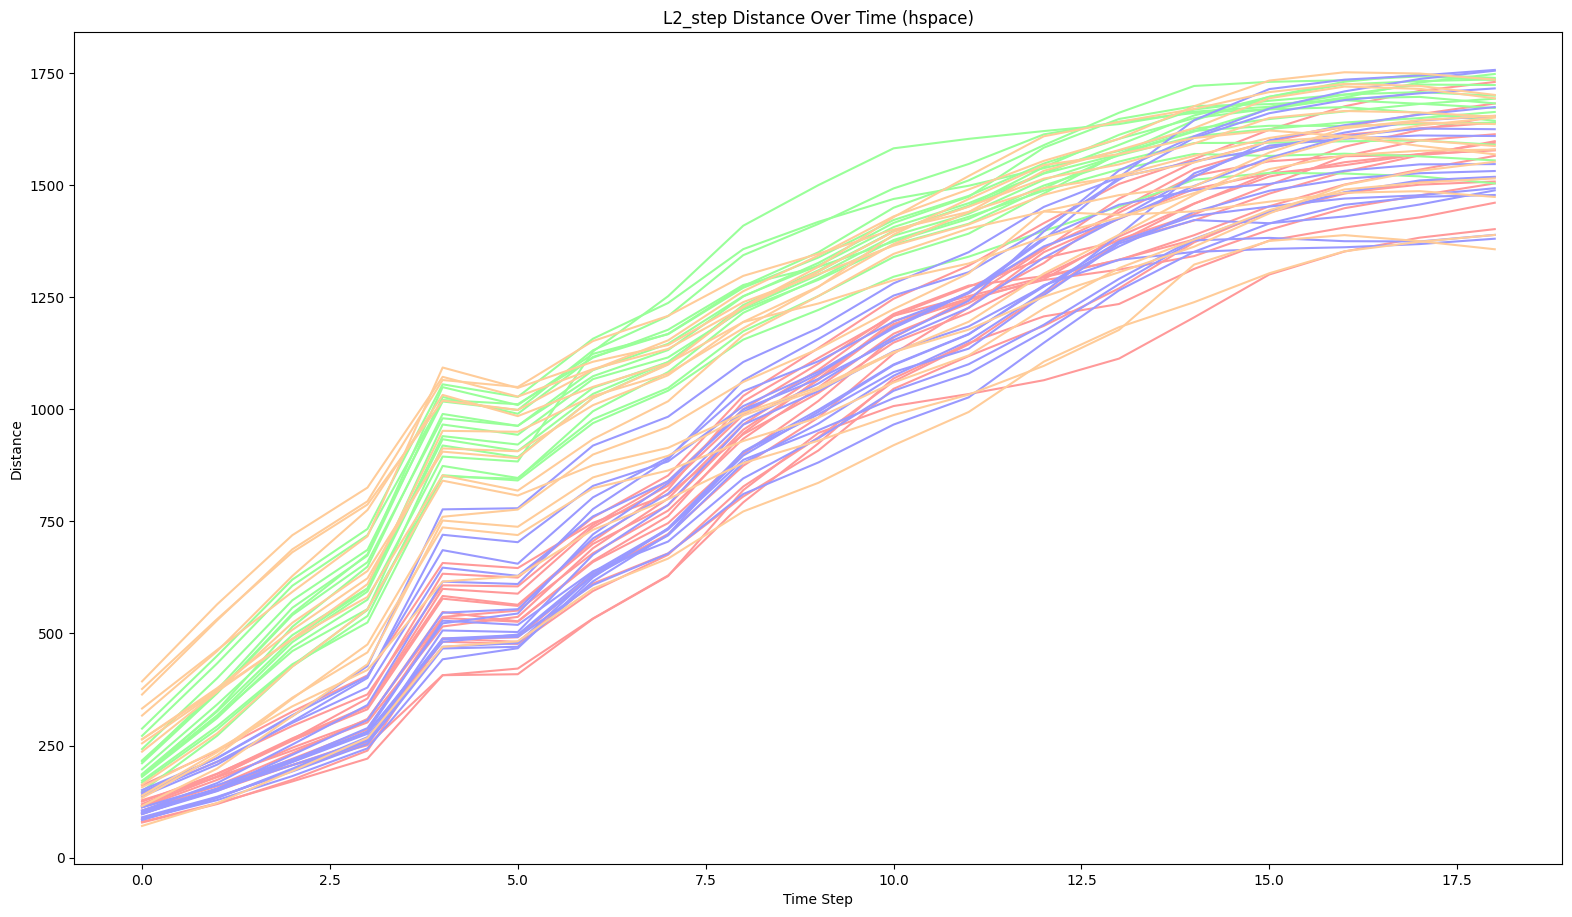

In [52]:
# Example usage
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'latent', "L2_step")
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'image', "L2_step")
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'hspace', "L2_step")

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


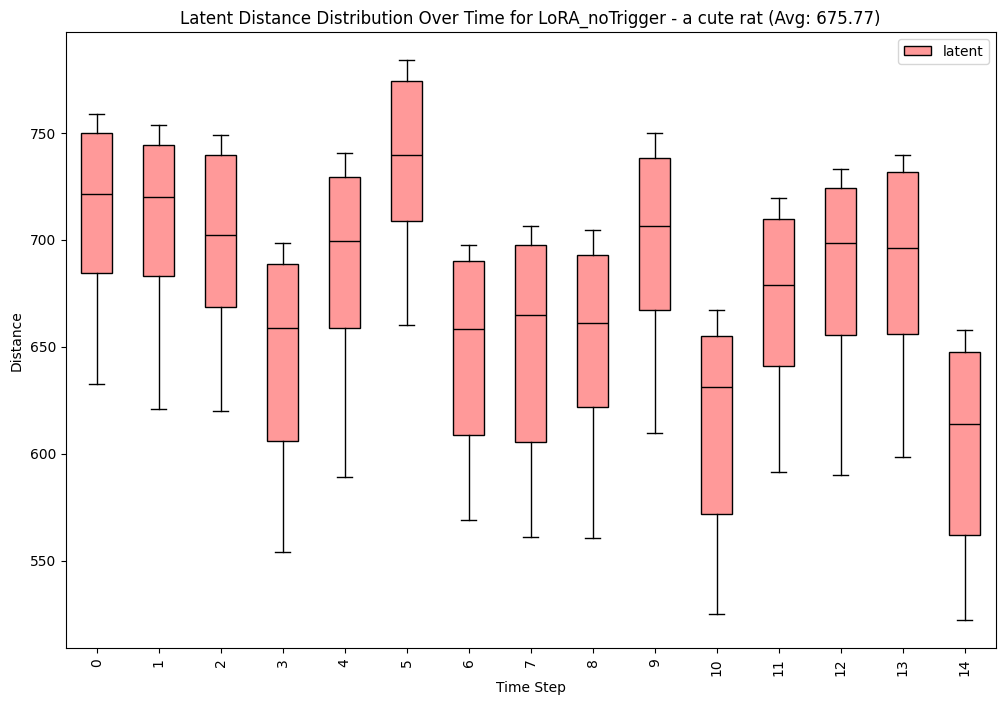

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


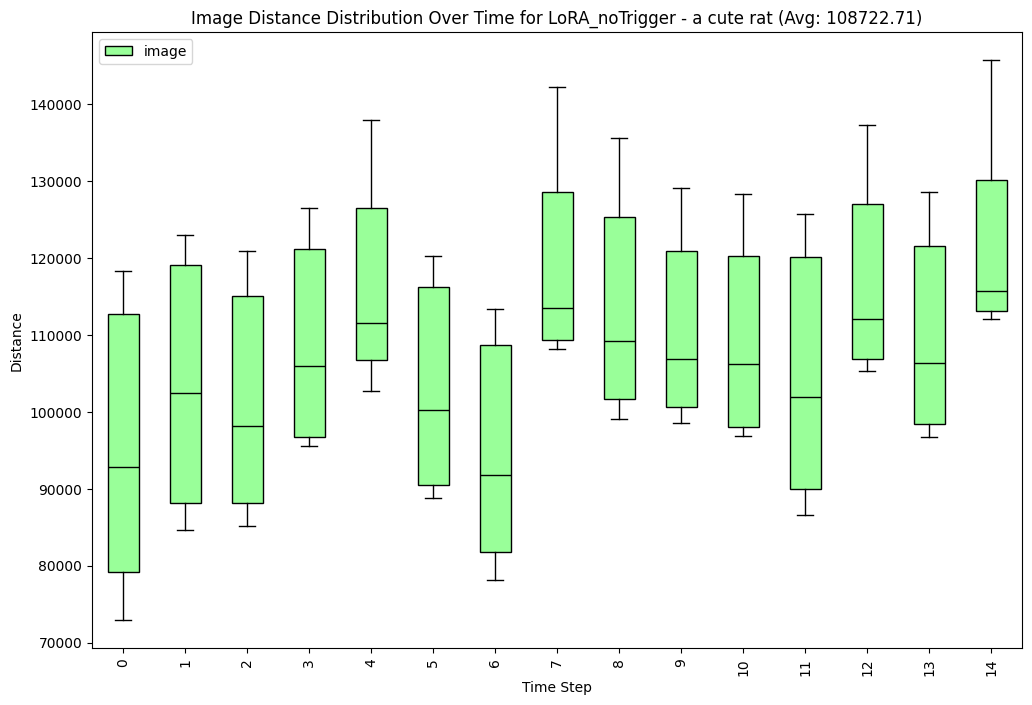

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


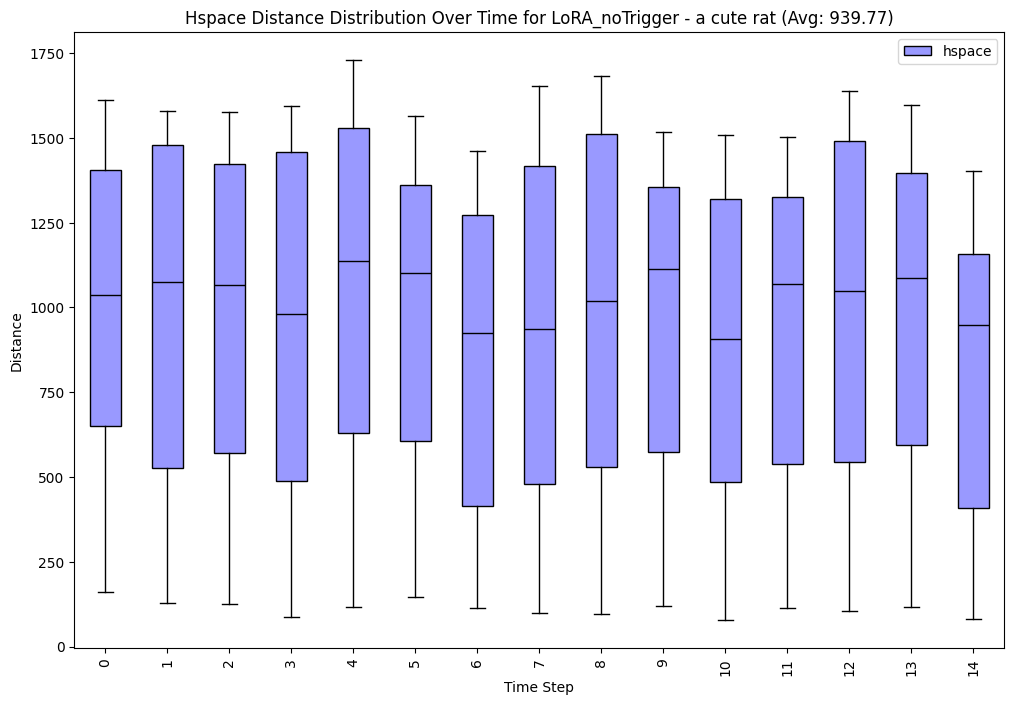

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


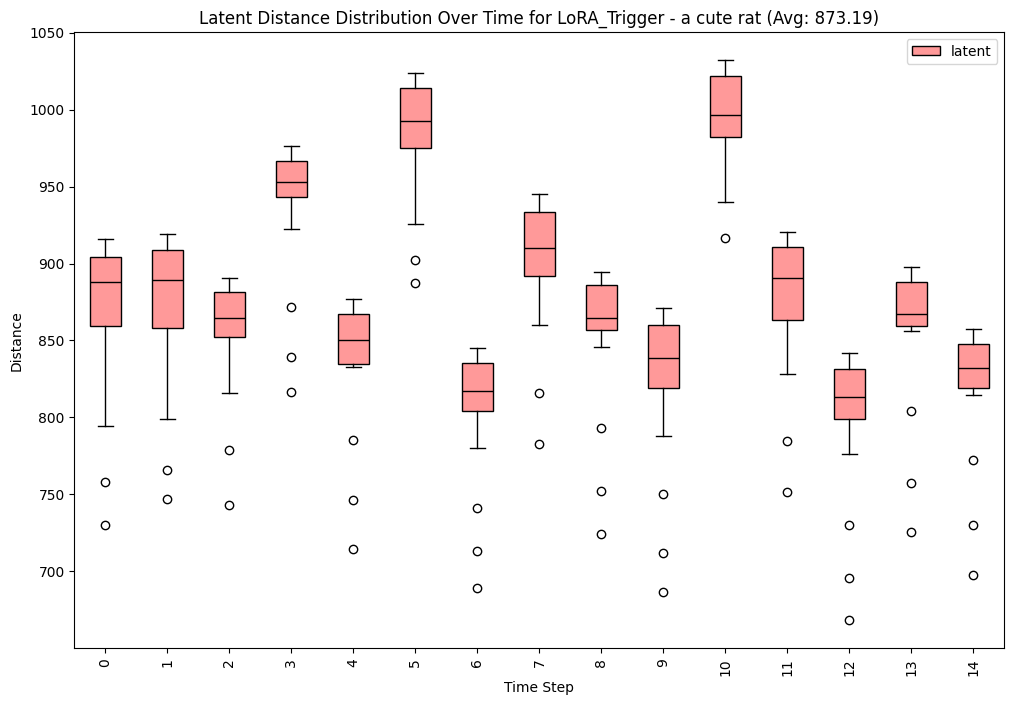

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


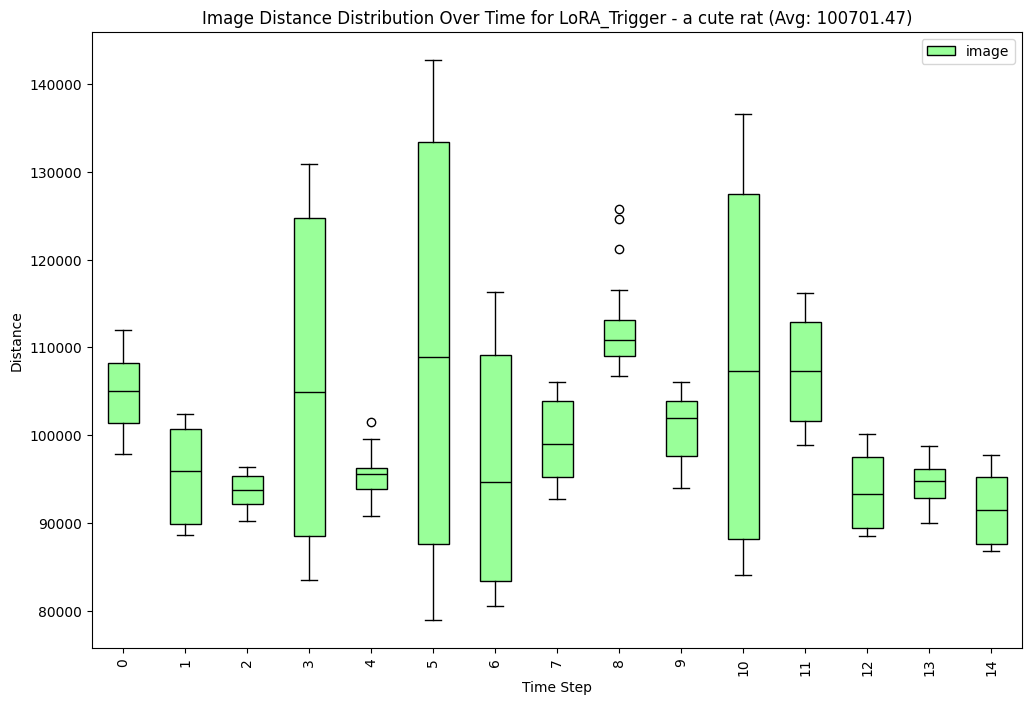

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


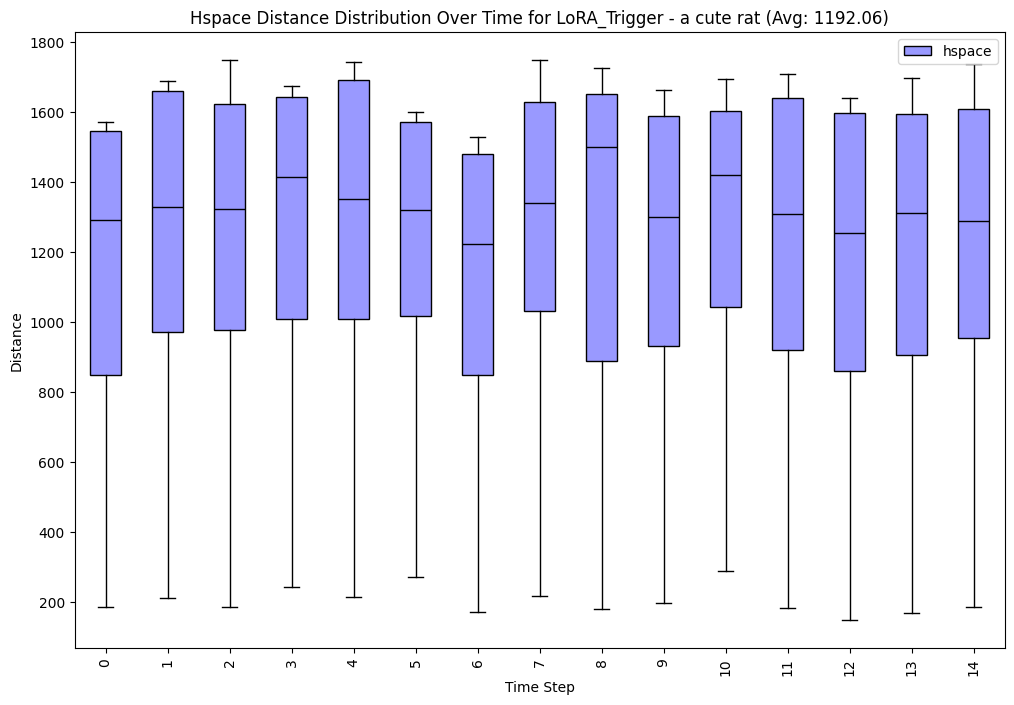

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


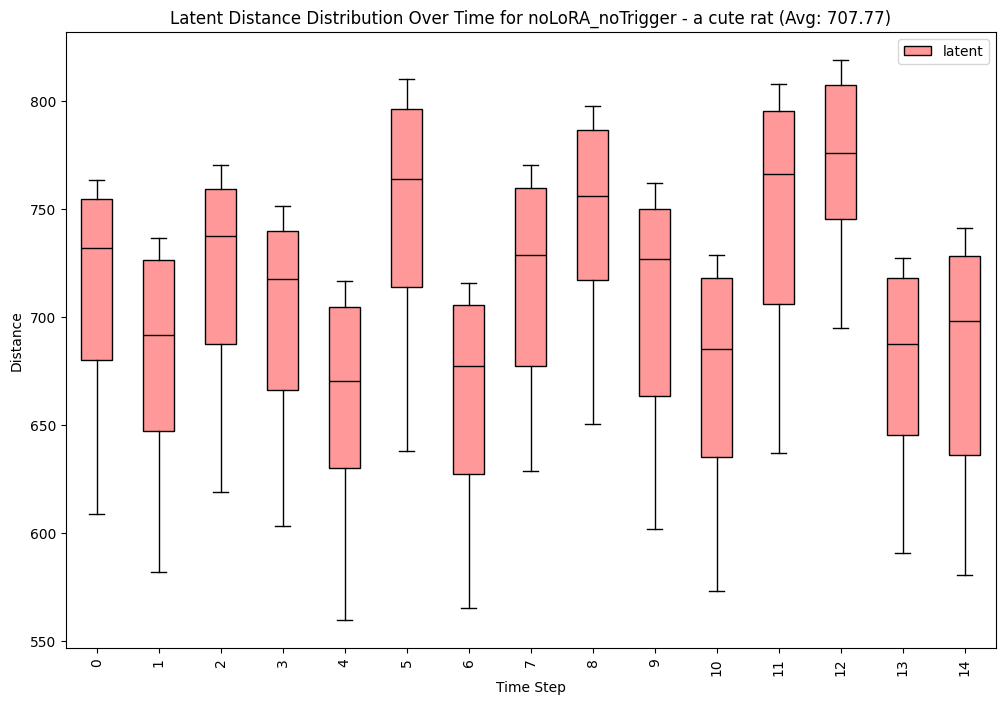

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


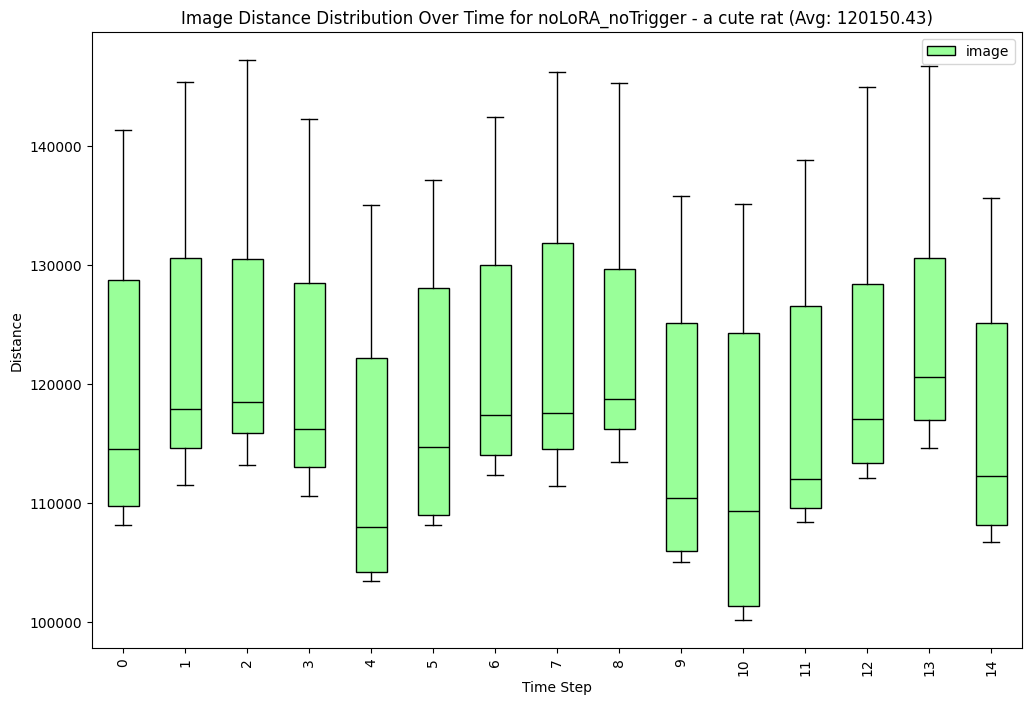

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


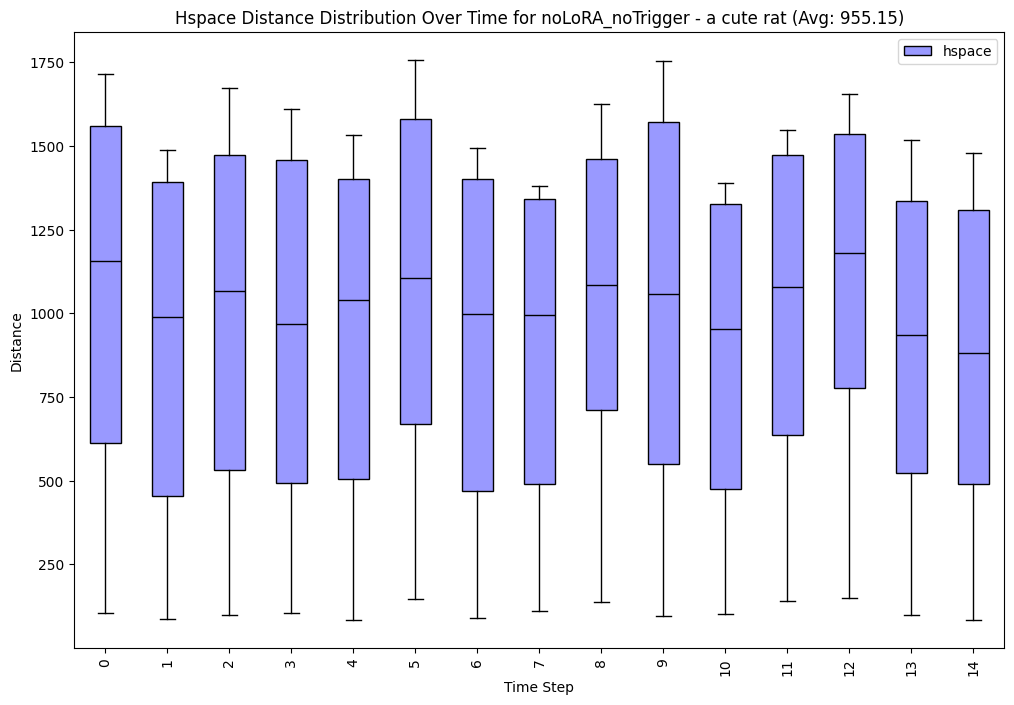

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


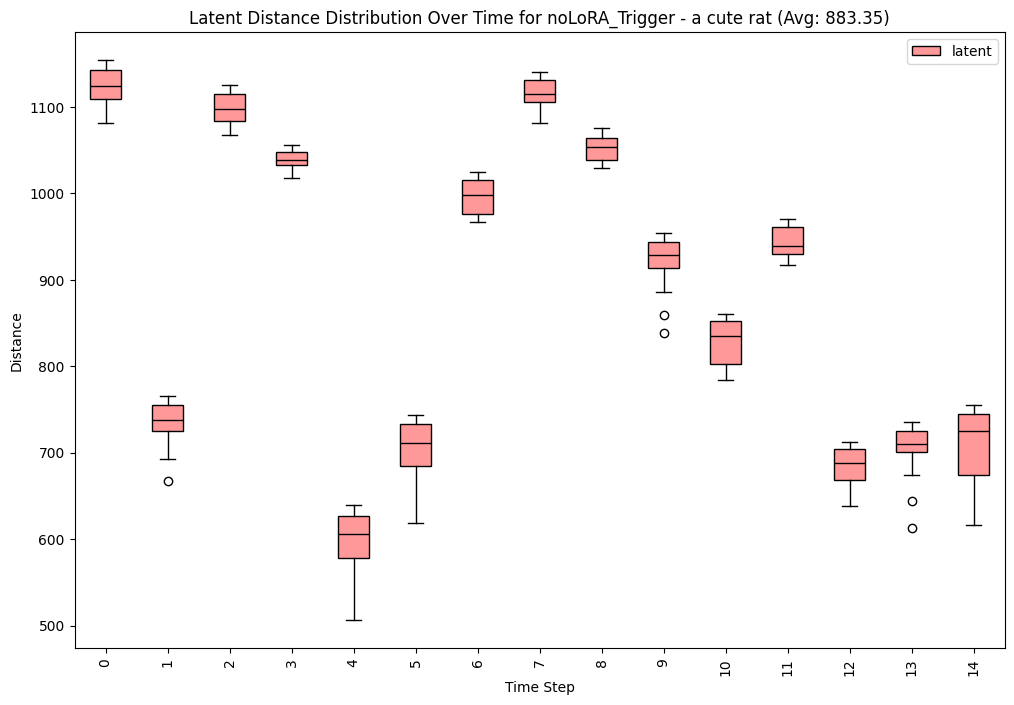

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


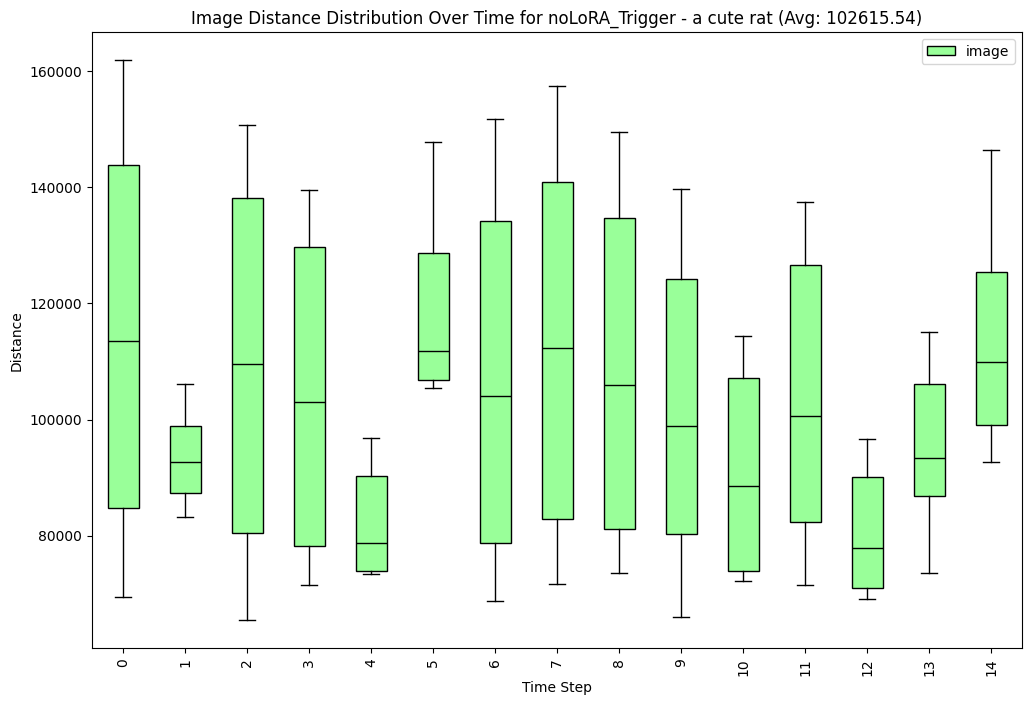

C:\Users\9373k\AppData\Local\Temp\ipykernel_28440\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


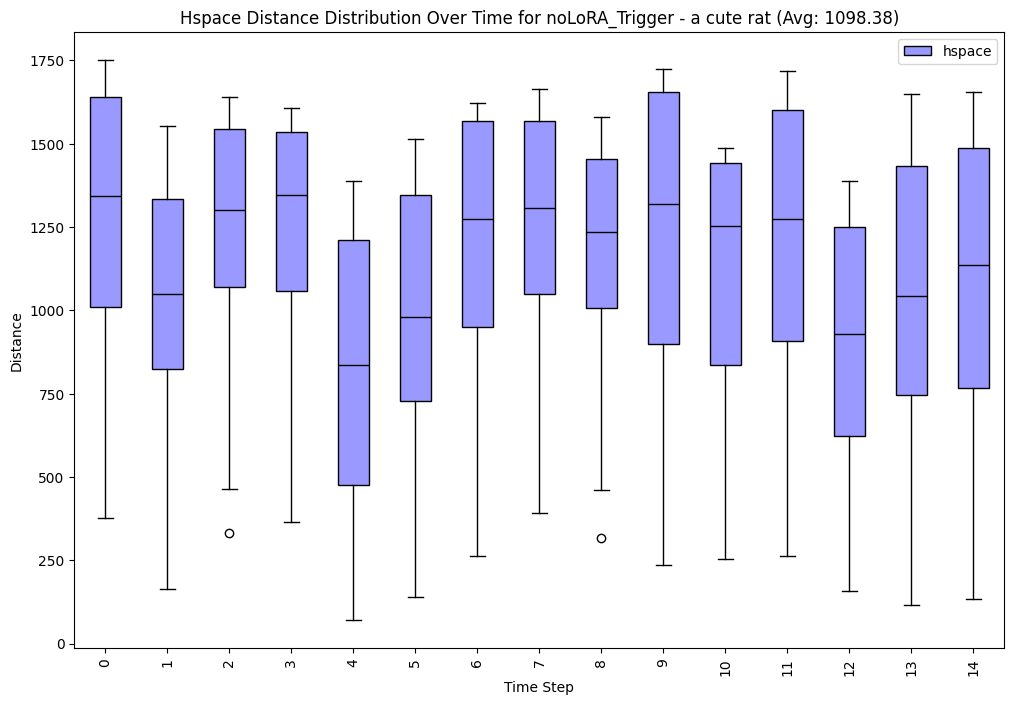

In [59]:
def plot_boxplot_time_step_as_x_axis(analysis_data):
    colors = {'latent': '#FF9999', 'image': '#99FF99', 'hspace': '#9999FF'}
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            data_to_plot = {'latent': [], 'image': [], 'hspace': []}
            for image_name in analysis_data[prefix][prompt].keys():
                for key in ["latent", "image", "hspace"]:
                    data_to_plot[key].append(analysis_data[prefix][prompt][image_name][key])
            
            for key in ["latent", "image", "hspace"]:
                plt.figure(figsize=(12, 8))
                box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))
                avg_distance = np.mean([np.mean(data) for data in data_to_plot[key]])
                plt.ylabel('Distance')
                plt.xlabel('Time Step')
                plt.title(f'{key.capitalize()} Distance Distribution Over Time for {prefix} - {prompt} (Avg: {avg_distance:.2f})')
                plt.xticks(rotation=90)
                plt.legend([key])
                
                # Set the average line of each box as black
                for median in box['medians']:
                    median.set_color('black')
                
                plt.show()

# Example usage
plot_boxplot_time_step_as_x_axis(l2_analysis_data)
